#Setup

Import common packages

In [ ]:
!apt-get update
!apt-get install wkhtmltopdf
!pip install imgkit
#in environments where the pickle and pandas modules are incompatible...
!pip install pandas==1.5
!pip install openpyxl

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Ign:2 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,218 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,552 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,861 kB]
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,443 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,132 kB]
Get:14 http://security.ubu

In [ ]:
%%capture
import argparse
import datetime
from functools import reduce
import glob, imgkit
import itertools as it
from multiprocessing import cpu_count, Pool
print(cpu_count())

import numpy as np
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random, re, shutil
from scipy.stats import hmean
import sklearn.metrics
from sklearn.metrics import auc, average_precision_score, precision_recall_curve
import seaborn as sns
import subprocess as sp
import sys
import tempfile as tf
import time
from tqdm import tqdm as progressMonitor

Enable Google Colab, mount drives, and load/define proprietary modules

In [ ]:
%%capture
from google.colab import drive, files, output
drive.mount('/content/drive', force_remount=True)
!rm -r sample_data/

In [ ]:
#useful to keep track of sys vars so as to better monitor space remaining
sysVars = list(globals().keys())

Define directories and principal object paths

In [ ]:
rootDir = '/content/drive/MyDrive/'
workDir = rootDir + 'elcfs_protein_complex_modeling/' #phase2 directory
workDir_elcfs = rootDir + 'proteinPairs_complexMaps/' #modeling library
workDir_ph1 = rootDir + 'Primary Research/JLMwSCBC_notebook/' #phase 1 directory
workDir_other = rootDir + 'otherStudies/'

sys.path.insert(0, rootDir)
for p in workDir, workDir_elcfs, workDir_ph1, workDir_other: sys.path.append(p)

In [ ]:
from util import modelEvaluating
from utils import operations, reference, alertMe
pushoverKey_user = 'uith8rmy2npjj1oqpjwcanow3un984'
pushoverAPI = 'aw4v3424kaznrw598r6qge9icddwg7'

In [ ]:
setupDir = workDir + 'setup/'
refDir = workDir + 'srcData/'
ph1Model_perfDir = workDir_ph1 + 'modelPerformance/'
graphicsDir = './manuscriptGraphics/'

In [ ]:
def df2Img(df, name, path):
  #this function generates graphics from pandas dataframes with a uniform style
  ##recommended props (still experimenting with what appeals most)
  '''
  df = \
    df.style.set_table_styles([dict(
        selector='th',
        props=[
            ('text-align', 'center'),
             ('background-color', '#40466e'),
              ('color', 'white')])])
  df.set_properties(**{'text-align': 'center'}).hide(axis='index')
  pd.set_option('colheader_justify', 'center')
  '''

  htmlIntermediate = df.to_html()
  imgkit.from_string(htmlIntermediate, path + name + '.svg')
  imgkit.from_string(htmlIntermediate, path + name + '.png')

#Alert tool

In [ ]:
#copy the contents between the ellipses into the cell subsequent to that for
# which the run time is long
'''
#put this block after any cell expected to take a long time
cmdReport = alertMe.statusCheck(pushoverAPI, pushoverKey_user)
cmdReport.finishPush()
'''

'\n#put this block after any cell expected to take a long time\ncmdReport = alertMe.statusCheck(pushoverAPI, pushoverKey_user)\ncmdReport.finishPush()\n'

###**Results**

In [ ]:
#Functionality for fresh download of latest repository unavailable due to
# continuing recovery of website from cyberattack.
# Refer to https://www.biostars.org/p/9563995/
# Downloaded latest repository of CORUM complexes, release 2018.07.01.
corumData = workDir + 'srcData/CORUM/corum.xlsx'
accessCORUM = reference.CORUM(corumData)
humanProts = set(accessCORUM.humanProts)
print(len(humanProts))

3375


In [ ]:
dataSrc_protsDir = workDir + 'featureData/fullSet_proteinOrigins.pkl'
dataSrc_prots = pickle.load(open(dataSrc_protsDir, 'rb'))

dataSrc_prots['association'] = dataSrc_prots.pop('pairLevel')
dataSrc_prots['expression'] = dataSrc_prots.pop('proteinLevel')

dataSrc_prots['assc+exp'] = dataSrc_prots.pop('pair+proteinLevel')
dataSrc_prots['assc+exp_geneIDs_proteinCoding'] = \
  dataSrc_prots.pop('pair+proteinLevel_geneIDs_proteinCoding')

In [ ]:
for k, v in dataSrc_prots.items():
  print(k, len(v))

huMAP1 13276
huMAP2 15554
BioPlex3 15094
FANTOM5 17352
HPA 11018
NCI-60 22728
Uhlén 18203
SCBC 11643
gTEX 18328
association 17132
expression 23830
assc+exp 24443
assc+exp_geneIDs_proteinCoding 19057


In [ ]:
humap1Dir = refDir + 'huMAP1/'
humap2Dir = refDir + 'huMAP2/'
bcb19Dir_LM = refDir + 'Lugo-Martinez2019/'
stringdbDir = refDir + 'STRING/'
geneidDir = refDir + 'ftp.ncbi.nih.gov-gene-DATA-GENE_INFO/'
cmpStudies = reference.cmpStudies_props(
    humap1Dir, humap2Dir, bcb19Dir_LM, stringdbDir, geneidDir)
cmpStudies.go()

###**Table 1. Summary of predictors for pairwise protein interactors and complex assemblies. We provide information on each predictor/method, including the total number of proteins (n) and the number of possible protein-pairs (n choose 2). We report the number of pairs for which there is a CORUM-based label for training classifiers, the total number of predictions, and the number of predictions for which labels and data were available. We also included the total number of complex predictions alongside the numbers of protein-pairs and proteins available for constituting these complex assemblies.**

> *Insert caption: include definitions of headings (pairs=pairs choose 2), no exp for preds, preds=predictions on pairs for which we have data, complexes = combined top5 models for ELCFS, hu.MAP 1+2, explain for STRING and LM2019*

> *Should explanation, re combining top5, etc., be communicated solely within the text of the manuscript?*

> *Should we consider??? including the release dates for each version of CORUM, e.g., 2010, 2017, and 2018; (where? maybe just in manuscript? )*
[could also include table for how CORUM has evolved or drifted since I created that for making comparisons](https://colab.research.google.com/drive/1dyRokY9dufARPLP7BzxygWeFAd_JmsEC?usp=sharing)


*Pooling functions take 7mins to initiate...*

In [ ]:
#alternative layout (KEEP)
#(To-Do *1)
#Add column for 'Combined' and change ELCFS to 'Full'...✔️
#Move STRING to the right...✔️
#Add row for non-human proteins...✔️
#Add row for non-human pairs...✔️
#Add row for human-non-human pairs...✔️

In [ ]:
#Reorder...✔️
#Pairs with data (total predictions)...✔️
#Proteins in those pairs...✔️
#Possible pairs of those proteins...✔️
#Pairs labeled...✔️
#Proteins in labeled pairs (new number)...✔️

#Labeled pairs with data (old predictions labeled)...✔️
## what about "Pairs with data (labeled)"

#Fraction of labeled pairs predicted...✔️
#Fraction of proteins with data predicted...✔️
#Move predictions line (4) to first line...✔️
#Delete combined column...✔️
#Correct complexes for full...✔️
#Add Non-human proteins in complexes...✔️
#Push Non-human proteins and pairs above complexes...✔️
#Below complexes' ppis: add non-human proteins in complexes...✔️

*Proteins Total
*Pairs Total
*Pairs labeled
*Proteins labeled

In [ ]:
tbl1 = cmpStudies.makeTbl1()
## subsequent demand consumes a lot of memory
'''
tbl1 = cmpStudies.generateSummary()
'''

tbl1.to_csv(graphicsDir + 'table_1.csv')
tbl1

#To-Do
#Add below Non-human proteins, non-human pairs: (a) human proteins with data, (b) human possible pairs

,hu.MAP 1.0,hu.MAP 2.0,Lugo-Martinez 2019,Full,STRING v.12
Pairs with data,"2,557,860","17,564,755","20,615,986","162,758,569","6,881,445"
Proteins with data,"13,276","15,554","6,883","19,340","19,232"
Possible pairs (proteins with data),"88,119,450","120,955,681","23,684,403","187,008,130","184,925,296"
Pairs labeled,"5,446,857","3,435,064","1,408,681","9,514,346","6,184,140"
Proteins in labeled pairs,"3,835","2,993","1,679","5,137","3,643"
Labeled pairs with data,"235,020","2,299,721","1,038,169","6,601,161","773,026"
Fraction of labeled pairs predicted,0.042,0.41,0.73,0.69,0.13
Fraction of proteins with data predicted,0.029,0.15,0.87,0.87,0.037
Non-human proteins,"1,800",583,0,"2,069",0
Human proteins with data,"12,954","14,971","6,883","17,271","19,232"


###**Table 2. Summary of features' groupings, sources, experimental origins, and contributions.**

> ***Does Table 2 actually need a caption?***

In [ ]:
tbl2 = pickle.load(open(workDir_elcfs + 'manuscript/table_2.pkl', 'rb'))
tbl2.to_csv(rootDir + 'manuscriptResults_local/table_2.csv', )
#tbl2.to_csv(graphicsDir + 'table_2.csv')
tbl2

Experiment  \
Feature combination Source                                                                              
SVM KD17            BioPlex 1.0                                                                 AP-MS   
                    Hein et al., 2015                                                           AP-MS   
                    Wan et al., 2015                                                            CF-MS   
                    Drew et al., 2017                                                           AP-MS   
                    HumanNet 2011                                                        Multi-'omics   
                    Malovannaya et al., 2011                                             AP-MS (MEMO)   
                    Guruharsha et al., 2011                                                     AP-MS   
RF LM               Lugo-Martinez et al., 2019                                                  AP-MS   
                    Human Protein Atlas (v19.3)                                Fluorescent microscopy   
                    NCI-60 Human Tumor Cell Lines Screen             Gene-, protein expression assays   
SVM KD21            BioPlex 2.0                                                                 AP-MS   
                    Boldt et al., 2016                                                          AP-MS   
                    Gupta et al., 2015                                                      Proximity   
                    Youn et al., 2018                                                       Proximity   
                    Treiber et al., 2017; Mallam et al., 2019                            RNA-Pulldown   
                    Kevin et al., 2021                                                          AP-MS   
AF                  BioPlex 3.0                                                                 AP-MS   
                    FANTOM5                                          Regulatory gene expression assay   
                    GTEx (v7)                                  Tissue-specific gene expression assays   
                    Uhlén et al., 2015                         Tissue-specific gene expression assays   
                    Ouyang et al., 2019                                        Fluorescent microscopy   
SCBC                Orre et al., 2019                                                           CF-MS   

                                                              Total  
Feature combination Source                                           
SVM KD17            BioPlex 1.0                                   9  
                    Hein et al., 2015                             4  
                    Wan et al., 2015                            220  
                    Drew et al., 2017                             4  
                    HumanNet 2011                                19  
                    Malovannaya et al., 2011                      1  
                    Guruharsha et al., 2011                       1  
RF LM               Lugo-Martinez et al., 2019                    4  
                    Human Protein Atlas (v19.3)                   4  
                    NCI-60 Human Tumor Cell Lines Screen          2  
SVM KD21            BioPlex 2.0                                  10  
                    Boldt et al., 2016                            4  
                    Gupta et al., 2015                           10  
                    Youn et al., 2018                             5  
                    Treiber et al., 2017; Mallam et al., 2019     4  
                    Kevin et al., 2021                           20  
AF                  BioPlex 3.0                                  11  
                    FANTOM5                                       1  
                    GTEx (v7)                                     1  
                    Uhlén et al., 2015                            1  
                    Ouyang et 

###**Figure 1. Summary cartoon.**
> ***Expand Figure 1, perhaps into two panels, e.g., 1a and 1b, an overview of the pipeline and the modeling method, respectively.***

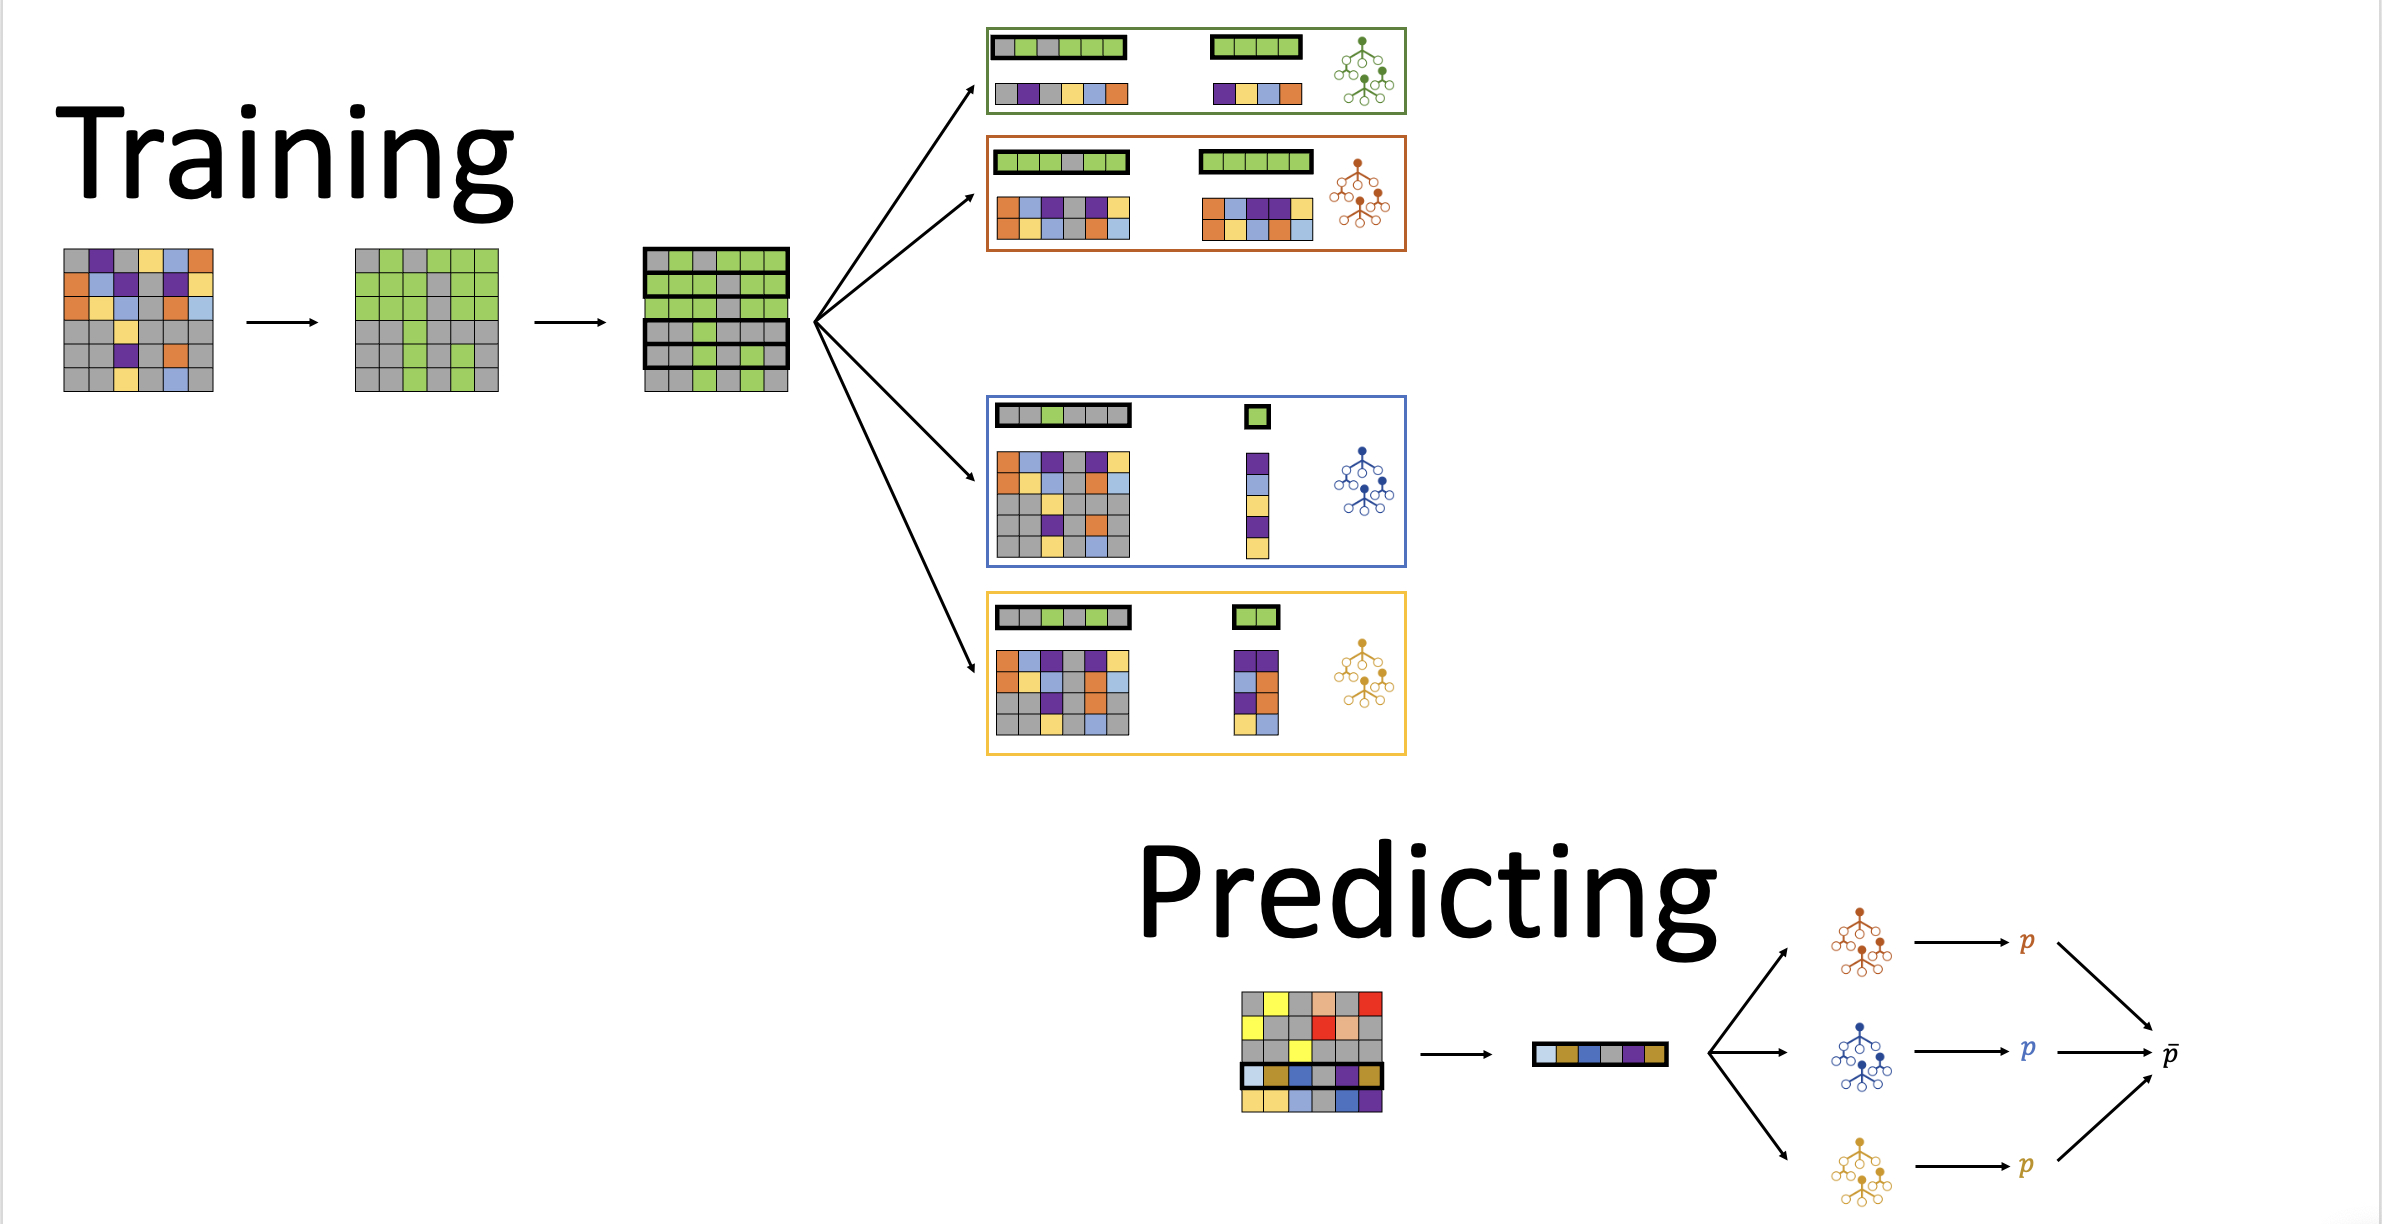

###**Figure 2.  Venn diagrams of protein overlap across data sources.**
>   ***Report totals? (not necessarily including overlaps, but perhaps in sup tbl)***

>   ***Use arrows to explicitly associate the top diagrams to the overlapping bottom sets?***

>   ***Any clearer, more succinct way to organize image?***

vennDiagram_namesListed.svg

In [ ]:
dataSrc_protsDir = workDir + 'featureData/fullSet_proteinOrigins.pkl'
dataSrc_prots = pickle.load(open(dataSrc_protsDir, 'rb'))

dataSrc_prots['association'] = dataSrc_prots.pop('pairLevel')
dataSrc_prots['expression'] = dataSrc_prots.pop('proteinLevel')

dataSrc_prots['assc+exp'] = dataSrc_prots.pop('pair+proteinLevel')
dataSrc_prots['assc+exp_geneIDs_proteinCoding'] = \
  dataSrc_prots.pop('pair+proteinLevel_geneIDs_proteinCoding')

for k, v in dataSrc_prots.items():
  print(k, len(v))

huMAP1 13276
huMAP2 15554
BioPlex3 15094
FANTOM5 17352
HPA 11018
NCI-60 22728
Uhlén 18203
SCBC 11643
gTEX 18328
association 17132
expression 23830
assc+exp 24443
assc+exp_geneIDs_proteinCoding 19057


In [ ]:
asscSrcs = ['huMAP1', 'huMAP2', 'BioPlex3']
protsAssc = set().union(*[set(dataSrc_prots[src]) for src in asscSrcs])
print(len(protsAssc))

exprSrcs = ['NCI-60', 'FANTOM5', 'gTEX', 'HPA', 'Uhlén', 'SCBC']
protsExpr = set().union(*[set(dataSrc_prots[src]) for src in exprSrcs])
print(len(protsExpr))

print(len(protsAssc.union(protsExpr)))

17132

In [ ]:
pairsFeatmat_exp = operations.generatePairs(dataSrc_prots['expression'])
print(len(pairsFeatmat_exp))

pairsFeatmat_assc = \
  set().union(*[set(featmatsSource[src].pairsFrozen.tolist())
    for src in asscSrcs])
print(len(pairsFeatmat_assc))

print(len(pairsFeatmat_assc.union(pairsFeatmat_exp)))

283922535
19398878
284083125


In [ ]:
featmatBioplex3_dir = \
  refDir + 'BioPlex3/BioPlex_BaitPreyPairs_noFilters_293T_10K_Dec_2019.tsv'
featmatHumap2_dir = refDir + 'huMAP2/humap2_feature_matrix_20200820.featmat.gz'
featmatHumap1_dir = refDir + 'huMAP1/feature_matrix.txt.gz'
featmatDirs = [featmatBioplex3_dir, featmatHumap2_dir, featmatHumap1_dir]

featmatsSource_cols = \
  [['bait_geneid', 'gene_id'], ['id1', 'id2'], ['geneid1', 'geneid2']]
featmatsSource = \
  {k.split('/')[-2]:
    pd.read_csv(k, sep=None, engine='python', usecols=cols, dtype='str')
    for k, cols in zip(featmatDirs, featmatsSource_cols)}
featmatsSource = \
  {k: v.rename(columns=dict(zip(v.columns.tolist(), ['id1', 'id2'])))
    for k, v in featmatsSource.items()}
featmatsSource = \
  {k: v.dropna() for k, v in featmatsSource.items()}

#prob makes the prev step redundant
featmatsSource = \
  {k: v.loc[v.id1.str.isnumeric() & v.id2.str.isnumeric()]
    for k, v in featmatsSource.items()}

featmatsSource = \
  {k: operations.freezePairs(v, pool=True) for k, v in featmatsSource.items()}

In [ ]:
#confirm that the set difference of exp from assc is sufficiently small to
#justify relationship in image
print(
    len(pairsFeatmat_assc.difference(pairsFeatmat_exp))/len(pairsFeatmat_assc))

0.008278313828253366


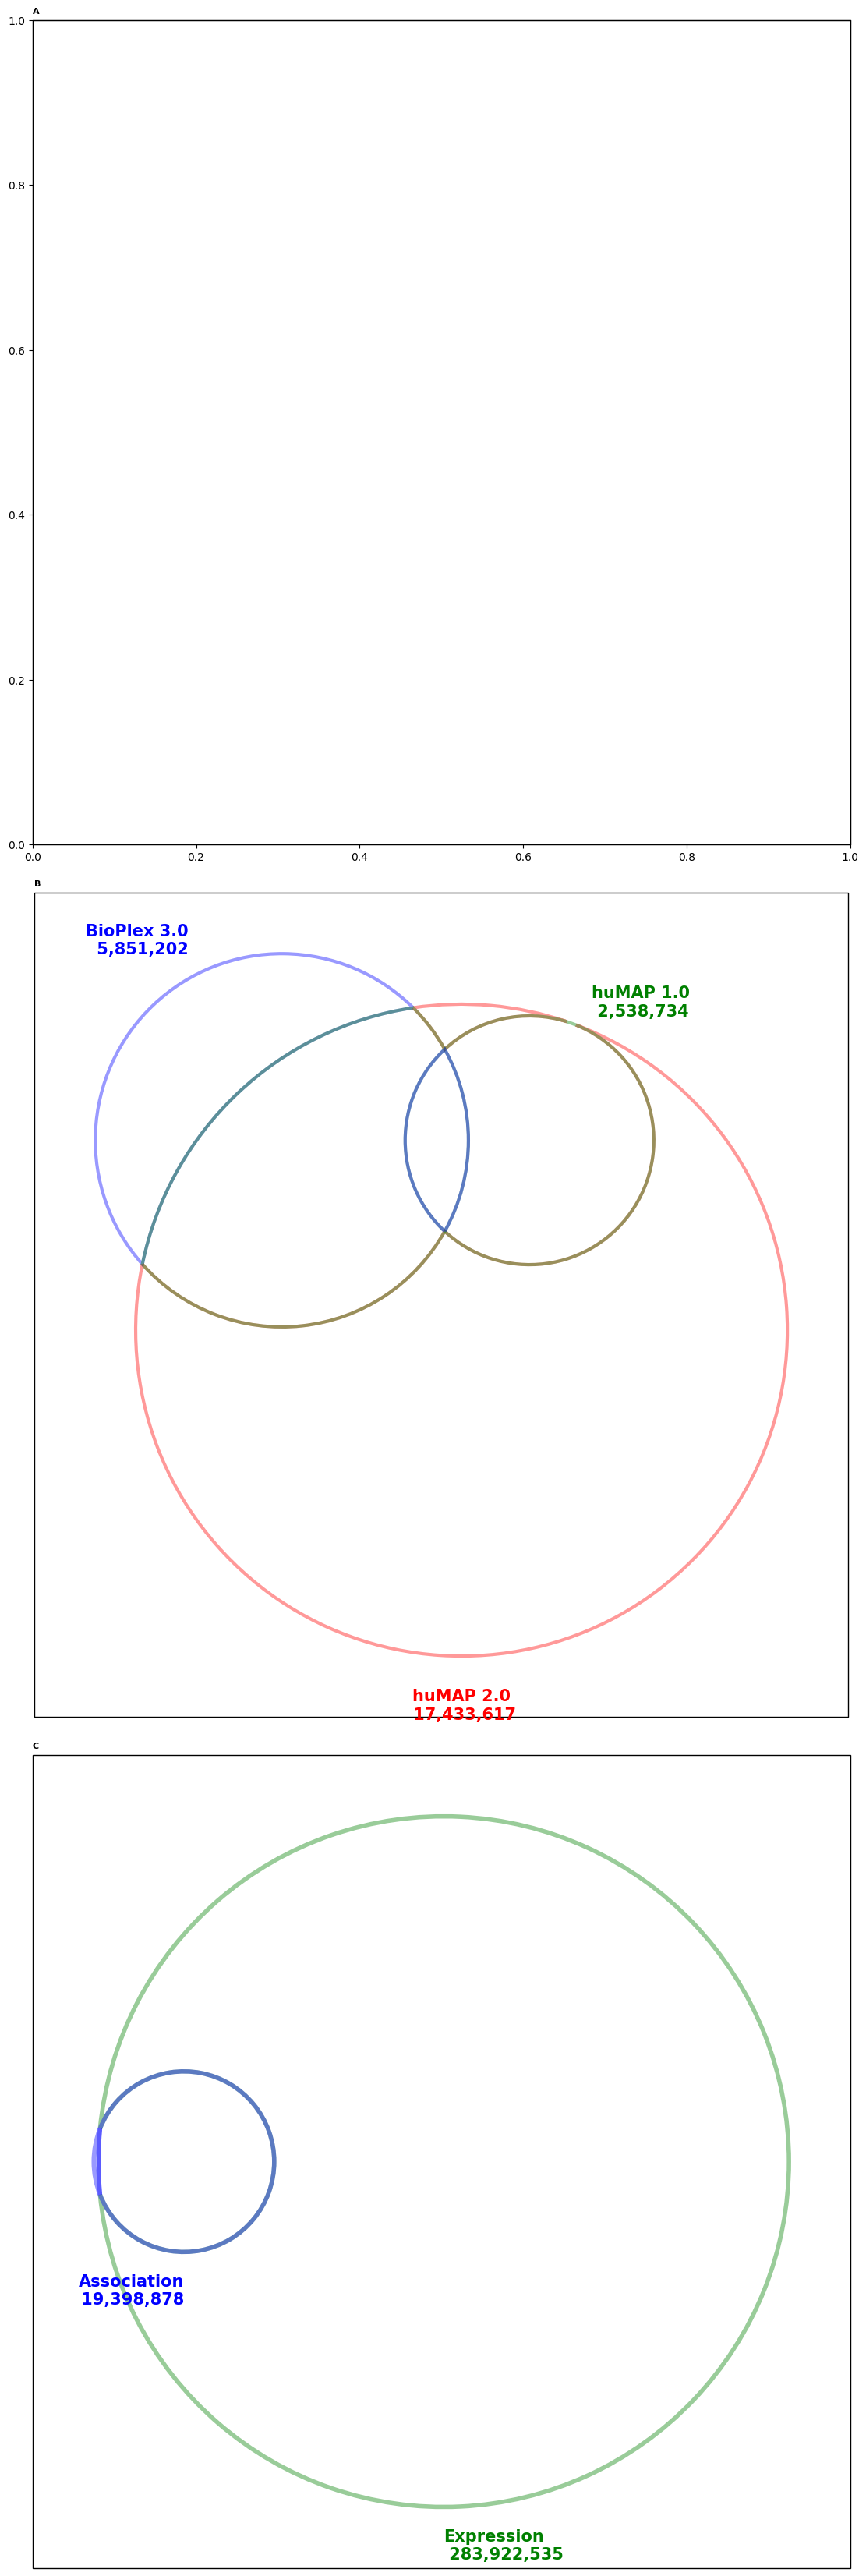

In [ ]:
f, axs = plt.subplots(3, 1, figsize=(11, 33), constrained_layout=True)
#remove fills


##patches ~ distinct item "regions"

'''
vdPanel1 = \
  venn2(
      [pairsFeatmat_assc, pairsFeatmat_exp],
       ('Association\n {:,}'.format(len(pairsFeatmat_assc)),
        'Expression\n {:,}'.format(len(pairsFeatmat_exp))), ax=axs[0])
for p, l, c in zip(vdPanel1.patches, vdPanel1.subset_labels, pal):
  if p:
    p.set_fill(False)
    p.set_linewidth(4)
    p.set_edgecolor(c)
    p.set_antialiased(True)
    l.set_visible(False)
for l, c in zip(vdPanel1.set_labels, ['b', 'g']):
  l.set_fontsize(15)
  l.set_fontweight('bold')
  l.set_color(c)
'''

pal = ['b', None, None, 'r', 'g', 'g', 'b']
vdPanel2 = venn3(
    [set(featmatsSource['BioPlex3'].pairsFrozen.tolist()),
     set(featmatsSource['huMAP1'].pairsFrozen.tolist()),
     set(featmatsSource['huMAP2'].pairsFrozen.tolist())],
      ('BioPlex 3.0\n {:,}'.format(
          len(featmatsSource['BioPlex3'].pairsFrozen.tolist())),
       'huMAP 1.0\n {:,}'.format(
          len(featmatsSource['huMAP1'].pairsFrozen.tolist())),
       'huMAP 2.0\n {:,}'.format(
          len(featmatsSource['huMAP2'].pairsFrozen.tolist()))),
      ax=axs[1])

###7 regions max for 3 sets of potentially overlapping objects (A, B, C)
###library returns regions in following order (Abc, aBc, ABc, abC, AbC, aBC, ABC)
for p, l, c in zip(vdPanel2.patches, vdPanel2.subset_labels, pal):
  if p:
    p.set_fill(False)
    p.set_linewidth(3)
    p.set_edgecolor(c)
    p.set_antialiased(True)
    l.set_visible(False)
for l, c in zip(vdPanel2.set_labels, ['b', 'g', 'r']):
  l.set_fontsize(15)
  l.set_fontweight('bold')
  l.set_color(c)

###3 regions max for 2 sets of potentially overlapping objects (A, B)
vdPanel3 = \
  venn2(
      [pairsFeatmat_assc, pairsFeatmat_exp],
       ('Association\n {:,}'.format(len(pairsFeatmat_assc)),
        'Expression\n {:,}'.format(len(pairsFeatmat_exp))), ax=axs[2])
pal = ['b', 'g', 'b']
for p, l, c in zip(vdPanel3.patches, vdPanel3.subset_labels, pal):
  if p:
    p.set_fill(False)
    p.set_linewidth(4)
    p.set_edgecolor(c)
    p.set_antialiased(True)
    l.set_visible(False)
for l, c in zip(vdPanel3.set_labels, ['b', 'g']):
  l.set_fontsize(15)
  l.set_fontweight('bold')
  l.set_color(c)


# Iterate through each subplot
for ax, title in zip(axs, ['A', 'B', 'C']):
  rect = \
    patches.Rectangle((0, 0), 1, 1,
                      linewidth=1, edgecolor='black', facecolor='none',
                      transform=ax.transAxes, clip_on=False)
  ax.add_patch(rect)
  ax.set_title(title, loc='left', fontsize=8, fontweight='bold')
plt.show()

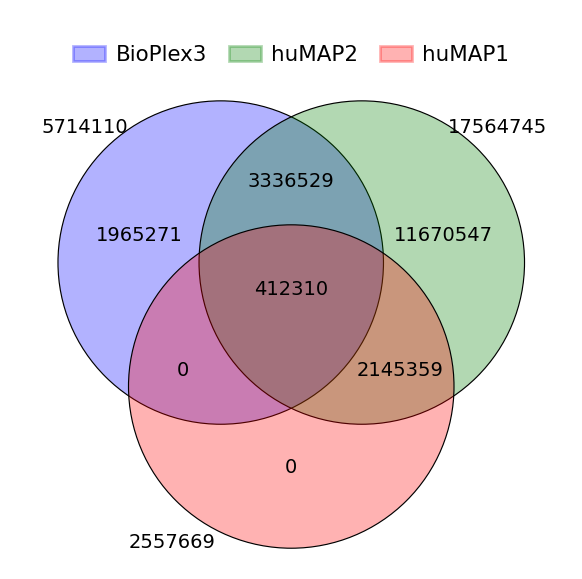

In [ ]:
#areas don't reflect proportions sufficiently
venny4py(
    sets={k: set(v.pairsFrozen.tolist()) for k, v in featmatsSource.items()})

###**Figure 3. Performance comparison between predictors of pairwise protein interactions.  This figure shows the precision, recall and area under the curve (AUC) of our proposed method compared against previously published approaches over various pairsets: (A) the original set [29], (B) the orignal set expanded in [30], and (C) the full set of protein pairs.**

In [ ]:
protDir = workDir_ph1 + 'proteinComplexes/'
manuscriptDir = workDir_elcfs + 'manuscript/'

a)  Drew 2017 pairs’ set
> *ELCFS achieves superior performance from generating correlative features from SCBC data **without** edge cases (e.g., when either one or both proteins are missing)*



In [ ]:
fig2a_labels = \
  ['SVM KD17',
   'RF LM',
   'SVM KD21',
   'ELCFS (D17)', 'ELCFS (D17+LM)', 'ELCFS (D17+LM+AF)',
   'ELCFS (D17+LM+SCBC)', 'ELCFS (D17+LM+AF+SCBC)']
fig2a_paths = \
  [protDir + 'Lugo-Martinez/drew_BCB_features_all_model_cv_predictions_rf_' +
   '400_prc-75.txt',
   protDir + 'Lugo-Martinez/lugo-martinez_etal_BCB_features_all_model_cv' +
   '_predictions_rf_400_prc-40.txt',
   protDir + 'ppiHumap2_updateHumap1_labeled_origPairs_prc.txt',
   manuscriptDir + 'partitionModel_drew_5CV_prr.csv',
   manuscriptDir + 'partitionModel_drew+LM_5CV.csv',
   manuscriptDir + 'partitionModel_drew+LM+New_5CV.csv',
   manuscriptDir + 'partitionModel_drew+LM+SCBC_5CV.csv',
   manuscriptDir + 'partitionModel_drew+LM+New+SCBC_5CV.csv']
fig2a = dict(zip(fig2a_labels, fig2a_paths))

fig2a_prr = {key: np.loadtxt(val, delimiter='\t') for key, val in fig2a.items()}
fig2a_auc = {key: auc(val[:, 0], val[:, 1]) for key, val in fig2a_prr.items()}

b)  Expanded pairs' set

> *ELCFS achieves superior performance from generating correlative features from SCBC data **with** edge cases (e.g., when either one or both proteins are missing)*

In [ ]:
fig2b_labels = \
  ['RF LM', 'ELCFS (D17+LM)', 'ELCFS (D17+LM+AF)',
   'ELCFS (D17+LM+SCBC)', 'ELCFS (D17+LM+AF+SCBC)']
fig2b_paths = \
  [manuscriptDir + 'lugo-martinez2019_HPA-NCI60-expandedPairs_5CV.txt',
   manuscriptDir + 'partitionModel_drew+LM_HPA-NCI60-expandedPairs_5CV.txt',
   manuscriptDir + 'partitionModel_KD_LM_FGK.txt',
   manuscriptDir + 'partitionModel_KD+LM+SCBC_noSCBCnull.csv',
   manuscriptDir +
   'partitionModel_KD+LM+FGK+SCBC_cellSpecific_nci60Feats_noSCBCnulls.csv']
fig2b = dict(zip(fig2b_labels, fig2b_paths))

fig2b_prr = {key: np.loadtxt(val, delimiter='\t')
for key, val in fig2b.items()}
fig2b_auc = \
  {key: sklearn.metrics.auc(val[:, 0], val[:, 1])
  for key, val in fig2b_prr.items()}

c)  Pairs overlapping between both full sets of STRING and ELCFS predictions

In [ ]:
fig2c_labels = ['ELCFS (D17+LM+AF+SCBC)', 'STRING (v12)']
fig2c_paths = \
  [manuscriptDir +
   'partitionModel_KD+LM+FGK+SCBC_noSCBCnull_pairsOverlap-STRING+Fullset.csv',
   manuscriptDir + 'scoredPairs_STRING_pairsOverlap-STRING+Fullset.csv']
fig2c = dict(zip(fig2c_labels, fig2c_paths))

fig2c_prr = {key: np.loadtxt(val, delimiter='\t') for key, val in fig2c.items()}
fig2c_auc = {key: auc(val[:, 0], val[:, 1]) for key, val in fig2c_prr.items()}

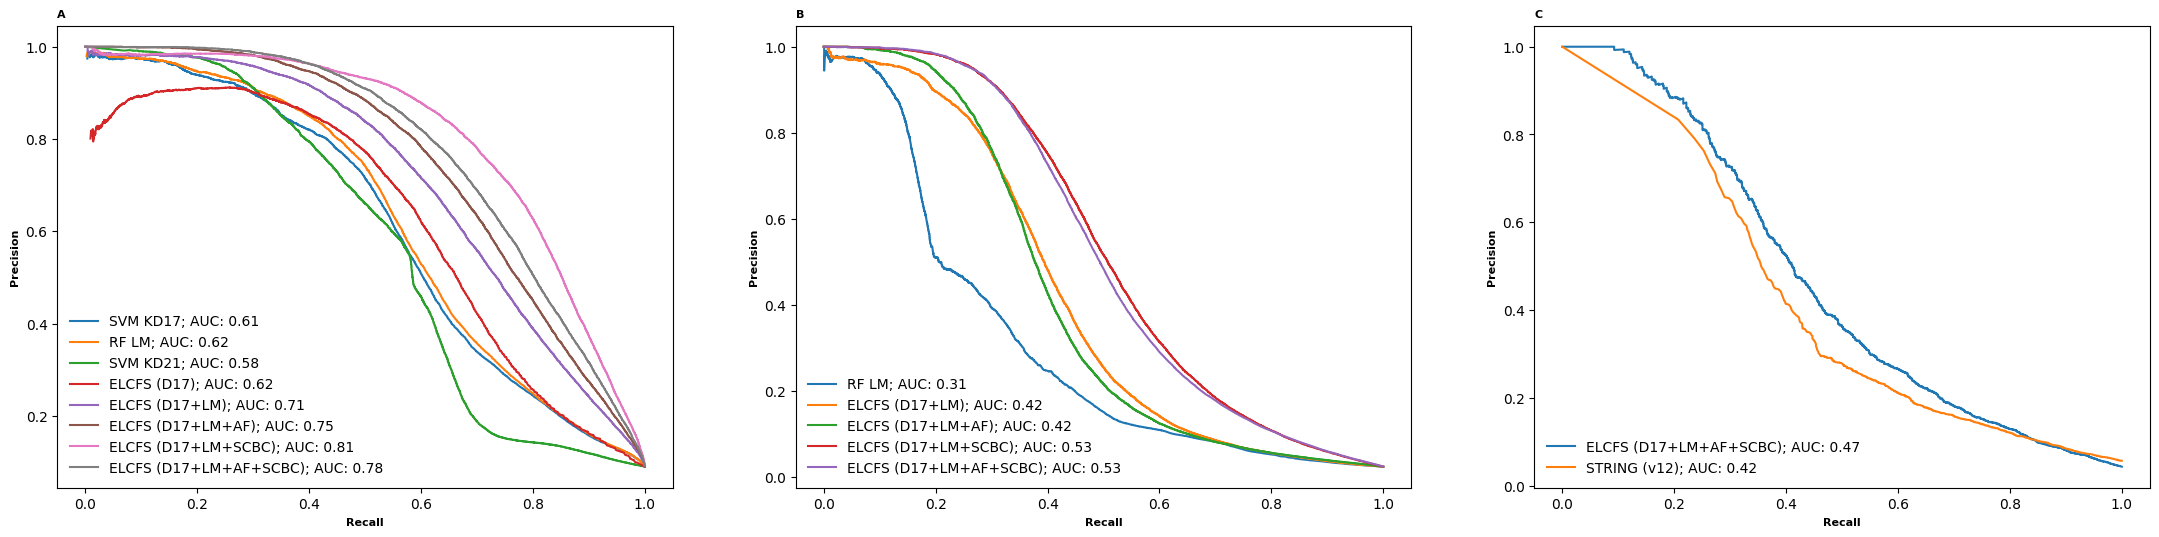

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(27, 6))

##
##A: D17 pair set
for key, val in fig2a_prr.items():
  axs[0].plot(val[:, 0], val[:, 1],
              label=key+'; AUC: {:.2f}'.format(fig2a_auc[key]))
axs[0].legend(loc='lower left', frameon=False)
#axs[0].set_title('Original pairs (Drew 2017)', fontsize=8, fontweight='bold')
axs[0].set_title('A', loc='left', fontsize=8, fontweight='bold')
axs[0].set_xlabel('Recall', fontsize=8, fontweight='bold')
axs[0].set_ylabel('Precision', fontsize=8, fontweight='bold')

##
##B: LM19 pair set
for key, val in fig2b_prr.items():
  axs[1].plot(val[:, 0], val[:, 1],
              label=key+'; AUC: {:.2f}'.format(fig2b_auc[key]))
axs[1].legend(loc='lower left', frameon=False)
#axs[1].set_title('Expanded pairs (Lugo-Martinez 2019)', fontsize=8, fontweight='bold')
axs[1].set_title('B', loc='left', fontsize=8, fontweight='bold')
axs[1].set_xlabel('Recall', fontsize=8, fontweight='bold')
axs[1].set_ylabel('Precision', fontsize=8, fontweight='bold')

##
##C: PS24 pair set
for key, val in fig2c_prr.items():
  axs[2].plot(val[:, 0], val[:, 1],
              label=key+'; AUC: {:.2f}'.format(fig2c_auc[key]))
axs[2].legend(loc='lower left', frameon=False)
#axs[2].set_title('Overlapping STRING and Full Set pairs', fontsize=8, fontweight='bold')
axs[2].set_title('C', loc='left', fontsize=8, fontweight='bold')
axs[2].set_xlabel('Recall', fontsize=8, fontweight='bold')
axs[2].set_ylabel('Precision', fontsize=8, fontweight='bold')

plt.savefig(graphicsDir + 'figure_2.svg')
plt.savefig(graphicsDir + 'figure_2.png', dpi=600)

###***CHECK---Optimum performance for pairwise-interaction classifiers over multiple pairsets.***

*   *Plot scores for us and them (expect nonlinear relationship)*
*   *Clean up table, e.g., words, threshold*

In [ ]:
elcfsPh2_fullsetDir = workDir_ph1 + 'modelsPerformance/'
elcfsPh2_fullset = \
  elcfsPh2_fullsetDir + \
  'modelsPerformance_fullPairset_KD+LM+FGK+SCBC-5CV/probsPos-weighted.tsv'
#cmpStudies.generateStats_eval(elcfsPh2_fullset)

###**Figure S1. Performance comparison of merged results with alternatively dominant pairwise protein interaction predictors. Predictions from each predictor are combined and results for the dominant model are used when there is overlap. This figure shows  the impact of dominant predictor selection on the quality of precision and recall over both labeled pairs a) in the union of pairs with hu.MAP 1+2, and b) in the intersection of hu.MAP 1+2 pairs.**

> ***Use A, B panel label construct throughout?  Or?***

> *The "Construct Feature Matrix" notebook is where the lists of (Drew 2017, Drew 2021, and LM 2019) gene id pairsets are created as well as the union and intersection of those pairs*

> ***Be EXPLICIT in documentation of notebook used for generating the union and intersection pairsets, re hu.MAP 1, 2, expanded pairset and full set***

> *Similarly..need to be EXPLICIT in commenting the
notebook used for combining predictions for both hu.MAP releases*

In [ ]:
#load all training pairs for the full set
pairsetsUnion = \
  pd.read_csv(setupDir + 'pairsetsUnion.tsv', sep='\t',
              dtype={'id1': 'str', 'id2': 'str'})
pairsetsUnion = operations.freezePairs(pairsetsUnion, 'id1', 'id2', pool=True)
'''
#if time is a factor..
pairsetsUnion = \
  pickle.load(open(setupDir + 'pairsetsUnion.pkl', 'rb'))
'''

In [ ]:
pairsetsIntersection = \
  pickle.load(open(setupDir + 'pairsetsIntersection.pkl', 'rb'))

In [ ]:
#load training pairs for hu.MAP 1+2
humap1p2Preds_pairsDF = \
  pd.read_csv(workDir + 'evalData/predsHumap1+2.tsv', sep='\t',
              dtype={'id1': 'str', 'id2': 'str'})
humap1p2Preds_pairsDF = \
  operations.freezePairs(humap1p2Preds_pairsDF, 'id1', 'id2', pool=True)
#humap1p2Preds_pairsDF.rename(columns={'score': 'hu.MAP1+2'})

pooling...


100%|██████████| 17529061/17529061 [12:13<00:00, 23881.74it/s]


In [ ]:
#expanded pairset predictions
elcfsOld_filename = workDir_ph1 + 'modelPerformance/' + \
  'modelsPerformance_integratedPairs_KD+LM+FGK+SCBC_cellSpecific_nci60Feats' + \
  '_noSCBCnulls-5CV/resultsConcatenated/probsPos-weighted_wlabeledPairs' + \
  '_reportingCelllines-H322+MCF7+U251.pkl'
elcfsOld = pickle.load(open(elcfsOld_filename, 'rb'))
elcfsOld = elcfsOld.loc[:, ['pairsFrozen', 'label', 'probsPos_mean']].copy()
elcfsOld.rename(columns={'probsPos_mean': 'prob'}, inplace=True)
'''
elcfsOld.rename(
    columns={'idi': 'id1', 'idii': 'id2', 'probsPos_mean': 'prob'}, inplace=True)
'''
elcfsOld

,pairsFrozen,id1,id2,label,probsPos_h322,probsPos_mcf7,probsPos_u251,prob
0,"(54534, 5520)",5520,54534,0,0.006875,0.007500,0.007187,0.007188
1,"(79042, 7329)",7329,79042,0,0.004375,0.004688,0.004376,0.004479
2,"(10465, 5584)",5584,10465,0,0.000625,0.000625,0.001250,0.000834
3,"(112950, 65003)",112950,65003,0,0.087825,0.088130,0.088138,0.088031
4,"(6749, 8668)",8668,6749,0,0.002501,0.003125,0.002813,0.002813
...,...,...,...,...,...,...,...,...
1037902,"(6176, 3696)",6176,3696,0,0.001250,0.001563,0.000938,0.001250
1037903,"(3692, 6193)",3692,6193,0,0.047821,0.044384,0.044384,0.045530
1037904,"(4659, 8663)",8663,4659,0,0.007187,0.007813,0.006875,0.007292
1037905,"(54892, 23429)",54892,23429,0,0.006875,0.015312,0.014064,0.012084


In [ ]:
#full set of pairs with ELCFS predictions
elcfsFilename = workDir_ph1 + 'modelPerformance/' + \
  'modelsPerformance_fullPairset_KD+LM+FGK+SCBC-5CV/probsPos-weighted.tsv'
elcfs = pd.read_csv(elcfsFilename, sep='\t', dtype={'id1': 'str', 'id2': 'str'})
elcfs = operations.freezePairs(elcfs, 'id1', 'id2', pool=True)
elcfs.rename(columns={'idsFrozen': 'pairsFrozen', 'labels': 'label',
                      'probsPos_mean': 'prob'}, inplace=True)
elcfs

pooling...


100%|██████████| 9514727/9514727 [06:33<00:00, 24189.46it/s]


,id1,id2,pairsFrozen,prob
0,381,5137,"(381, 5137)",0.155
1,381,5062,"(381, 5062)",0.197
2,381,9609,"(381, 9609)",0.222
3,381,2889,"(381, 2889)",0.181
4,381,23527,"(381, 23527)",0.767
...,...,...,...,...
9514722,91833,10014,"(91833, 10014)",0.194
9514723,91833,8841,"(91833, 8841)",0.196
9514724,91833,5533,"(91833, 5533)",0.156
9514725,91833,8342,"(91833, 8342)",0.152


In [ ]:
probPreds_cellSpec_concat_filename = workDir_ph1 + 'modelPerformance/' + \
  'modelsPerformance_fullPairset_KD+LM+FGK+SCBC-5CV/elcfsPreds_fullSet.pkl'
probPreds_cellSpec_concat = \
  pickle.load(open(probPreds_cellSpec_concat_filename, 'rb'))
probPreds_cellSpec_concat

,id1,id2,pairsFrozen,h322,mcf7,u251,nonspecific
0,1,10005,"(1, 10005)",0.240000,0.240000,0.240000,0.240000
1,1,10006,"(1, 10006)",0.240000,0.240000,0.240000,0.240000
2,1,10007,"(1, 10007)",0.240000,0.240000,0.015000,0.165000
3,1,10015,"(1, 10015)",0.240000,0.240000,0.240000,0.240000
4,1,10016,"(1, 10016)",0.240000,0.240000,0.240000,0.240000
...,...,...,...,...,...,...,...
97602953,126626,1982,"(1982, 126626)",0.036249,0.032810,0.035936,0.030317
97602954,23193,3192,"(3192, 23193)",0.016877,0.017815,0.018128,0.001562
97602955,23193,3146,"(3146, 23193)",0.000938,0.002188,0.000938,0.003750
97602956,7756,57128,"(7756, 57128)",0.003438,0.004688,0.003125,0.006250


In [ ]:
#merge all predictors using outer join
'''
predsSrc_multi = \
  {'hu.MAP1+2':
   humap1p2Preds_pairsDF.rename(columns={'score': 'hu.MAP1+2'}),
   'ELCFS (phase 1)':
   elcfsOld[['pairsFrozen', 'prob']].rename(columns={'prob': 'ELCFS (phase 1)'}),
   'ELCFS (phase 2)':
   elcfs[['pairsFrozen', 'prob']].rename(columns={'prob': 'ELCFS (phase 2)'})}
'''

predsSrc_multiMerge = \
  reduce(lambda left, right:
         pd.merge(left, right, how='outer'), predsSrc_multi.values())
predsSrc_multiMerge_labeled = predsSrc_multiMerge.merge(pairsetsUnion)

In [ ]:
#temp cell (in the event of runtime failure or unsuccessfully saved session)
tbl3p4Dir = workDir + 'google_colab_notebooks/notebookQC/'
pickle.dump(humap1p2Preds_pairsDF,
            open(tbl3p4Dir + 'humap1p2Preds_pairsDF.pkl', 'wb'))
pickle.dump(predsSrc_multi,
            open(tbl3p4Dir + 'predsSrc_multi.pkl', 'wb'))

a)  Union of Drew 2017/2021 with full pairset

In [ ]:
dfPairs_union, pairsUnion_humapPrr, pairsUnion_elcfsPrr = \
  modelEvaluating.makePrR_varDom(
      predsSrc_multiMerge_labeled.rename(columns={'ELCFS (phase 2)': 'ELCFS'}),
      studies=['hu.MAP1+2', 'ELCFS'],
      return_prr=True)

b)  Intersection of Drew 2017/2021 with expanded pairset

In [ ]:
dfPairs_overlap, pairsOvelap_humapPrr, pairsOverlap_elcfsPrr = \
  modelEvaluating.makePrR_varDom(
      predsSrc_multiMerge_labeled.loc[
          predsSrc_multiMerge_labeled.pairsFrozen.isin(
              pairsetsIntersection)].rename(columns={'ELCFS (phase 2)': 'ELCFS'}),
      studies=['hu.MAP1+2', 'ELCFS'],
      return_prr=True)

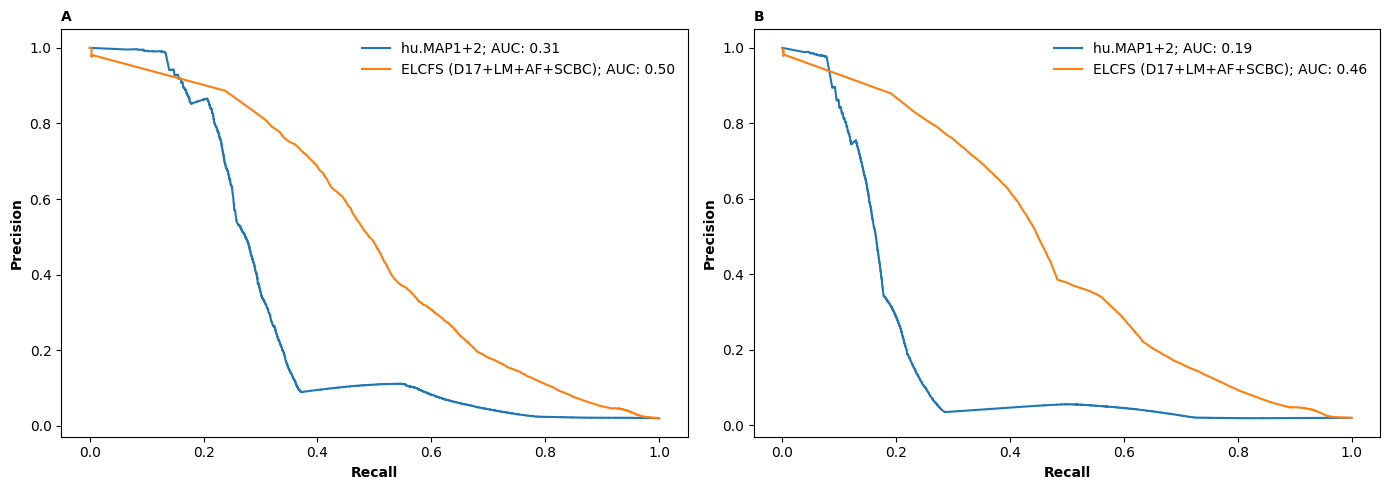

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(14, 5), tight_layout=True)

##
##A: Intersection
axs[0].plot(pairsOvelap_humapPrr[1], pairsOvelap_humapPrr[0],
            label='hu.MAP1+2; AUC: {:.2f}'.format(
                auc(pairsOvelap_humapPrr[1], pairsOvelap_humapPrr[0])))
axs[0].plot(pairsOverlap_elcfsPrr[1], pairsOverlap_elcfsPrr[0],
            label='ELCFS (D17+LM+AF+SCBC); AUC: {:.2f}'.format(auc(
                pairsOverlap_elcfsPrr[1], pairsOverlap_elcfsPrr[0])))
axs[0].legend(loc='upper right', frameon=False)
axs[0].set_title('A', loc='left', fontsize=10, fontweight='bold')
axs[0].set_ylabel('Precision', fontsize=10, fontweight='bold')
axs[0].set_xlabel('Recall', fontsize=10, fontweight='bold')

##
##B: Union
axs[1].plot(pairsUnion_humapPrr[1], pairsUnion_humapPrr[0],
            label='hu.MAP1+2; AUC: {:.2f}'.format(
                auc(pairsUnion_humapPrr[1], pairsUnion_humapPrr[0])))
axs[1].plot(pairsUnion_elcfsPrr[1], pairsUnion_elcfsPrr[0],
            label='ELCFS (D17+LM+AF+SCBC); AUC: {:.2f}'.format(auc(
                pairsUnion_elcfsPrr[1], pairsUnion_elcfsPrr[0])))
axs[1].legend(loc='upper right', frameon=False)
axs[1].set_title('B', loc='left', fontsize=10, fontweight='bold')
axs[1].set_ylabel('Precision', fontsize=10, fontweight='bold')
axs[1].set_xlabel('Recall', fontsize=10, fontweight='bold')

plt.savefig(graphicsDir + 'figure_S1.svg')
plt.savefig(graphicsDir + 'figure_S1.png', dpi=600)

###**Figure 4. Interaction predictors' precision-recall over STRING (v12). Performance comparison between predictors of pairwise protein interactions using labels derived from STRING (v12) confidence thresholds for ground truth.  This figure shows the precision, recall and area under the curve (AUC) of our proposed method compared against previously published approaches over various pairsets, all within the intersection of STRING (v12) pairs: (A) the full set of protein pairs, (B) the full set overlapping with hu.MAP 1+2, and (C) the full set of protein pairs overlapping with hu.MAP 1+2 and Lugo-Martinez et al., 2019.**

> *Retain subsequent 2 code chunks until confident with library func integration*

> Fix BAD LOGIC ✔️
>>***Find evidence the result is correct***

In [ ]:
#grab set of protein pairs for STRINGv12
print('Total STRINGv12 pair predictions: {0}'.format(
    len(cmpStudies.stringPreds)))

Total STRINGv12 pair predictions: 6881445


In [ ]:
#grab CORUM+
corumPairs_pos = pairsetsUnion.loc[pairsetsUnion.label==1, 'pairsFrozen']
print('CORUM pairs\' dimensions: {0}'.format(pairsetsUnion.shape))
print('Total CORUM+ pairs: {0}'.format(len(corumPairs_pos)))

In [ ]:
#intersect with full set of protein pairs
#remove CORUM+ (Do HERE in cell)
elcfs_stringOverlap = \
  cmpStudies.stringPreds.rename(columns={'prob': 'STRINGv12'}).merge(
      elcfs.loc[~elcfs.pairsFrozen.isin(
          corumPairs_pos)].rename(columns={'prob': 'ELCFS'}), on='pairsFrozen')
print('Total ELCFS full set pair predictions: 162758569')
print('Total ELCFS full set pair predictions minus CORUM+ pairs, ' + \
      'intersected with STRINGv12: {0}'.format(len(
          elcfs_stringOverlap)))
#print(elcfs_stringOverlap.shape)
#print(elcfs_stringOverlap.head())

In [ ]:
#remove hu.MAP1+2 (carrying over)
elcfs_stringOverlap_humap12Overlap = \
  elcfs_stringOverlap.merge(cmpStudies.predsHumap1p2)
print('Total hu.MAP 1+2 pair predictions: {0}'.format(
    len(cmpStudies.predsHumap1p2)))
print('Total ELCFS full set pair predictions minus CORUM+ pairs, ' + \
      'intersected with STRINGv12, ' + \
      'overlapping with hu.MAP 1+2 predictions: {0}'.format(len(
          elcfs_stringOverlap_humap12Overlap)))
#print(cmpStudies.predsHumap1p2.head())

In [ ]:
#remove RF LM (carrying over)
elcfs_stringOverlap_humap12Overlap_rflmOverlap = \
  elcfs_stringOverlap_humap12Overlap.merge(cmpStudies.bcb19Pairs_feat.drop(
      columns=['id1', 'id2']).rename(columns={'prob': 'RF LM'}))
print('Total RF LM predictions: {0}'.format(len(cmpStudies.bcb19Pairs_feat)))
print('Total ELCFS full set pair predictions minus CORUM+ pairs, ' + \
      'intersected with STRINGv12, ' + \
      'overlapping with both hu.MAP 1+2 and LM 2019 predictions: {0}'.format(
          len(elcfs_stringOverlap_humap12Overlap_rflmOverlap)))
#print(cmpStudies.bcb19Pairs_feat.head())
#print(elcfs_stringOverlap_humap12Overlap_rflmOverlap.head())

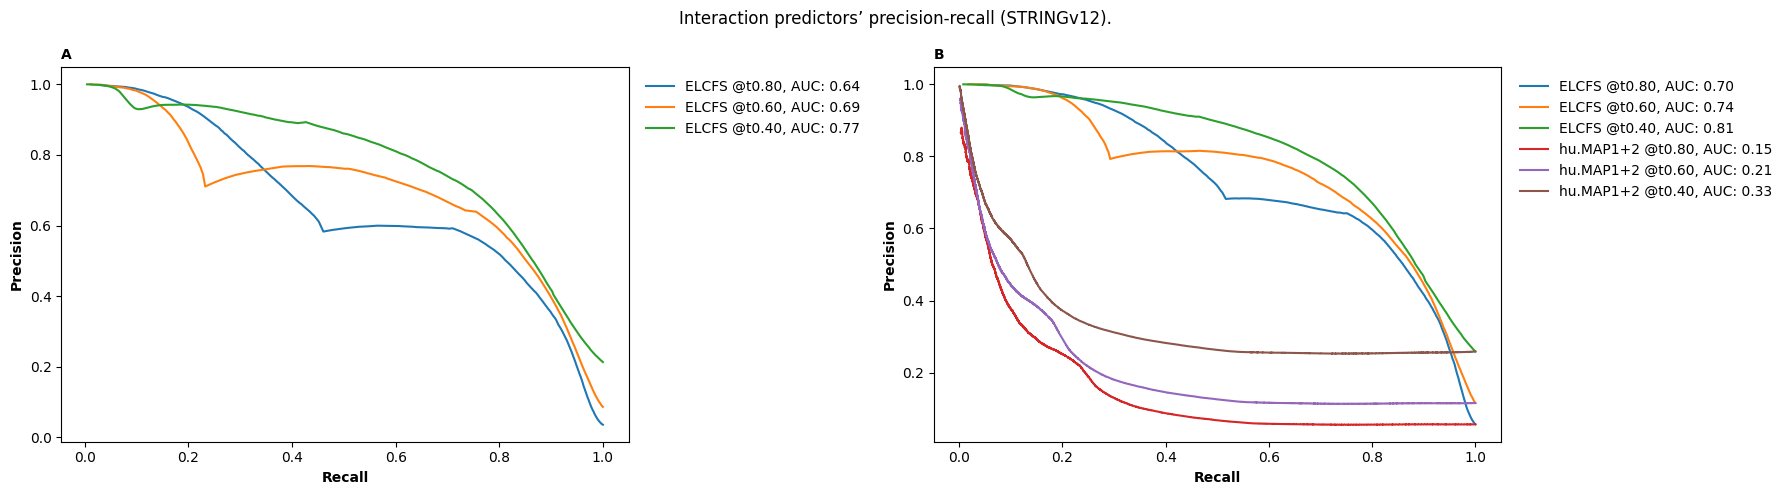

In [ ]:
#generate Pr-R by using ELCFS probabilities and deriving labels from STRING by
#thresholding its assigned confidence
f, axs = plt.subplots(1, 2, figsize=(18, 5), tight_layout=True)
plt.suptitle('Interaction predictors’ precision-recall (STRINGv12).')

#do panel 1
##A: Full set pairs
axs[0].set_title('A', loc='left', fontsize=10, fontweight='bold')
for t in np.linspace(0.8, 0.4, 3):
  labels = [1 if val >= t else 0 for val in elcfs_stringOverlap.STRINGv12]
  p, r, _ = precision_recall_curve(labels, elcfs_stringOverlap.ELCFS)
  prrAUC = auc(r[:-1], p[:-1])
  axs[0].plot(r[:-1], p[:-1],
              label='ELCFS @t{:.2f}'.format(t) + ', AUC: {:.2f}'.format(prrAUC))

axs[0].legend(bbox_to_anchor=(1.43, 1.0), loc='upper right', frameon=False)
axs[0].set_ylabel('Precision', fontsize=10, fontweight='bold')
axs[0].set_xlabel('Recall', fontsize=10, fontweight='bold')

#do panel 2 (using scores from ELCFS and hu.MAP1+2)
##B: Full set pairs overlapping with hu.MAP 1+2
axs[1].set_title('B', loc='left', fontsize=10, fontweight='bold')
for col in ['ELCFS', 'hu.MAP1+2']:
  for t in np.linspace(0.8, 0.4, 3):
    labels = \
      [1 if val >= t else 0
        for val in elcfs_stringOverlap_humap12Overlap.STRINGv12]
    p, r, _ = \
      precision_recall_curve(labels, elcfs_stringOverlap_humap12Overlap[col])
    prrAUC = auc(r[:-1], p[:-1])
    axs[1].plot(
        r[:-1], p[:-1],
        label=col + ' @t{:.2f}'.format(t) + ', AUC: {:.2f}'.format(prrAUC))

axs[1].legend(bbox_to_anchor=(1.50, 1.0), loc='upper right', frameon=False)
axs[1].set_ylabel('Precision', fontsize=10, fontweight='bold')
axs[1].set_xlabel('Recall', fontsize=10, fontweight='bold')

#do panel 3 (using scores from all 3)
'''
panel3Title = 'Full set pairs overlapping with both hu.MAP 1+2 and LM 2019'
axs[1, 1].set_title(panel3Title, fontsize=10, fontweight='bold')
for col in ['ELCFS', 'hu.MAP1+2', 'RF LM']:
  for t in np.linspace(0.8, 0.4, 3):
    labels = \
      [1 if val >= t else 0
        for val in elcfs_stringOverlap_humap12Overlap_rflmOverlap.STRINGv12]
    p, r, _ = \
      precision_recall_curve(
          labels, elcfs_stringOverlap_humap12Overlap_rflmOverlap[col])
    prrAUC = auc(r[:-1], p[:-1])
    axs[1, 1].plot(
        r[:-1], p[:-1],
        label=col + ' @t{:.2f}'.format(t) + ', AUC: {:.2f}'.format(prrAUC))

axs[1, 1].legend(bbox_to_anchor=(1.50, 1.0), loc='upper right', frameon=False)
axs[1, 1].set_ylabel('Precision', fontsize=10, fontweight='bold')
axs[1, 1].set_xlabel('Recall', fontsize=10, fontweight='bold')
'''

plt.savefig(graphicsDir + 'figure_S2.svg')
plt.savefig(graphicsDir + 'figure_S2.png', dpi=600)

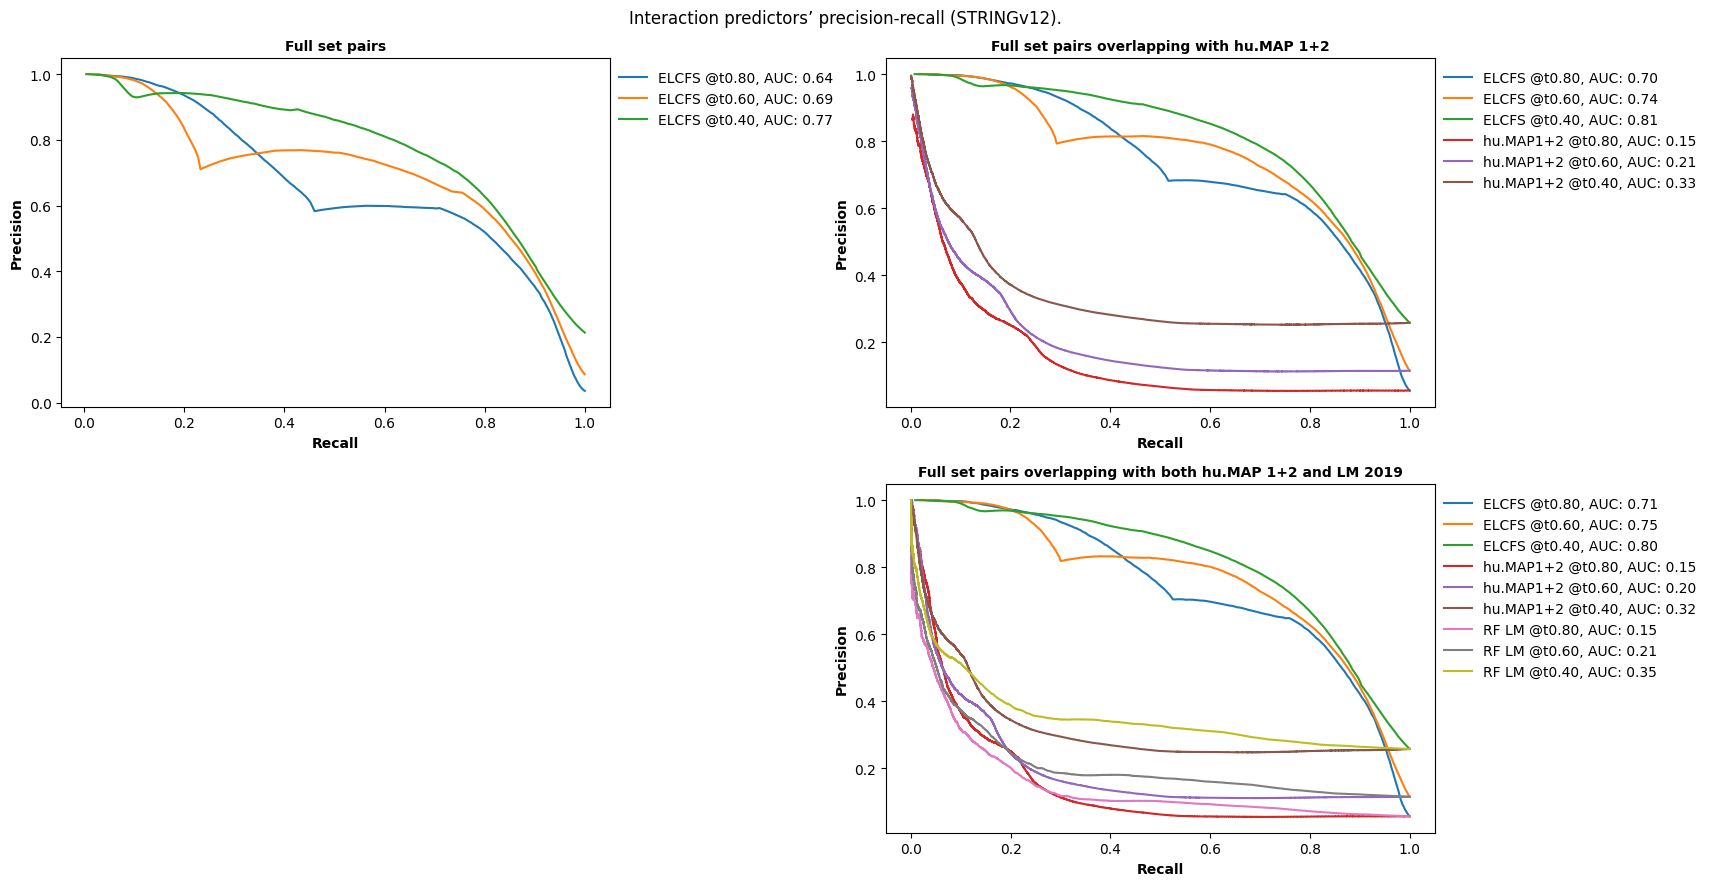

In [ ]:
#generate Pr-R by using ELCFS probabilities and deriving labels from STRING by
#thresholding its assigned confidence
f, axs = plt.subplots(2, 2, figsize=(17, 9), tight_layout=True)
plt.suptitle('Interaction predictors’ precision-recall (STRINGv12).')

#do panel 1
panel1Title = 'Full set pairs'
axs[0, 0].set_title(panel1Title, fontsize=10, fontweight='bold')
for t in np.linspace(0.8, 0.4, 3):
  labels = [1 if val >= t else 0 for val in elcfs_stringOverlap.STRINGv12]
  p, r, _ = precision_recall_curve(labels, elcfs_stringOverlap.ELCFS)
  prrAUC = auc(r[:-1], p[:-1])
  axs[0, 0].plot(r[:-1], p[:-1],
              label='ELCFS @t{:.2f}'.format(t) + ', AUC: {:.2f}'.format(prrAUC))

axs[0, 0].legend(bbox_to_anchor=(1.43, 1.0), loc='upper right', frameon=False)
axs[0, 0].set_ylabel('Precision', fontsize=10, fontweight='bold')
axs[0, 0].set_xlabel('Recall', fontsize=10, fontweight='bold')

#do panel 2 (using scores from ELCFS and hu.MAP1+2)
panel2Title = 'Full set pairs overlapping with hu.MAP 1+2'
axs[0, 1].set_title(panel2Title, fontsize=10, fontweight='bold')
for col in ['ELCFS', 'hu.MAP1+2']:
  for t in np.linspace(0.8, 0.4, 3):
    labels = \
      [1 if val >= t else 0
        for val in elcfs_stringOverlap_humap12Overlap.STRINGv12]
    p, r, _ = \
      precision_recall_curve(labels, elcfs_stringOverlap_humap12Overlap[col])
    prrAUC = auc(r[:-1], p[:-1])
    axs[0, 1].plot(
        r[:-1], p[:-1],
        label=col + ' @t{:.2f}'.format(t) + ', AUC: {:.2f}'.format(prrAUC))

axs[0, 1].legend(bbox_to_anchor=(1.50, 1.0), loc='upper right', frameon=False)
axs[0, 1].set_ylabel('Precision', fontsize=10, fontweight='bold')
axs[0, 1].set_xlabel('Recall', fontsize=10, fontweight='bold')

#do panel 3 (using scores from all 3)
panel3Title = 'Full set pairs overlapping with both hu.MAP 1+2 and LM 2019'
axs[1, 1].set_title(panel3Title, fontsize=10, fontweight='bold')
for col in ['ELCFS', 'hu.MAP1+2', 'RF LM']:
  for t in np.linspace(0.8, 0.4, 3):
    labels = \
      [1 if val >= t else 0
        for val in elcfs_stringOverlap_humap12Overlap_rflmOverlap.STRINGv12]
    p, r, _ = \
      precision_recall_curve(
          labels, elcfs_stringOverlap_humap12Overlap_rflmOverlap[col])
    prrAUC = auc(r[:-1], p[:-1])
    axs[1, 1].plot(
        r[:-1], p[:-1],
        label=col + ' @t{:.2f}'.format(t) + ', AUC: {:.2f}'.format(prrAUC))

axs[1, 1].legend(bbox_to_anchor=(1.50, 1.0), loc='upper right', frameon=False)
axs[1, 1].set_ylabel('Precision', fontsize=10, fontweight='bold')
axs[1, 1].set_xlabel('Recall', fontsize=10, fontweight='bold')

#panel 4 empty
axs[1, 1].remove()
axs[1, 0].remove()

###**Table S1.  Summary of differences between cell-line-specific interaction predictions.**

> ***Does Table S1 actually need a caption?***

In [ ]:
cellLines = set(['h322', 'mcf7', 'u251'])
cellLines_remain = \
  {line: list(cellLines.difference(set([line]))) for line in cellLines}

In [ ]:
threshold = 0.28

In [ ]:
tbl_s1 = pd.DataFrame({'cell line': sorted(cellLines)})

In [ ]:
totalCommonPreds = \
  len(probPreds_cellSpec_concat.loc[(
      (probPreds_cellSpec_concat.h322 >= threshold) &
      (probPreds_cellSpec_concat.mcf7 >= threshold) &
      (probPreds_cellSpec_concat.u251 >= threshold))])
tbl_s1.insert(1, 'total common predictions', totalCommonPreds)

In [ ]:
pairwise_combPreds = \
  [len(probPreds_cellSpec_concat.loc[
           ((probPreds_cellSpec_concat[line] >= threshold) &
            (probPreds_cellSpec_concat[
                cellLines_remain[line][0]] >= threshold) &
                 (probPreds_cellSpec_concat[
                     cellLines_remain[line][1]] < threshold))]) +
       len(probPreds_cellSpec_concat.loc[
           ((probPreds_cellSpec_concat[line] >= threshold) &
            (probPreds_cellSpec_concat[
                cellLines_remain[line][0]] < threshold) &
                 (probPreds_cellSpec_concat[
                     cellLines_remain[line][1]] >= threshold))])
   for line in sorted(cellLines)]
tbl_s1.insert(2, 'total pairwise exclusive predictions', pairwise_combPreds)

In [ ]:
totalsExcl = \
  [len(probPreds_cellSpec_concat.loc[
      ((probPreds_cellSpec_concat[line] >= threshold) &
       (probPreds_cellSpec_concat[cellLines_remain[line][0]] < threshold) &
        (probPreds_cellSpec_concat[cellLines_remain[line][1]] < threshold))])
  for line in sorted(cellLines)]
tbl_s1.insert(3, 'total cell-line exclusive predictions', totalsExcl)

In [ ]:
totalsPred = \
  [tbl_s1.loc[tbl_s1['cell line']==line, tbl_s1.columns.to_list()[1:]].values.sum()
  for line in sorted(cellLines)]
tbl_s1.insert(1, 'total predictions', totalsPred)

In [ ]:
for col in tbl_s1.columns.to_list()[1:]:
  tbl_s1[col] = tbl_s1[col].apply('{:,}'.format)
tbl_s1.style.hide()

cell line,total predictions,total common predictions,total pairwise exclusive predictions,total cell-line exclusive predictions
h322,"11,583,216","6,387,526","3,343,074","1,852,616"
mcf7,"12,855,645","6,387,526","3,669,450","2,798,669"
u251,"12,793,128","6,387,526","3,545,040","2,860,562"


h322, u251
mcf7, h322
u251, mcf7


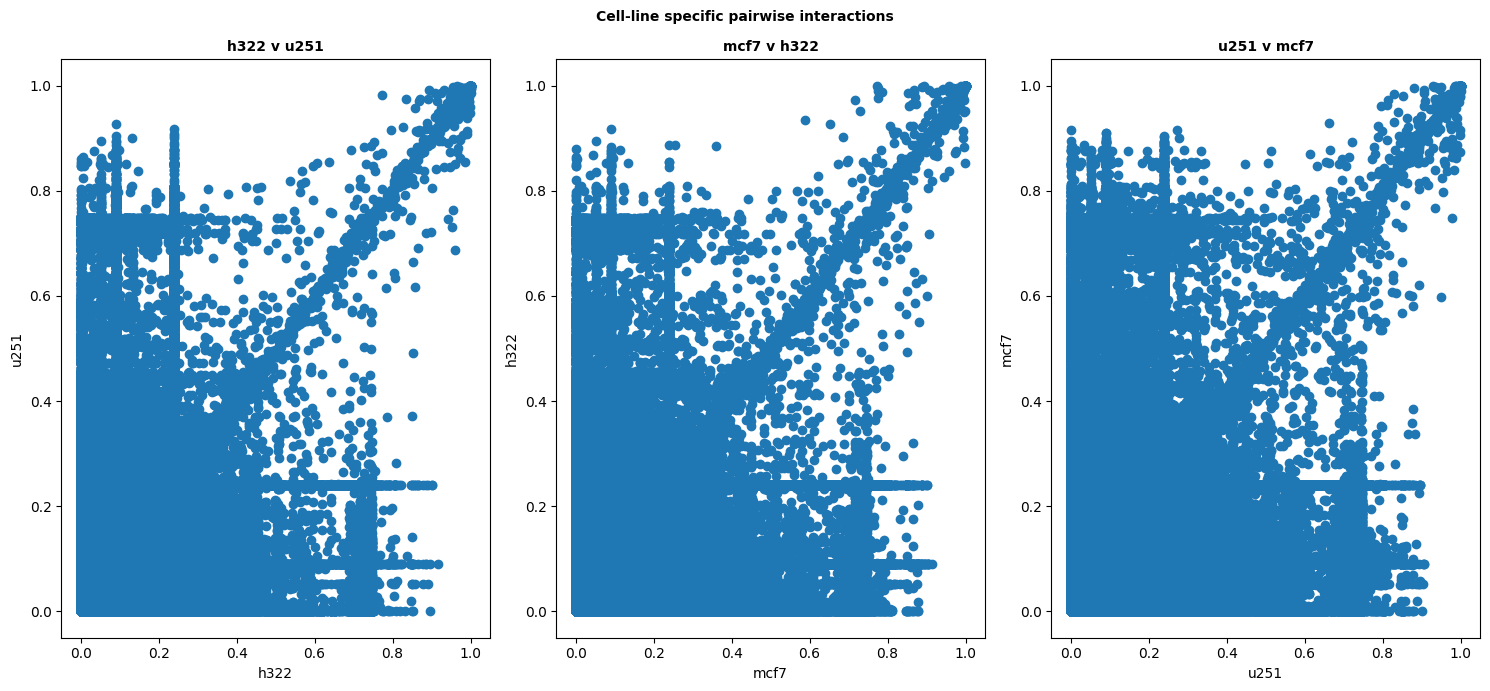

In [ ]:
sampleFrac = 0.05
f, axs = plt.subplots(1, 3, figsize=(15, 7), tight_layout=True)
ttl = 'Cell-line specific pairwise interactions'
plt.suptitle(ttl, fontsize=10, fontweight='bold')
for i, line in enumerate(cellLines):
  key = ', '.join([line, cellLines_remain[line]])
  print(key)
  probPreds_cellSpec_concat_samp = \
    probPreds_cellSpec_concat.sample(frac=sampleFrac)
  axs[i].scatter(x=probPreds_cellSpec_concat_samp[line],
                y=probPreds_cellSpec_concat_samp[cellLines_remain[line]])
  axtitle = line + ' v ' + cellLines_remain[cellLines_remain]
  axs[i].set_xlabel(cellLines_remain)
  axs[i].set_ylabel(cellLines_remain[cellLines_remain])
  axs[i].set_title(axtitle, fontsize=10, fontweight='bold')

h322, u251
mcf7, h322
u251, mcf7


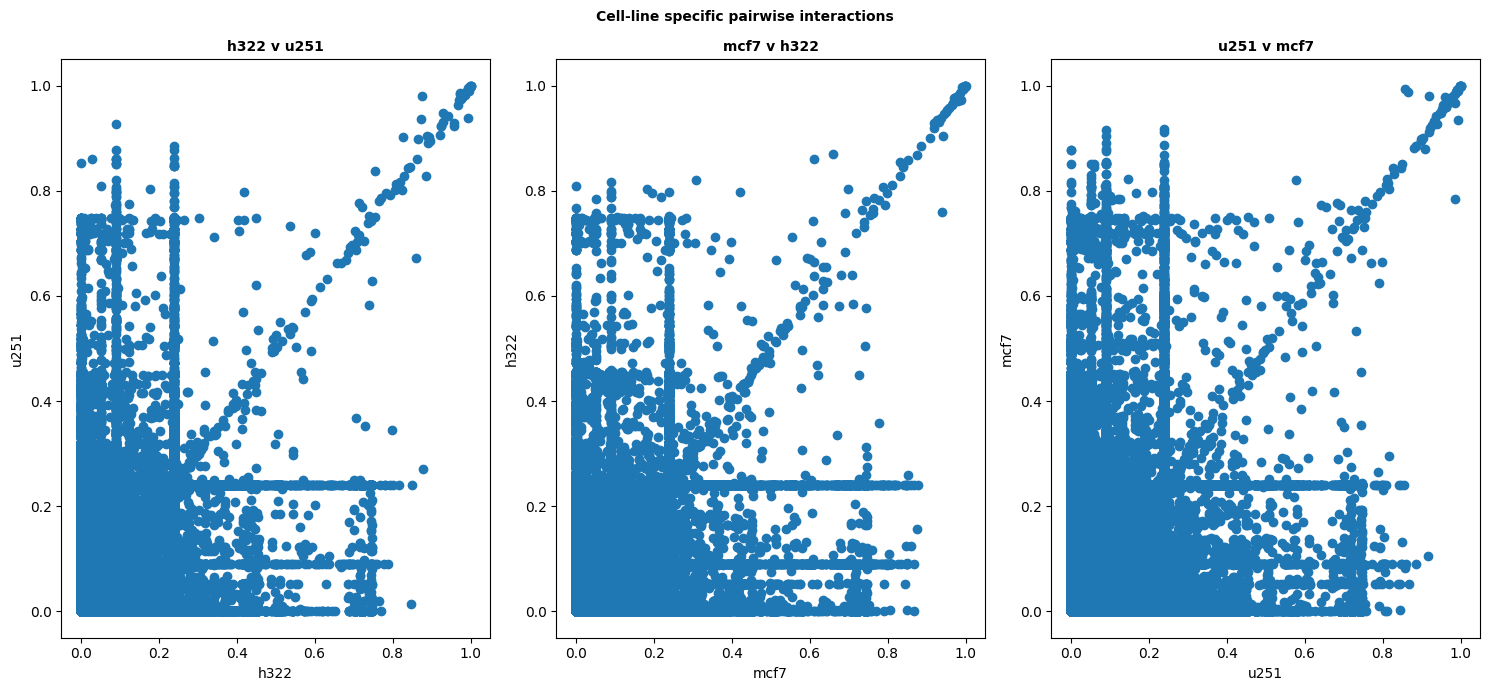

In [ ]:
sampleFrac = 0.01
f, axs = plt.subplots(1, 3, figsize=(15, 7), tight_layout=True)
ttl = 'Cell-line specific pairwise interactions'
plt.suptitle(ttl, fontsize=10, fontweight='bold')
for i, line in enumerate(cellLines):
  key = ', '.join([line, cellLines_remain[line]])
  print(key)
  probPreds_cellSpec_concat_samp = \
    probPreds_cellSpec_concat.sample(frac=sampleFrac)
  axs[i].scatter(x=probPreds_cellSpec_concat_samp[line],
                y=probPreds_cellSpec_concat_samp[cellLines_remain[line]])
  axtitle = line + ' v ' + cellLines_remain[line]
  axs[i].set_xlabel(line)
  axs[i].set_ylabel(cellLines_remain[line])
  axs[i].set_title(axtitle, fontsize=10, fontweight='bold')

###**Figure X. Cumulative probability-difference distribution for CORUM-supported interactions across cell-line-specific prediction. The figure shows that the smaller the difference in probability among scored pairwise interactions, shared by at least two cell-line-specific predictors, the more likely those interactions are present in CORUM.**

In [ ]:
#generate probability difference DF
probPreds_cellSpec_concat['h322 - mcf7'] = \
  probPreds_cellSpec_concat['h322'] - probPreds_cellSpec_concat['mcf7']

probPreds_cellSpec_concat['h322 - u251'] = \
  probPreds_cellSpec_concat['h322'] - probPreds_cellSpec_concat['u251']

probPreds_cellSpec_concat['mcf7 - u251'] = \
  probPreds_cellSpec_concat['mcf7'] - probPreds_cellSpec_concat['u251']

probDiff_predsCellSpec = \
  pd.concat([
      probPreds_cellSpec_concat[['h322 - mcf7', 'finalLabel']
                                ].dropna(drop=True).reset_index(drop=True),
      probPreds_cellSpec_concat[['h322 - u251', 'finalLabel']
                                ].dropna(drop=True).reset_index(drop=True),
      probPreds_cellSpec_concat[['mcf7 - u251', 'finalLabel']
                                ].dropna(drop=True).reset_index(drop=True)],
            axis=0)

Text(0, 0.5, 'Proportion')

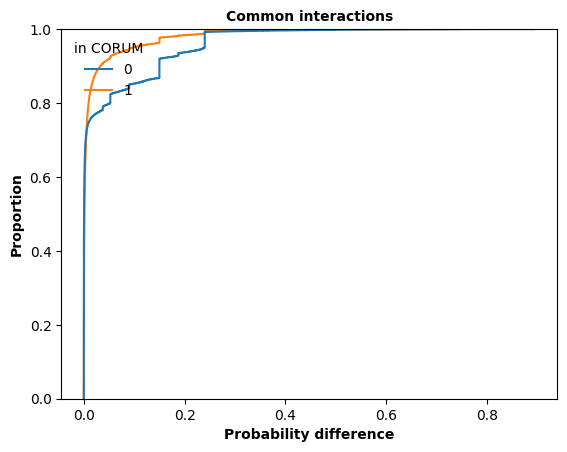

In [ ]:
f = sns.ecdfplot(
    data=probDiff_predsCellSpec.rename(
        columns={'diff': 'probability difference', 'finalLabel': 'in CORUM'}),
    x='probability difference', hue='in CORUM', stat='proportion')
sns.move_legend(f, 'upper left', frameon=False)
plt.title('Common interactions', fontsize=10, fontweight='bold')
plt.xlabel('Probability difference', fontsize=10, fontweight='bold')
plt.ylabel('Proportion', fontsize=10, fontweight='bold')

### **Complex assembly predictions' weighted precison, recall, and F1-scores for parameter combinations with highest ribosome recapitulation and purity.**

> ***Integrate into the manuscript text: all the following tables along with their relevant, supplemental counterparts.***

In [ ]:
#Grid search parameters for optimizing ribosome recapitulation and purity
#Incorporate into text (do not present as table)
gridParams_search = pickle.load(open(workDir_other + 'paramGrid.pkl', 'rb'))
gridParams_search.style.hide(subset=None, axis='columns').format(precision=3)

threshold,None,0.267,0.280,0.293,0.307,0.320
density,0.025,0.075,0.100,0.200,0.300,0.400
max overlap,0.200,0.300,0.400,0.500,0.600,0.700
inflation,2,4,6,7,8,9


####**Table 3. Best performance for complex assembly prediction by multiple measures over various parameter combinations, optimized across comparative methods.**

Present Table 3 (clustering parameter combinations and corresponding scores) clearly and unambiguously:

*   Report results for both clusterONE and clusterONE+MCL methods
*   Report the weighted F1-score and the total number of clusters predicted
*   Select for inclusion parameter combinations optimized for:

  1) the weighted F1-score,
  
  2) (both) the weighted F1-score and total clusters

*   Use complexes from the hu.MAP 2.0 test set, the latest release of CORUM, and the latest version/release of STRING as control/reference data for evaluation

Prior notes:

>   Parameter combinations for complex predictions with the highest ribosome recapitulation and purity. (Sort followed by pick)

>   Row1 = Max Make with a line for each combination

>   Find the maximum number of complexes with the clusterONE+MCL and print everything (transpose)  

>   Highlight or make a separate table for hu.MAP 2.0 top 5 and their composite and also do the same for our results with those settings



#####**Setup**

In [ ]:
#package change impacted
clusterPredictions_analysesData = \
  pd.read_pickle(workDir_other + 'intersectionSet_drew2021_expandedPairs-set/' +
                 'clusterONE_MCL_predictions_sharedPairs_gridSearch_' + \
                   'ribosomalSubunit_evalCORUM-complete_evalSTRING.pkl')

clusterPredictions_analysesData['clusterONE+MCL-STRING F1'] = \
  clusterPredictions_analysesData['clusterONE+MCL-STRING F1'].astype('float64')
clusterPredictions_analysesData['clusterONE-STRING F1'] = \
  clusterPredictions_analysesData['clusterONE-STRING F1'].astype('float64')

In [ ]:
clusterPredictions_analysesData.study = \
  clusterPredictions_analysesData.study.replace({'huMAP': 'hu.MAP 1+2'})

In [ ]:
#make table measurements sortable (since they're strings)
clusterPredictions_analysesData.loc[
    clusterPredictions_analysesData.threshold!='None', 'threshold'] = \
      pd.to_numeric(
          clusterPredictions_analysesData.loc[
              clusterPredictions_analysesData.threshold!='None',
              'threshold']).round(decimals=2)
clusterPredictions_analysesData['density'] = \
  clusterPredictions_analysesData['density'].astype('float64')
clusterPredictions_analysesData['clusterONE+MCL-STRING F1'] = \
  clusterPredictions_analysesData['clusterONE+MCL-STRING F1'].astype('float64')
clusterPredictions_analysesData['clusterONE-STRING F1'] = \
  clusterPredictions_analysesData['clusterONE-STRING F1'].astype('float64')
clusterPredictions_analysesData = \
  clusterPredictions_analysesData.round(decimals=2)

clusterPredictions_analysesData.study = \
  clusterPredictions_analysesData.study.replace(
      {'huMAP': 'hu.MAP 1+2'})

In [ ]:
#check and address the generation of identical assemblies from unique parameter inputs
clusterPredictions_analysesData['clusterONE clusters frozenset'] = \
  [set([frozenset(clust) for clust in assembly]) for assembly in
   clusterPredictions_analysesData['clusterONE clusters']]
print(len(clusterPredictions_analysesData.drop_duplicates(
    subset=['clusterONE clusters frozenset']).loc[
        clusterPredictions_analysesData.study=='ELCFS']))
print(len(clusterPredictions_analysesData.drop_duplicates(
    subset=['clusterONE clusters frozenset']).loc[
        clusterPredictions_analysesData.study=='hu.MAP 1+2']))

clusterPredictions_analysesData['clusterONE+MCL clusters frozenset'] = \
  [set([frozenset(clust) for clust in assembly]) for assembly in
   clusterPredictions_analysesData['clusterONE+MCL clusters']]
print(len(clusterPredictions_analysesData.drop_duplicates(
    subset=['clusterONE+MCL clusters frozenset']).loc[
        clusterPredictions_analysesData.study=='ELCFS']))
print(len(clusterPredictions_analysesData.drop_duplicates(
    subset=['clusterONE+MCL clusters frozenset']).loc[
        clusterPredictions_analysesData.study=='hu.MAP 1+2']))

18
17
90
85


In [ ]:
#how do the ranges of values between ELCFS and hu.MAP 1+2 compare (clusterONE)

#optimization => clusters (n, int) * score ([0, 1])
#clusterONE cluster totals' range overview important for contextualizing
#weighted-F1 and totals product

print(clusterPredictions_analysesData.loc[
    clusterPredictions_analysesData.study=='ELCFS',
    'total clusterONE clusters_x'].min())
print(clusterPredictions_analysesData.loc[
    clusterPredictions_analysesData.study=='hu.MAP 1+2',
    'total clusterONE clusters_x'].min())

print(clusterPredictions_analysesData.loc[
    clusterPredictions_analysesData.study=='ELCFS',
    'total clusterONE clusters_x'].max())
print(clusterPredictions_analysesData.loc[
    clusterPredictions_analysesData.study=='hu.MAP 1+2',
    'total clusterONE clusters_x'].max())

54
179
503
213


In [ ]:
#how do the ranges of values between ELCFS and hu.MAP 1+2 compare (clusterONE+MCL)

#optimization => clusters (n, int) * score ([0, 1])
#clusterONE cluster totals' range overview important for contextualizing
#weighted-F1 and totals product

print(clusterPredictions_analysesData.loc[
    clusterPredictions_analysesData.study=='ELCFS',
    'total clusterONE+MCL clusters_x'].min())

print(clusterPredictions_analysesData.loc[
    clusterPredictions_analysesData.study=='hu.MAP 1+2',
    'total clusterONE+MCL clusters_x'].min())

print(clusterPredictions_analysesData.loc[
    clusterPredictions_analysesData.study=='ELCFS',
    'total clusterONE+MCL clusters_x'].max())

print(clusterPredictions_analysesData.loc[
    clusterPredictions_analysesData.study=='hu.MAP 1+2',
    'total clusterONE+MCL clusters_x'].max())

338
199
2467
342


In [ ]:
colsRel = \
  ['study', 'threshold', 'overlap', 'density', 'size', 'inflation (MCL)',
   'total clusterONE clusters_x',
   'clusterONE clusters weighted F1-score_x',
   'clusterONE_clusters_weighted_F1Score_corumComplete',
   'clusterONE-STRING F1',
   'total clusterONE+MCL clusters_x',
   'clusterONE+MCL clusters weighted F1-score_x',
   'clusterONE+MCL_clusters_weighted_F1Score_corumComplete',
   'clusterONE+MCL-STRING F1']

#clusterONE
clusterPredictions_analysesData.insert(
    8, 'clusterONE_clustScore',
    clusterPredictions_analysesData.loc[:,
     ['total clusterONE clusters_x',
      'clusterONE clusters weighted F1-score_x']].product(axis=1))
clusterPredictions_analysesData.insert(
    9, 'clusterONE_clustScore-corumComplete',
    clusterPredictions_analysesData.loc[:,
     ['total clusterONE clusters_x',
      'clusterONE_clusters_weighted_F1Score_corumComplete']].product(axis=1))
clusterPredictions_analysesData.insert(
    10, 'clusterONE_clustScore-STRING',
    clusterPredictions_analysesData.loc[:,
     ['total clusterONE clusters_x',
      'clusterONE-STRING F1']].product(axis=1))

#clusterONE+MCL
clusterPredictions_analysesData.insert(
    11, 'clusterONE+MCL_clustScore',
    clusterPredictions_analysesData.loc[:,
     ['total clusterONE+MCL clusters_x',
      'clusterONE+MCL clusters weighted F1-score_x']].product(axis=1))
clusterPredictions_analysesData.insert(
    12, 'clusterONE+MCL_clustScore-corumComplete',
    clusterPredictions_analysesData.loc[:,
     ['total clusterONE+MCL clusters_x',
      'clusterONE+MCL_clusters_weighted_F1Score_corumComplete']].product(axis=1))
clusterPredictions_analysesData.insert(
    13, 'clusterONE+MCL_clustScore-STRING',
    clusterPredictions_analysesData.loc[:,
     ['total clusterONE+MCL clusters_x',
      'clusterONE+MCL-STRING F1']].product(axis=1))

clustScore_prodCols = \
  ['clusterONE_clustScore',
   'clusterONE_clustScore-corumComplete',
   'clusterONE_clustScore-STRING',
   'clusterONE+MCL_clustScore',
   'clusterONE+MCL_clustScore-corumComplete',
   'clusterONE+MCL_clustScore-STRING']

In [ ]:
#get range of parameters for matching assemblies
params = ['threshold', 'overlap', 'density', 'size']
clusts_c1Name = 'clusterONE clusters frozenset'
clusts_pMCL_c1Name = 'clusterONE+MCL clusters frozenset'

for p in params:
  print(p)
  clusterPredictions_analysesData[p + '-range'] = ''
  clusterPredictions_analysesData[p + '-range (MCL)'] = ''

  for _, row in clusterPredictions_analysesData.drop_duplicates(
      subset=[clusts_c1Name]).iterrows():

      clusterPredictions_analysesData.loc[
          clusterPredictions_analysesData[clusts_c1Name]==row[clusts_c1Name],
          p + '-range'] = \
            ', '.join(
                [str(e) for e in list(
                    clusterPredictions_analysesData.loc[
                        clusterPredictions_analysesData[
                            clusts_c1Name]==row[clusts_c1Name],
                        p].unique())])

  for _, row in clusterPredictions_analysesData.drop_duplicates(
      subset=[clusts_pMCL_c1Name]).iterrows():

      clusterPredictions_analysesData.loc[
          clusterPredictions_analysesData[
              clusts_pMCL_c1Name]==row[clusts_pMCL_c1Name],
          p + '-range (MCL)'] = \
            ', '.join(
                [str(e) for e in list(
                    clusterPredictions_analysesData.loc[
                        clusterPredictions_analysesData[
                            clusts_pMCL_c1Name]==row[clusts_pMCL_c1Name],
                        p].unique())])

clusterPredictions_analysesData['inflation (MCL)-range'] = ''
for _, row in clusterPredictions_analysesData.drop_duplicates(
      subset=[clusts_pMCL_c1Name]).iterrows():
  clusterPredictions_analysesData.loc[
    clusterPredictions_analysesData[clusts_pMCL_c1Name]==row[clusts_pMCL_c1Name],
    'inflation (MCL)-range'] = \
      ', '.join(
          [str(e) for e in list(
              clusterPredictions_analysesData.loc[
                  clusterPredictions_analysesData[
                      clusts_pMCL_c1Name]==row[clusts_pMCL_c1Name],
                  'inflation (MCL)'].unique())])

threshold
overlap
density
size


In [ ]:
#want function to simplify sorting by evaluation parameters, generating tables,
# cols selection

#args
#  refName = {CORUM, STRING}
#  sortType = {F1, prod}
#  MCL = {T, F}

def idOptimals(df, refName, sortType, MCL, return_topN=False, topN=5):

  baseCols = \
    [c for c in clusterPredictions_analysesData.columns.to_list()
    if all(['range' in c])]
  if not MCL:
    baseCols = [c for c in baseCols if 'MCL' not in c]
  else:
    baseCols = [c for c in baseCols if 'MCL' in c]
  baseCols = ['study'] + baseCols
  print(baseCols)

  assembly = 'clusterONE+MCL clusters frozenset' if MCL else 'clusterONE clusters frozenset'

  #give automation by argument sort idea here...
  #refName: 1 of these strings will be present in s: {corumComplete, string}
  #sortType: F1 or product (F1*cluster length) => {F1, clustScore}
  #MCL: either it will have MCL or not
  ref = 'corumComplete' if refName=='CORUM' else 'STRING'
  evalType = 'F1' if sortType=='F1' else 'clustScore'
  params = [ref, evalType, '+MCL'] if MCL else [ref, evalType]
  print(params)
  eval = [col for col in df.columns.to_list() if all([p in col for p in params])]
  if not MCL:
    eval = [col for col in eval if '+MCL' not in col]
  print(eval)

  selectCols = baseCols + eval + [assembly]
  selectCols = selectCols + ['total clusterONE+MCL clusters_x'] if MCL else \
    selectCols + ['total clusterONE clusters_x']

  dfSort = \
    df.drop_duplicates(subset=assembly).sort_values(by=eval[0], ascending=False)
  dfSort_select = dfSort[selectCols].head(topN)
  dfSort_select['Optimal parameter'] = eval[0]
  dfSort_select['Optimal parameter value'] = dfSort_select[eval[0]]
  topParams = dfSort_select.iloc[0, :].to_frame().T

  colRenames = \
    {'threshold-range (MCL)': 'threshold', 'threshold-range': 'threshold',
     'overlap-range (MCL)': 'overlap', 'overlap-range': 'overlap',
     'density-range (MCL)': 'density', 'density-range': 'density',
     'size-range (MCL)': 'size', 'size-range': 'size',
     'inflation (MCL)-range': 'inflation (MCL)',
     'total clusterONE clusters_x': 'total clusters',
     'total clusterONE+MCL clusters_x': 'total clusters',
     assembly: 'clusters'}
  topParams.rename(columns=colRenames, inplace=True)
  dfSort_select.rename(columns=colRenames, inplace=True)

  if MCL:
    reportCols = \
      ['study',
       'threshold', 'overlap', 'density', 'size', 'inflation (MCL)',
       'Optimal parameter', 'Optimal parameter value',
       'total clusters', 'clusters']
  else:
    reportCols = \
      ['study',
       'threshold', 'overlap', 'density', 'size',
       'Optimal parameter', 'Optimal parameter value',
       'total clusters', 'clusters']

  if return_topN:
    return dfSort_select[reportCols], topParams[reportCols]
  else:
    return topParams[reportCols]

#####**Top parameter combinations by optimizing strategy**

In [ ]:
#*To-Do
#Debug table 3 setup
#For the cell type specific assemblies, insert common pairwise
#Make common-pairwise etc. tables (below)

**ClusterONE CORUM F1 optimal**

In [ ]:
dfSort_select, _ = \
  idOptimals(clusterPredictions_analysesData, 'CORUM', 'F1', False, True, 5)
dfSort_select

['study', 'threshold-range', 'overlap-range', 'density-range', 'size-range']
['corumComplete', 'F1']
['clusterONE_clusters_weighted_F1Score_corumComplete']


,study,threshold,overlap,density,size,Optimal parameter,Optimal parameter value,total clusters,clusters
85,ELCFS,0.28,0.2,0.02,2,clusterONE_clusters_weighted_F1Score_corumComp...,0.49,58,"{(8662, 8665, 1981, 8663, 8661, 8667, 3646, 27..."
50,ELCFS,0.28,0.4,0.05,2,clusterONE_clusters_weighted_F1Score_corumComp...,0.48,112,"{(8662, 8665, 1981, 8663, 8661, 8667, 3646, 27..."
110,ELCFS,0.28,0.2,0.08,2,clusterONE_clusters_weighted_F1Score_corumComp...,0.48,54,"{(8662, 8665, 1981, 8663, 8661, 8667, 3646, 27..."
90,ELCFS,0.28,0.3,0.02,2,clusterONE_clusters_weighted_F1Score_corumComp...,0.48,86,"{(8662, 8665, 1981, 8663, 8661, 8667, 3646, 27..."
95,ELCFS,0.28,0.2,0.05,2,clusterONE_clusters_weighted_F1Score_corumComp...,0.48,59,"{(8662, 8665, 1981, 8663, 8661, 8667, 3646, 27..."


**ClusterONE STRING F1 optimal**

In [ ]:
dfSort_select, _ = \
  idOptimals(clusterPredictions_analysesData, 'STRING', 'F1', False, True, 5)
dfSort_select

['study', 'threshold-range', 'overlap-range', 'density-range', 'size-range']
['STRING', 'F1']
['clusterONE-STRING F1']


,study,threshold,overlap,density,size,Optimal parameter,Optimal parameter value,total clusters,clusters
5,ELCFS,"0.28, 0.29, 0.31, 0.32, None",0.7,0.1,2,clusterONE-STRING F1,0.56,239,"{(23176, 55752, 10212, 7402, 4735, 4170, 3068,..."
0,ELCFS,"0.28, 0.29, 0.31, 0.32, None",0.6,0.1,2,clusterONE-STRING F1,0.55,190,"{(23176, 55752, 10212, 7402, 4735, 4170, 3068,..."
10,ELCFS,"0.28, 0.29, 0.31, 0.32, None",0.6,0.2,2,clusterONE-STRING F1,0.55,288,"{(23176, 55752, 10212, 7402, 4735, 4170, 3068,..."
80,ELCFS,0.28,0.5,0.08,2,clusterONE-STRING F1,0.54,147,"{(23176, 55752, 10212, 7402, 4735, 4170, 3068,..."
70,ELCFS,0.28,0.4,0.08,2,clusterONE-STRING F1,0.53,112,"{(57504, 71, 5787, 1656, 351, 3678, 84126, 417..."


**ClusterONE+MCL CORUM F1 optimal**

In [ ]:
dfSort_select, _ = \
  idOptimals(clusterPredictions_analysesData, 'CORUM', 'F1', True, True, 5)
dfSort_select

['study', 'threshold-range (MCL)', 'overlap-range (MCL)', 'density-range (MCL)', 'size-range (MCL)', 'inflation (MCL)-range']
['corumComplete', 'F1', '+MCL']
['clusterONE+MCL_clusters_weighted_F1Score_corumComplete']


,study,threshold,overlap,density,size,inflation (MCL),Optimal parameter,Optimal parameter value,total clusters,clusters
310,hu.MAP 1+2,"0.28, 0.29, 0.31, 0.32, None",0.7,0.2,2,2,clusterONE+MCL_clusters_weighted_F1Score_corum...,0.45,216,"{(8517, 3551, 1147), (7456, 867, 2885, 50807, ..."
315,hu.MAP 1+2,"0.28, 0.29, 0.31, 0.32, None",0.6,0.3,2,2,clusterONE+MCL_clusters_weighted_F1Score_corum...,0.45,206,"{(8517, 3551, 1147), (51665, 8065), (25885, 64..."
295,hu.MAP 1+2,"0.28, 0.29, 0.31, 0.32, None",0.6,0.1,2,2,clusterONE+MCL_clusters_weighted_F1Score_corum...,0.45,219,"{(8517, 3551, 1147), (7456, 867, 2885, 50807, ..."
320,hu.MAP 1+2,"0.28, 0.29, 0.31, 0.32, None",0.7,0.3,2,2,clusterONE+MCL_clusters_weighted_F1Score_corum...,0.45,213,"{(8517, 3551, 1147), (51665, 8065), (25885, 64..."
365,hu.MAP 1+2,0.28,0.5,0.08,2,2,clusterONE+MCL_clusters_weighted_F1Score_corum...,0.45,209,"{(8517, 3551, 1147), (7456, 867, 2885, 50807, ..."


**ClusterONE+MCL STRING F1 optimal**

In [ ]:
dfSort_select, _ = \
  idOptimals(clusterPredictions_analysesData, 'STRING', 'F1', True, True, 5)
dfSort_select

['study', 'threshold-range (MCL)', 'overlap-range (MCL)', 'density-range (MCL)', 'size-range (MCL)', 'inflation (MCL)-range']
['STRING', 'F1', '+MCL']
['clusterONE+MCL-STRING F1']


,study,threshold,overlap,density,size,inflation (MCL),Optimal parameter,Optimal parameter value,total clusters,clusters
40,ELCFS,0.28,0.3,0.05,2,2,clusterONE+MCL-STRING F1,0.52,435,"{(3068, 10844), (128866, 51160, 7813, 27243, 2..."
55,ELCFS,0.28,0.5,0.05,2,2,clusterONE+MCL-STRING F1,0.52,541,"{(28956, 7095, 2342, 8540, 10274, 5859), (8157..."
320,hu.MAP 1+2,"0.28, 0.29, 0.31, 0.32, None",0.7,0.3,2,2,clusterONE+MCL-STRING F1,0.52,213,"{(8517, 3551, 1147), (51665, 8065), (25885, 64..."
60,ELCFS,0.28,0.3,0.08,2,2,clusterONE+MCL-STRING F1,0.51,404,"{(3068, 10844), (128866, 51160, 7813, 27243, 2..."
70,ELCFS,0.28,0.4,0.08,2,2,clusterONE+MCL-STRING F1,0.51,443,"{(3068, 10844), (128866, 51160, 7813, 27243, 2..."


**ClusterONE CORUM F1-Length Product optimal**

In [ ]:
dfSort_select, _ = \
  idOptimals(clusterPredictions_analysesData, 'CORUM', '*', False, True, 5)
dfSort_select

['study', 'threshold-range', 'overlap-range', 'density-range', 'size-range']
['corumComplete', 'clustScore']
['clusterONE_clustScore-corumComplete']


,study,threshold,overlap,density,size,Optimal parameter,Optimal parameter value,total clusters,clusters
25,ELCFS,"0.28, 0.29, 0.31, 0.32, None",0.7,0.3,2,clusterONE_clustScore-corumComplete,163.54,481,"{(9031, 10847, 5902, 8717, 637, 865, 7531), (5..."
35,ELCFS,"0.28, 0.29, 0.31, 0.32, None",0.7,0.4,2,clusterONE_clustScore-corumComplete,155.93,503,"{(6015, 648, 80012, 57332, 6045), (55746, 5712..."
20,ELCFS,"0.28, 0.29, 0.31, 0.32, None",0.6,0.3,2,clusterONE_clustScore-corumComplete,155.40,444,"{(9031, 10847, 5902, 8717, 637, 865, 7531), (7..."
30,ELCFS,"0.28, 0.29, 0.31, 0.32, None",0.6,0.4,2,clusterONE_clustScore-corumComplete,140.94,486,"{(6015, 648, 80012, 57332, 6045), (25885, 2146..."
15,ELCFS,"0.28, 0.29, 0.31, 0.32, None",0.7,0.2,2,clusterONE_clustScore-corumComplete,132.60,340,"{(9869, 7818, 1977, 5515, 55729, 1385, 55599, ..."


**ClusterONE STRING F1-Length Product optimal**

In [ ]:
dfSort_select, _ = \
  idOptimals(clusterPredictions_analysesData, 'STRING', '*', False, True, 5)
dfSort_select

['study', 'threshold-range', 'overlap-range', 'density-range', 'size-range']
['STRING', 'clustScore']
['clusterONE_clustScore-STRING']


,study,threshold,overlap,density,size,Optimal parameter,Optimal parameter value,total clusters,clusters
25,ELCFS,"0.28, 0.29, 0.31, 0.32, None",0.7,0.3,2,clusterONE_clustScore-STRING,230.88,481,"{(9031, 10847, 5902, 8717, 637, 865, 7531), (5..."
35,ELCFS,"0.28, 0.29, 0.31, 0.32, None",0.7,0.4,2,clusterONE_clustScore-STRING,221.32,503,"{(6015, 648, 80012, 57332, 6045), (55746, 5712..."
30,ELCFS,"0.28, 0.29, 0.31, 0.32, None",0.6,0.4,2,clusterONE_clustScore-STRING,213.84,486,"{(6015, 648, 80012, 57332, 6045), (25885, 2146..."
20,ELCFS,"0.28, 0.29, 0.31, 0.32, None",0.6,0.3,2,clusterONE_clustScore-STRING,213.12,444,"{(9031, 10847, 5902, 8717, 637, 865, 7531), (7..."
15,ELCFS,"0.28, 0.29, 0.31, 0.32, None",0.7,0.2,2,clusterONE_clustScore-STRING,180.20,340,"{(9869, 7818, 1977, 5515, 55729, 1385, 55599, ..."


**ClusterONE+MCL CORUM F1-Length Product optimal**

In [ ]:
dfSort_select, _ = \
  idOptimals(clusterPredictions_analysesData, 'CORUM', '*', True, True, 5)
dfSort_select

['study', 'threshold-range (MCL)', 'overlap-range (MCL)', 'density-range (MCL)', 'size-range (MCL)', 'inflation (MCL)-range']
['corumComplete', 'clustScore', '+MCL']
['clusterONE+MCL_clustScore-corumComplete']


,study,threshold,overlap,density,size,inflation (MCL),Optimal parameter,Optimal parameter value,total clusters,clusters
91,ELCFS,0.28,0.3,0.02,2,4,clusterONE+MCL_clustScore-corumComplete,566.06,1826,"{(84342, 25839, 9183, 83548, 91949), (4008, 51..."
86,ELCFS,0.28,0.2,0.02,2,4,clusterONE+MCL_clustScore-corumComplete,544.67,1757,"{(84342, 25839, 9183, 83548, 91949), (4008, 51..."
56,ELCFS,0.28,0.5,0.05,2,4,clusterONE+MCL_clustScore-corumComplete,462.74,1361,"{(59345, 2768, 60561), (6938, 6117), (10096, 9..."
87,ELCFS,0.28,0.2,0.02,2,6,clusterONE+MCL_clustScore-corumComplete,456.33,2173,"{(2873), (6500), (4008, 51592, 57680), (8559, ..."
92,ELCFS,0.28,0.3,0.02,2,6,clusterONE+MCL_clustScore-corumComplete,450.80,2254,"{(2873), (6500), (4008, 51592, 57680), (8559, ..."


**ClusterONE+MCL STRING F1-Length Product optimal**

In [ ]:
dfSort_select, _ = \
  idOptimals(clusterPredictions_analysesData, 'STRING', '*', True, True, 5)
dfSort_select

['study', 'threshold-range (MCL)', 'overlap-range (MCL)', 'density-range (MCL)', 'size-range (MCL)', 'inflation (MCL)-range']
['STRING', 'clustScore', '+MCL']
['clusterONE+MCL_clustScore-STRING']


,study,threshold,overlap,density,size,inflation (MCL),Optimal parameter,Optimal parameter value,total clusters,clusters
94,ELCFS,0.28,0.3,0.02,2,9,clusterONE+MCL_clustScore-STRING,986.80,2467,"{(2873), (6500), (4008, 51592, 57680), (8559, ..."
93,ELCFS,0.28,0.3,0.02,2,7,clusterONE+MCL_clustScore-STRING,968.83,2363,"{(2873), (9349, 6173, 10528, 6732, 6135, 1938,..."
89,ELCFS,0.28,0.2,0.02,2,9,clusterONE+MCL_clustScore-STRING,932.49,2391,"{(2873), (6500), (4008, 51592, 57680), (8559, ..."
92,ELCFS,0.28,0.3,0.02,2,6,clusterONE+MCL_clustScore-STRING,924.14,2254,"{(2873), (6500), (4008, 51592, 57680), (8559, ..."
87,ELCFS,0.28,0.2,0.02,2,6,clusterONE+MCL_clustScore-STRING,912.66,2173,"{(2873), (6500), (4008, 51592, 57680), (8559, ..."


***ClusterONE | Ribosome reconstruction***

In [ ]:
colsRel = \
  ['study', 'threshold', 'density', 'overlap', 'size',
   'total clusterONE clusters_x',
   'clusterONE_srF1', 'clusterONE_lrF1']

In [ ]:
clusterPredictions_analysesData.drop_duplicates(
    subset=['clusterONE clusters frozenset']
    ).loc[:, colsRel].sort_values(
        by=['clusterONE_srF1'], ascending=False).head()

,study,threshold,density,overlap,size,total clusterONE clusters_x,clusterONE_srF1,clusterONE_lrF1
345,hu.MAP 1+2,0.28,0.05,0.4,2,186,0.69,0.51
350,hu.MAP 1+2,0.28,0.05,0.5,2,188,0.69,0.51
365,hu.MAP 1+2,0.28,0.08,0.5,2,187,0.69,0.51
355,hu.MAP 1+2,0.28,0.08,0.3,2,182,0.69,0.51
335,hu.MAP 1+2,0.28,0.05,0.3,2,183,0.69,0.51


In [ ]:
clusterPredictions_analysesData.drop_duplicates(
    subset=['clusterONE clusters frozenset']
    ).loc[:, colsRel].sort_values(
        by=['clusterONE_lrF1'], ascending=False).head()

,study,threshold,density,overlap,size,total clusterONE clusters_x,clusterONE_srF1,clusterONE_lrF1
380,hu.MAP 1+2,0.28,0.05,0.2,2,179,0.51,0.69
300,hu.MAP 1+2,0.28,0.10,0.7,2,197,0.51,0.69
305,hu.MAP 1+2,0.28,0.20,0.6,2,182,0.51,0.69
310,hu.MAP 1+2,0.28,0.20,0.7,2,188,0.51,0.69
315,hu.MAP 1+2,0.28,0.30,0.6,2,188,0.51,0.69


***ClusterONE+MCL | Ribosome reconstruction***

In [ ]:
colsRel = \
  ['study', 'threshold', 'density', 'overlap', 'size', 'inflation (MCL)',
   'total clusterONE+MCL clusters_x',
   'clusterONE+MCL_srF1', 'clusterONE+MCL_lrF1']

In [ ]:
clusterPredictions_analysesData.drop_duplicates(
    subset=['clusterONE+MCL clusters frozenset']
    ).loc[:, colsRel].sort_values(
        by=['clusterONE+MCL_srF1'], ascending=False).head()

,study,threshold,density,overlap,size,inflation (MCL),total clusterONE+MCL clusters_x,clusterONE+MCL_srF1,clusterONE+MCL_lrF1
72,ELCFS,0.28,0.08,0.4,2,4,877,0.99,0.97
51,ELCFS,0.28,0.05,0.4,2,4,1241,0.99,0.97
81,ELCFS,0.28,0.08,0.5,2,4,981,0.99,0.97
62,ELCFS,0.28,0.08,0.3,2,4,813,0.99,0.97
56,ELCFS,0.28,0.05,0.5,2,4,1361,0.99,0.97


In [ ]:
clusterPredictions_analysesData.drop_duplicates(
    subset=['clusterONE+MCL clusters frozenset']
    ).loc[:, colsRel].sort_values(
        by=['clusterONE+MCL_lrF1'], ascending=False).head()

,study,threshold,density,overlap,size,inflation (MCL),total clusterONE+MCL clusters_x,clusterONE+MCL_srF1,clusterONE+MCL_lrF1
36,ELCFS,0.28,0.40,0.7,2,4,871,0.98,1.00
31,ELCFS,0.28,0.40,0.6,2,4,854,0.98,1.00
96,ELCFS,0.28,0.05,0.2,2,4,1104,0.97,0.99
16,ELCFS,0.28,0.20,0.7,2,4,1134,0.65,0.99
86,ELCFS,0.28,0.02,0.2,2,4,1757,0.97,0.99


#####**Top parameter combination for each optimizing strategy**

In [ ]:
n = 1
cplxRef = ['CORUM', 'STRING']
measure = ['F1', '*']
inclMCL = [False, True]
topParams_specs = list(it.product(cplxRef, measure, inclMCL))

In [ ]:
%%capture
topParams = \
  pd.concat(
      [idOptimals(clusterPredictions_analysesData,
                  *list(input)) for input in topParams_specs])

In [ ]:
%%capture
topParams_elcfs = \
  pd.concat(
      [idOptimals(clusterPredictions_analysesData.loc[
          clusterPredictions_analysesData.study=='ELCFS'],
                  *list(input)) for input in topParams_specs])

**Table 3a**

In [ ]:
topParams_elcfs

,study,threshold,overlap,density,size,Optimal parameter,Optimal parameter value,total clusters,clusters,inflation (MCL)
85,ELCFS,0.28,0.2,0.02,2,clusterONE_clusters_weighted_F1Score_corumComp...,0.49,58,"{(114294, 51263, 9801, 54148, 51650, 51023, 12...",NaN
85,ELCFS,0.28,0.2,0.02,2,clusterONE+MCL_clusters_weighted_F1Score_corum...,0.44,436,"{(3068, 10844), (128866, 51160, 7813, 27243, 2...",2
25,ELCFS,"0.28, 0.29, 0.31, 0.32, None",0.7,0.3,2,clusterONE_clustScore-corumComplete,163.54,481,"{(9031, 10847, 5902, 8717, 637, 865, 7531), (5...",NaN
91,ELCFS,0.28,0.3,0.02,2,clusterONE+MCL_clustScore-corumComplete,566.06,1826,"{(84342, 25839, 9183, 83548, 91949), (4008, 51...",4
5,ELCFS,"0.28, 0.29, 0.31, 0.32, None",0.7,0.1,2,clusterONE-STRING F1,0.56,239,"{(23176, 55752, 10212, 7402, 4735, 4170, 3068,...",NaN
40,ELCFS,0.28,0.3,0.05,2,clusterONE+MCL-STRING F1,0.52,435,"{(3068, 10844), (128866, 51160, 7813, 27243, 2...",2
25,ELCFS,"0.28, 0.29, 0.31, 0.32, None",0.7,0.3,2,clusterONE_clustScore-STRING,230.88,481,"{(9031, 10847, 5902, 8717, 637, 865, 7531), (5...",NaN
94,ELCFS,0.28,0.3,0.02,2,clusterONE+MCL_clustScore-STRING,986.8,2467,"{(2873), (6500), (4008, 51592, 57680), (8559, ...",9


In [ ]:
clustersELCFS_topParams = \
  pd.DataFrame({'cluster':
                list(set().union(*topParams_elcfs.clusters.to_list()))})

In [ ]:
clustersELCFS_topParams.insert(
    1, 'prots', [len(cluster) for cluster in clustersELCFS_topParams.cluster])

In [ ]:
clustersELCFS_topParams.prots.unique()
[(n, len(clustersELCFS_topParams.loc[clustersELCFS_topParams.prots==n])) for n in clustersELCFS_topParams.prots.unique()]

[(1, 1376),
 (5, 222),
 (7, 87),
 (4, 166),
 (2, 435),
 (3, 255),
 (6, 231),
 (23, 5),
 (25, 6),
 (28, 4),
 (9, 33),
 (17, 14),
 (11, 30),
 (14, 23),
 (10, 34),
 (16, 9),
 (33, 3),
 (19, 14),
 (22, 11),
 (12, 21),
 (40, 1),
 (29, 2),
 (47, 1),
 (26, 3),
 (21, 4),
 (8, 45),
 (27, 8),
 (121, 1),
 (18, 14),
 (24, 5),
 (20, 9),
 (38, 3),
 (50, 2),
 (13, 16),
 (44, 1),
 (15, 12),
 (944, 1),
 (120, 1),
 (30, 4),
 (32, 2),
 (76, 1),
 (34, 1),
 (57, 1),
 (42, 2),
 (1421, 1),
 (37, 3),
 (36, 1),
 (111, 1),
 (52, 1),
 (146, 1),
 (56, 1),
 (206, 1),
 (43, 2),
 (31, 1),
 (568, 1),
 (51, 1),
 (236, 1),
 (204, 1)]

In [ ]:
clustersELCFS_topParams.prots.unique()
[(n, len(clustersELCFS_topParams.loc[clustersELCFS_topParams.prots==n])) for n in clustersELCFS_topParams.prots.unique()]

[(7, 83),
 (1, 1377),
 (5, 212),
 (6, 221),
 (3, 245),
 (2, 425),
 (4, 162),
 (18, 14),
 (21, 4),
 (16, 8),
 (22, 12),
 (9, 33),
 (11, 29),
 (14, 22),
 (28, 4),
 (12, 21),
 (10, 27),
 (8, 47),
 (29, 4),
 (34, 1),
 (38, 3),
 (17, 15),
 (37, 3),
 (36, 1),
 (25, 7),
 (19, 12),
 (20, 7),
 (15, 12),
 (13, 16),
 (27, 8),
 (23, 4),
 (24, 5),
 (236, 1),
 (50, 2),
 (26, 2),
 (57, 1),
 (43, 2),
 (76, 1),
 (568, 1),
 (111, 1),
 (120, 1),
 (33, 2),
 (30, 3),
 (146, 1),
 (47, 1),
 (31, 1),
 (54, 1),
 (56, 1),
 (44, 1),
 (32, 2),
 (121, 1),
 (42, 2),
 (52, 1),
 (1421, 1),
 (206, 1),
 (944, 1),
 (204, 1)]

In [ ]:
clustersELCFS_topParams['CORUM'] = \
  [cplx in set(accessCORUM.humanCplx_frozen)
  for cplx in clustersELCFS_topParams.cluster.to_list()]

In [ ]:
clustersELCFS_topParams['STRING'] = \
  [cplx in set(cmpStudies.stringCplxs)
  for cplx in clustersELCFS_topParams.cluster.to_list()]

In [ ]:
numWorkers = cpu_count() - 1
with Pool(numWorkers) as pool:
    clustersELCFS_topParams['ppis possible'] = \
          list(progressMonitor(pool.imap(
              operations.generatePairs, clustersELCFS_topParams.cluster.to_list()),
                               total=len(clustersELCFS_topParams.cluster.to_list())))

100%|██████████| 3136/3136 [00:01<00:00, 1609.07it/s]


In [ ]:
def getPPIs(s):
  #return s.intersection(elcfs.pairsFrozen.to_list())
  return s.intersection(probPreds_cellSpec_concat.pairsFrozen.to_list())

numWorkers = cpu_count() - 1
with Pool(numWorkers) as pool:
    clustersELCFS_topParams['ppis'] = \
          list(progressMonitor(
              pool.imap(getPPIs, clustersELCFS_topParams['ppis possible'].to_list()),
              total=len(clustersELCFS_topParams['ppis possible'].to_list())))

In [ ]:
clustersELCFS_topParams['ppis possible total'] = \
  [len(s) for s in clustersELCFS_topParams['ppis possible']]
clustersELCFS_topParams['ppis total'] = \
  [len(s) for s in clustersELCFS_topParams['ppis']]

In [ ]:
def getMin(s):
  return elcfs.loc[elcfs.pairsFrozen.isin(s), 'prob'].min()

def getMean(s):
  return elcfs.loc[elcfs.pairsFrozen.isin(s), 'prob'].mean()

numWorkers = cpu_count() - 1
with Pool(numWorkers) as pool:
    clustersELCFS_topParams['min Score'] = \
          list(progressMonitor(
              pool.imap(getMin, clustersELCFS_topParams['ppis possible'].to_list()),
              total=len(clustersELCFS_topParams['ppis possible'].to_list())))

with Pool(numWorkers) as pool:
    clustersELCFS_topParams['mean Score'] = \
          list(progressMonitor(
              pool.imap(getMean, clustersELCFS_topParams['ppis possible'].to_list()),
              total=len(clustersELCFS_topParams['ppis possible'].to_list())))

In [ ]:
def diffRef(df, refCplxs, refName):
  bestMatches = []
  for cplx in df.cluster.to_list():
    intersects = pd.DataFrame({'ref': refCplxs})
    intersects['ji'] = \
      [len(cplx.intersection(ref))/len(ref)
        if len(ref)!=0 else 0 for ref in refCplxs]
    bestMatches.append(intersects.sort_values(
        by=['ji'], ascending=False).iloc[0, 0])

  symDiff = \
    [cplx.symmetric_difference(ref)
    for cplx, ref in zip(df.cluster.to_list(), bestMatches)]

  df[refName + 'Diff'] = [len(e) for e in symDiff]

  df[refName + 'Diff_pred'] = \
    [len(e.intersection(cplx)) for e, cplx in zip(symDiff, df.cluster.to_list())]

  df[refName + 'Diff_ref'] = \
    [len(e.intersection(cplx)) for e, cplx in zip(symDiff, bestMatches)]

  return df

In [ ]:
clustersELCFS_topParams = \
  diffRef(clustersELCFS_topParams, accessCORUM.humanCplx_frozen, 'corum')

In [ ]:
clustersELCFS_topParams = \
  diffRef(clustersELCFS_topParams, cmpStudies.stringCplxs, 'string')

In [ ]:
colsWanted = \
  ['cluster', 'prots', 'min Score', 'mean Score',
   'CORUM', 'corumDiff', 'corumDiff_pred', 'corumDiff_ref',
   'STRING', 'stringDiff', 'stringDiff_pred', 'stringDiff_ref']

**Fig S3 (real) CORUM Diff Histogram (Figure out how corumDiff was calculated)**

put string and Corum together in two panels

<Axes: xlabel='corumDiff', ylabel='Probability'>

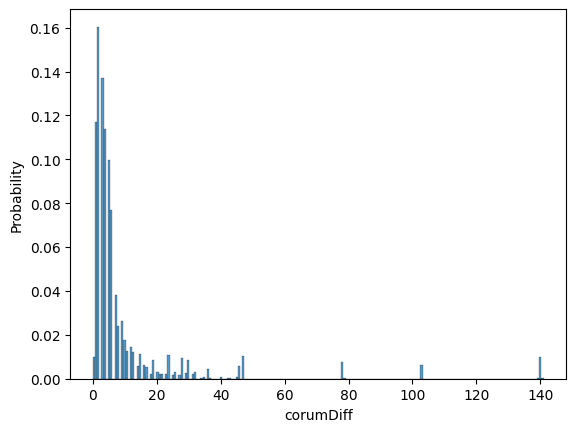

In [ ]:
sns.histplot(data=clustersELCFS_topParams.loc[clustersELCFS_topParams.prots<50],
             x='corumDiff', stat='probability')

**STRING Diff Histogram**

<Axes: xlabel='stringDiff', ylabel='Probability'>

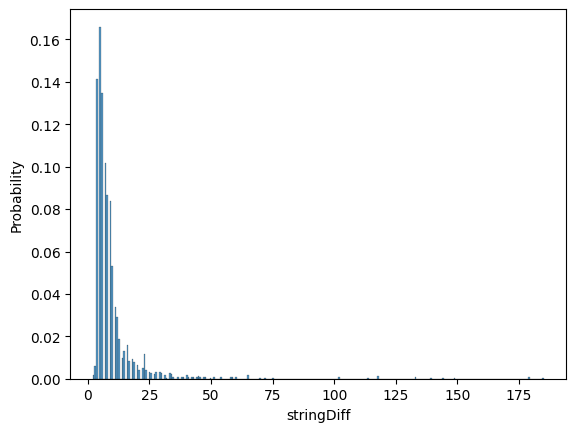

In [ ]:
sns.histplot(data=clustersELCFS_topParams.loc[clustersELCFS_topParams.prots<50],
             x='stringDiff', stat='probability')

**Table 3b (Top Complexes by Min Score)**

In [ ]:
clustersELCFS_topParams.loc[
    clustersELCFS_topParams.prots>2, colsWanted].sort_values(
        by=['min Score'], ascending=False).iloc[:20]

,cluster,prots,min Score,mean Score,CORUM,corumDiff,corumDiff_pred,corumDiff_ref,STRING,stringDiff,stringDiff_pred,stringDiff_ref
3043,"(9804, 387, 11218)",3,0.935852,0.966878,False,4,2,2,False,7,2,5
1848,"(9804, 387, 201595)",3,0.935852,0.944021,False,4,2,2,False,6,2,4
2034,"(51433, 29882, 64682)",3,0.890844,0.946640,False,5,0,5,False,3,0,3
141,"(51665, 4869, 150684)",3,0.889893,0.919800,False,3,2,1,False,6,2,4
2824,"(1495, 1499, 2319)",3,0.884399,0.919932,False,1,1,0,False,4,1,3
805,"(26168, 27043, 54881)",3,0.875544,0.906804,False,2,0,2,False,3,0,3
634,"(5516, 5515, 9869)",3,0.857412,0.928706,False,3,2,1,False,5,1,4
2245,"(10492, 10452, 5265)",3,0.855387,0.902440,False,3,2,1,False,6,2,4
2785,"(2923, 5034, 5033)",3,0.836772,0.854930,False,1,1,0,False,7,2,5
96,"(79711, 4217, 9126)",3,0.819722,0.887380,False,3,2,1,False,6,2,4


In [ ]:
clustersELCFS_topParams.loc[
    ((clustersELCFS_topParams.prots>2) &
     (clustersELCFS_topParams.prots<50)), colsWanted].sort_values(
        by=['min Score'], ascending=False).iloc[:20]

,cluster,prots,min Score,mean Score,CORUM,corumDiff,corumDiff_pred,corumDiff_ref,STRING,stringDiff,stringDiff_pred,stringDiff_ref
1848,"(9804, 387, 201595)",3,0.935852,0.944021,False,4,2,2,False,6,2,4
3043,"(9804, 387, 11218)",3,0.935852,0.966878,False,4,2,2,False,7,2,5
2034,"(51433, 29882, 64682)",3,0.890844,0.946640,False,5,0,5,False,3,0,3
141,"(51665, 4869, 150684)",3,0.889893,0.919800,False,3,2,1,False,6,2,4
2824,"(1495, 1499, 2319)",3,0.884399,0.919932,False,1,1,0,False,4,1,3
805,"(26168, 27043, 54881)",3,0.875544,0.906804,False,2,0,2,False,3,0,3
634,"(5516, 5515, 9869)",3,0.857412,0.928706,False,3,2,1,False,5,1,4
2245,"(10492, 10452, 5265)",3,0.855387,0.902440,False,3,2,1,False,6,2,4
2785,"(2923, 5034, 5033)",3,0.836772,0.854930,False,1,1,0,False,7,2,5
96,"(79711, 4217, 9126)",3,0.819722,0.887380,False,3,2,1,False,6,2,4


*(Top Complexes by Mean Score)*

In [ ]:
clustersELCFS_topParams.loc[
    clustersELCFS_topParams.prots>2, colsWanted].sort_values(
        by=['mean Score'], ascending=False).iloc[:20]

,cluster,prots,min Score,mean Score,CORUM,corumDiff,corumDiff_pred,corumDiff_ref,STRING,stringDiff,stringDiff_pred,stringDiff_ref
3043,"(9804, 387, 11218)",3,0.935852,0.966878,False,4,2,2,False,7,2,5
2034,"(51433, 29882, 64682)",3,0.890844,0.946640,False,5,0,5,False,3,0,3
1848,"(9804, 387, 201595)",3,0.935852,0.944021,False,4,2,2,False,6,2,4
634,"(5516, 5515, 9869)",3,0.857412,0.928706,False,3,2,1,False,5,1,4
2824,"(1495, 1499, 2319)",3,0.884399,0.919932,False,1,1,0,False,4,1,3
141,"(51665, 4869, 150684)",3,0.889893,0.919800,False,3,2,1,False,6,2,4
805,"(26168, 27043, 54881)",3,0.875544,0.906804,False,2,0,2,False,3,0,3
2523,"(6257, 124944, 3320)",3,0.809570,0.904419,False,3,2,1,False,7,2,5
2245,"(10492, 10452, 5265)",3,0.855387,0.902440,False,3,2,1,False,6,2,4
518,"(55114, 7408, 983)",3,0.793569,0.896784,False,3,2,1,False,6,2,4


In [ ]:
clustersELCFS_topParams.loc[
    ((clustersELCFS_topParams.prots>2) &
     (clustersELCFS_topParams.prots<50)), colsWanted].sort_values(
        by=['mean Score'], ascending=False).iloc[:20]

,cluster,prots,min Score,mean Score,CORUM,corumDiff,corumDiff_pred,corumDiff_ref,STRING,stringDiff,stringDiff_pred,stringDiff_ref
3043,"(9804, 387, 11218)",3,0.935852,0.966878,False,4,2,2,False,7,2,5
2034,"(51433, 29882, 64682)",3,0.890844,0.946640,False,5,0,5,False,3,0,3
1848,"(9804, 387, 201595)",3,0.935852,0.944021,False,4,2,2,False,6,2,4
634,"(5516, 5515, 9869)",3,0.857412,0.928706,False,3,2,1,False,5,1,4
2824,"(1495, 1499, 2319)",3,0.884399,0.919932,False,1,1,0,False,4,1,3
141,"(51665, 4869, 150684)",3,0.889893,0.919800,False,3,2,1,False,6,2,4
805,"(26168, 27043, 54881)",3,0.875544,0.906804,False,2,0,2,False,3,0,3
2523,"(6257, 124944, 3320)",3,0.809570,0.904419,False,3,2,1,False,7,2,5
2245,"(10492, 10452, 5265)",3,0.855387,0.902440,False,3,2,1,False,6,2,4
518,"(55114, 7408, 983)",3,0.793569,0.896784,False,3,2,1,False,6,2,4


In [ ]:
#Just list the top (sort mean score)
#Just list the top (sort min score)
#Want xor each of our complexes with that of CORUM (sort on XOR 'difference': # prots different between the two)
#Of those prots (2 cols), which ones are in us and which ones are in CORUM e.g., how many of those did they have and how many of those did we have)

**Table 3c (corumDiff, asc)**

In [ ]:
clustersELCFS_topParams.loc[
    clustersELCFS_topParams.prots>2, colsWanted].sort_values(
        by=['corumDiff'], ascending=True).iloc[:20]

,cluster,prots,min Score,mean Score,CORUM,corumDiff,corumDiff_pred,corumDiff_ref,STRING,stringDiff,stringDiff_pred,stringDiff_ref
2615,"(4801, 4802, 4800)",3,0.246166,0.556984,True,0,0,0,False,8,0,8
2566,"(7507, 2067, 2072)",3,0.054060,0.298681,True,0,0,0,False,2,0,2
1110,"(64785, 9837, 84296, 51659)",4,0.001875,0.633515,True,0,0,0,False,3,1,2
563,"(11234, 79803, 84343)",3,0.181056,0.507598,True,0,0,0,False,7,0,7
2106,"(55823, 64601, 57617, 57154)",4,0.035836,0.599301,False,1,1,0,False,5,2,3
3052,"(10787, 10006, 55845, 10163)",4,0.026040,0.668730,False,1,0,1,False,7,0,7
939,"(51520, 9255, 7965, 5917, 4141, 3376, 3735, 16...",12,0.000313,0.499976,False,1,1,0,False,7,7,0
2092,"(4801, 5074, 4802, 4800)",4,0.001771,0.404188,False,1,1,0,False,9,1,8
712,"(5289, 84515, 30849)",3,0.066050,0.418482,False,1,1,0,False,5,1,4
2439,"(26519, 26520, 10131)",3,0.217194,0.387845,False,1,1,0,False,5,1,4


In [ ]:
clustersELCFS_topParams.loc[
    ((clustersELCFS_topParams.prots>2) &
     (clustersELCFS_topParams.prots<50)), colsWanted].sort_values(
        by=['corumDiff'], ascending=True).iloc[:20]

,cluster,prots,min Score,mean Score,CORUM,corumDiff,corumDiff_pred,corumDiff_ref,STRING,stringDiff,stringDiff_pred,stringDiff_ref
563,"(11234, 79803, 84343)",3,0.181056,0.507598,True,0,0,0,False,7,0,7
1110,"(64785, 9837, 84296, 51659)",4,0.001875,0.633515,True,0,0,0,False,3,1,2
2615,"(4801, 4802, 4800)",3,0.246166,0.556984,True,0,0,0,False,8,0,8
2566,"(7507, 2067, 2072)",3,0.054060,0.298681,True,0,0,0,False,2,0,2
3052,"(10787, 10006, 55845, 10163)",4,0.026040,0.668730,False,1,0,1,False,7,0,7
2071,"(56984, 8624, 9265)",3,0.116757,0.587502,False,1,1,0,False,4,1,3
3031,"(51520, 9255, 7965, 5917, 4141, 3376, 3735, 16...",12,0.000313,0.502765,False,1,1,0,False,7,7,0
2605,"(81, 9837, 51659, 64785, 84296)",5,0.000313,0.473571,False,1,1,0,False,4,2,2
939,"(51520, 9255, 7965, 5917, 4141, 3376, 3735, 16...",12,0.000313,0.499976,False,1,1,0,False,7,7,0
85,"(11234, 79803, 84343, 5290)",4,0.181056,0.545268,False,1,1,0,False,8,1,7


**Table 3d (corumDiff, desc)**

In [ ]:
clustersELCFS_topParams.loc[
    clustersELCFS_topParams.prots>2, colsWanted].sort_values(
        by=['corumDiff'], ascending=False).iloc[:20]

,cluster,prots,min Score,mean Score,CORUM,corumDiff,corumDiff_pred,corumDiff_ref,STRING,stringDiff,stringDiff_pred,stringDiff_ref
2263,"(4809, 2033, 9555, 4790, 10109, 1981, 11097, 1...",1421,0.000000,0.031403,False,1418,1418,0,False,1413,1413,0
2696,"(1021, 4809, 6840, 10643, 10614, 10142, 998, 3...",944,0.000000,0.037336,False,942,942,0,False,939,939,0
812,"(51434, 4809, 10643, 10614, 1616, 65109, 1653,...",568,0.000000,0.060022,False,564,564,0,False,563,563,0
499,"(8802, 50848, 10026, 5476, 9495, 10142, 84342,...",236,0.000000,0.042456,False,231,231,0,False,231,231,0
2365,"(8563, 4809, 10643, 80012, 2975, 6632, 29105, ...",206,0.000000,0.099331,False,201,201,0,False,195,195,0
3053,"(8453, 8454, 3778, 5476, 4643, 71, 55752, 7332...",204,0.000000,0.040262,False,196,196,0,False,197,197,0
1284,"(10226, 6840, 2935, 1174, 3909, 4790, 6217, 84...",146,0.000000,0.045296,False,145,145,0,False,141,141,0
2009,"(6840, 5476, 7332, 54518, 2319, 7323, 4893, 40...",121,0.000000,0.044176,False,118,118,0,False,118,117,1
926,"(10643, 6128, 6130, 6217, 6227, 6135, 4343, 55...",120,0.000000,0.324146,False,117,117,0,False,112,112,0
908,"(10643, 6128, 6130, 6217, 6227, 6135, 4343, 55...",111,0.000000,0.337186,False,108,108,0,False,103,103,0


In [ ]:
clustersELCFS_topParams.loc[
    ((clustersELCFS_topParams.prots>2) &
     (clustersELCFS_topParams.prots<50)), colsWanted].sort_values(
        by=['corumDiff'], ascending=False).iloc[:20]

,cluster,prots,min Score,mean Score,CORUM,corumDiff,corumDiff_pred,corumDiff_ref,STRING,stringDiff,stringDiff_pred,stringDiff_ref
2633,"(51263, 28957, 65003)",3,0.051355,0.401576,False,47,1,46,False,34,1,33
2289,"(64979, 128308, 28998)",3,0.408635,0.744549,False,45,0,45,False,7,2,5
1976,"(114294, 116540, 65080)",3,0.008750,0.486944,False,45,0,45,False,6,2,4
1294,"(79595, 57504, 648, 80012, 53615, 25942, 1108,...",47,0.000000,0.138988,False,43,43,0,False,42,42,0
1677,"(51053, 81620, 11127, 6867, 2033, 4790, 5216, ...",44,0.000000,0.099710,False,42,42,0,False,41,40,1
2042,"(114294, 1021, 3778, 1029, 54205, 84126, 5441,...",42,0.000000,0.077207,False,40,40,0,False,40,38,2
2404,"(84148, 203068, 79913, 648, 80012, 5747, 63908...",42,0.000000,0.075778,False,40,40,0,False,42,39,3
444,"(6130, 25873, 6173, 10528, 6230, 10969, 6156, ...",37,0.000000,0.355612,False,37,34,3,False,37,33,4
3057,"(51604, 10226, 23557, 10026, 6778, 8881, 12886...",43,0.000000,0.081589,False,36,36,0,False,39,38,1
181,"(79023, 93974, 54973, 4289, 92105, 65123, 5903...",38,0.000000,0.114527,False,36,36,0,False,33,32,1


In [ ]:
#targetDir = workDir + 'manuscriptGraphics/'
#shutil.copytree('./manuscriptGraphics', workDir + 'manuscriptGraphics')

'/content/drive/MyDrive/elcfs_protein_complex_modeling/manuscriptGraphics'

**Table 3e (stringDiff, asc)**

In [ ]:
clustersELCFS_topParams.loc[
    clustersELCFS_topParams.prots>2, colsWanted].sort_values(
        by=['stringDiff'], ascending=True).iloc[:20]

,cluster,prots,min Score,mean Score,CORUM,corumDiff,corumDiff_pred,corumDiff_ref,STRING,stringDiff,stringDiff_pred,stringDiff_ref
416,"(5440, 5436, 5434, 5439, 5433, 5438, 5432, 544...",9,0.000313,0.483122,False,3,0,3,False,2,2,0
2566,"(7507, 2067, 2072)",3,0.054060,0.298681,True,0,0,0,False,2,0,2
511,"(65057, 25913, 7014)",3,0.285409,0.508090,False,1,0,1,False,2,0,2
1756,"(4605, 132660, 55957, 91750, 2958)",5,0.001354,0.309257,False,4,2,2,False,2,1,1
2243,"(388552, 57511, 10466, 84342, 22796, 25839, 83...",8,0.001459,0.427156,False,4,4,0,False,2,1,1
2938,"(51604, 6400, 10026, 8733)",4,0.000313,0.469029,False,3,1,2,False,3,1,2
805,"(26168, 27043, 54881)",3,0.875544,0.906804,False,2,0,2,False,3,0,3
299,"(10466, 84342, 25839, 83548, 91949)",5,0.133536,0.634824,False,3,3,0,False,3,0,3
2382,"(57511, 10466, 150684, 22796, 84342, 25839, 64...",9,0.001459,0.359080,False,7,7,0,False,3,2,1
1630,"(6642, 10465, 58533, 6643)",4,0.025622,0.671962,False,2,2,0,False,3,1,2


In [ ]:
clustersELCFS_topParams.loc[
    ((clustersELCFS_topParams.prots>2) &
     (clustersELCFS_topParams.prots<50)), colsWanted].sort_values(
        by=['stringDiff'], ascending=True).iloc[:20]

,cluster,prots,min Score,mean Score,CORUM,corumDiff,corumDiff_pred,corumDiff_ref,STRING,stringDiff,stringDiff_pred,stringDiff_ref
416,"(5440, 5436, 5434, 5439, 5433, 5438, 5432, 544...",9,0.000313,0.483122,False,3,0,3,False,2,2,0
511,"(65057, 25913, 7014)",3,0.285409,0.508090,False,1,0,1,False,2,0,2
2566,"(7507, 2067, 2072)",3,0.054060,0.298681,True,0,0,0,False,2,0,2
2243,"(388552, 57511, 10466, 84342, 22796, 25839, 83...",8,0.001459,0.427156,False,4,4,0,False,2,1,1
1756,"(4605, 132660, 55957, 91750, 2958)",5,0.001354,0.309257,False,4,2,2,False,2,1,1
805,"(26168, 27043, 54881)",3,0.875544,0.906804,False,2,0,2,False,3,0,3
2678,"(162, 1174, 164, 8906, 10053, 130340, 8905)",7,0.000626,0.381314,False,1,0,1,False,3,2,1
2382,"(57511, 10466, 150684, 22796, 84342, 25839, 64...",9,0.001459,0.359080,False,7,7,0,False,3,2,1
299,"(10466, 84342, 25839, 83548, 91949)",5,0.133536,0.634824,False,3,3,0,False,3,0,3
2407,"(7507, 2067, 11066, 2072)",4,0.005313,0.309553,False,1,1,0,False,3,1,2


**Table 3f (stringDiff, desc)**

In [ ]:
clustersELCFS_topParams.loc[
    clustersELCFS_topParams.prots>2, colsWanted].sort_values(
        by=['stringDiff'], ascending=False).iloc[:20]

,cluster,prots,min Score,mean Score,CORUM,corumDiff,corumDiff_pred,corumDiff_ref,STRING,stringDiff,stringDiff_pred,stringDiff_ref
2263,"(4809, 2033, 9555, 4790, 10109, 1981, 11097, 1...",1421,0.000000,0.031403,False,1418,1418,0,False,1413,1413,0
2696,"(1021, 4809, 6840, 10643, 10614, 10142, 998, 3...",944,0.000000,0.037336,False,942,942,0,False,939,939,0
812,"(51434, 4809, 10643, 10614, 1616, 65109, 1653,...",568,0.000000,0.060022,False,564,564,0,False,563,563,0
499,"(8802, 50848, 10026, 5476, 9495, 10142, 84342,...",236,0.000000,0.042456,False,231,231,0,False,231,231,0
3053,"(8453, 8454, 3778, 5476, 4643, 71, 55752, 7332...",204,0.000000,0.040262,False,196,196,0,False,197,197,0
2365,"(8563, 4809, 10643, 80012, 2975, 6632, 29105, ...",206,0.000000,0.099331,False,201,201,0,False,195,195,0
1284,"(10226, 6840, 2935, 1174, 3909, 4790, 6217, 84...",146,0.000000,0.045296,False,145,145,0,False,141,141,0
2009,"(6840, 5476, 7332, 54518, 2319, 7323, 4893, 40...",121,0.000000,0.044176,False,118,118,0,False,118,117,1
926,"(10643, 6128, 6130, 6217, 6227, 6135, 4343, 55...",120,0.000000,0.324146,False,117,117,0,False,112,112,0
908,"(10643, 6128, 6130, 6217, 6227, 6135, 4343, 55...",111,0.000000,0.337186,False,108,108,0,False,103,103,0


In [ ]:
clustersELCFS_topParams.loc[
    ((clustersELCFS_topParams.prots>2) &
     (clustersELCFS_topParams.prots<50)), colsWanted].sort_values(
        by=['stringDiff'], ascending=False).iloc[:20]

,cluster,prots,min Score,mean Score,CORUM,corumDiff,corumDiff_pred,corumDiff_ref,STRING,stringDiff,stringDiff_pred,stringDiff_ref
280,"(6606, 147841, 10403, 57405, 83540, 55168)",6,0.001146,0.540817,False,2,2,0,False,44,2,42
2469,"(147841, 51645, 10403, 57405, 83540, 3298)",6,0.001146,0.314267,False,2,2,0,False,44,2,42
2404,"(84148, 203068, 79913, 648, 80012, 5747, 63908...",42,0.000000,0.075778,False,40,40,0,False,42,39,3
1294,"(79595, 57504, 648, 80012, 53615, 25942, 1108,...",47,0.000000,0.138988,False,43,43,0,False,42,42,0
1677,"(51053, 81620, 11127, 6867, 2033, 4790, 5216, ...",44,0.000000,0.099710,False,42,42,0,False,41,40,1
2042,"(114294, 1021, 3778, 1029, 54205, 84126, 5441,...",42,0.000000,0.077207,False,40,40,0,False,40,38,2
605,"(2734, 55558, 857, 56655, 3915, 1956, 8828, 36...",38,0.000000,0.103568,False,36,36,0,False,39,36,3
3057,"(51604, 10226, 23557, 10026, 6778, 8881, 12886...",43,0.000000,0.081589,False,36,36,0,False,39,38,1
252,"(51160, 5427, 56655, 1111, 6845, 1615, 2783, 7...",36,0.000000,0.086426,False,35,34,1,False,38,34,4
647,"(114294, 51263, 9801, 51650, 740, 28977, 6150,...",43,0.000000,0.521304,False,34,24,10,False,38,37,1


In [ ]:
#map GeneIDs to UniProtKB protein IDs
#Note: GeneIDs with non-unique UniProtKB mappings will be depicted as
#parentheticals enclosing all its matches
clustersELCFS_topParams_prots = \
  set().union(*clustersELCFS_topParams.cluster.to_list())
idMapping = \
  operations.mapProts(clustersELCFS_topParams_prots, 'GeneID', 'UniProtKB')

resubmitting job...
resubmitting job...


In [ ]:
idMapping = dict(zip(idMapping.GeneID.to_list(), idMapping.UniProtKB.to_list()))
clusters2List_mapped = \
  [','.join([idMapping[p] for p in clust])
  for clust in clustersELCFS_topParams.cluster.to_list()]
clustersELCFS_topParams.insert(1, 'UniProtKB Mapping', clusters2List_mapped)

In [ ]:
clustersELCFS_topParams.loc[
    ((clustersELCFS_topParams.prots>2) &
     (clustersELCFS_topParams.prots<50)),
      ['cluster', 'UniProtKB Mapping', 'prots',
       'min Score', 'mean Score',
       'CORUM', 'corumDiff', 'corumDiff_pred', 'corumDiff_ref',
       'STRING', 'stringDiff', 'stringDiff_pred', 'stringDiff_ref']
    ].sort_values(by=['stringDiff'], ascending=False).iloc[:20]

,cluster,UniProtKB Mapping,prots,min Score,mean Score,CORUM,corumDiff,corumDiff_pred,corumDiff_ref,STRING,stringDiff,stringDiff_pred,stringDiff_ref
280,"(6606, 147841, 10403, 57405, 83540, 55168)","(B4DP61,E7EQZ4,Q16637),Q8NBT2,(A8K031,O14777),...",6,0.001146,0.540817,False,2,2,0,False,44,2,42
2469,"(147841, 51645, 10403, 57405, 83540, 3298)","Q8NBT2,Q9Y3C6,(A8K031,O14777),Q9HBM1,Q9BZD4,(Q...",6,0.001146,0.314267,False,2,2,0,False,44,2,42
2404,"(84148, 203068, 79913, 648, 80012, 5747, 63908...","Q9H7Z6,(B4DMJ5,B4DQN9,B4DY90,P07437,Q5ST81,Q5S...",42,0.000000,0.075778,False,40,40,0,False,42,39,3
1294,"(79595, 57504, 648, 80012, 53615, 25942, 1108,...","(A0A2R8YDB8,H7BXF5,Q96DP1,Q9H0E3),(F6RRE2,Q9BT...",47,0.000000,0.138988,False,43,43,0,False,42,42,0
1677,"(51053, 81620, 11127, 6867, 2033, 4790, 5216, ...","O75496,Q9H211,(B4DHG8,E9PES4,J3KPF9,Q05CT3,Q9Y...",44,0.000000,0.099710,False,42,42,0,False,41,40,1
2042,"(114294, 1021, 3778, 1029, 54205, 84126, 5441,...","P83111,Q00534,(A0A087WZL8,A0A1W2PP94,A0A1W2PPY...",42,0.000000,0.077207,False,40,40,0,False,40,38,2
605,"(2734, 55558, 857, 56655, 3915, 1956, 8828, 36...","Q92896,P51805,(A9XTE5,Q03135,Q2TNI1,Q59E85,Q7Z...",38,0.000000,0.103568,False,36,36,0,False,39,36,3
3057,"(51604, 10226, 23557, 10026, 6778, 8881, 12886...","Q969N2,(A0A140VJN8,O60664),O95295,Q92643,(A8K4...",43,0.000000,0.081589,False,36,36,0,False,39,38,1
252,"(51160, 5427, 56655, 1111, 6845, 1615, 2783, 7...","(A0A0S2Z5H5,Q548N1,Q9UK41),P56282,Q9NR33,(B4DT...",36,0.000000,0.086426,False,35,34,1,False,38,34,4
647,"(114294, 51263, 9801, 51650, 740, 28977, 6150,...","P83111,Q8TCC3,P49406,(A4D1T3,Q3KRB4,Q9Y291),Q1...",43,0.000000,0.521304,False,34,24,10,False,38,37,1


In [ ]:
clustersELCFS_topParams_a.to_csv('./predictedClustersDF.tsv', sep='\t')

In [ ]:
'''
pickle.dump(clustersELCFS_topParams, open(
    workDir + 'assemblyData/clustersELCFS_topParams.pkl', 'wb'))
'''

"\npickle.dump(clustersELCFS_topParams, open(\n    workDir + 'assemblyData/clustersELCFS_topParams.pkl', 'wb'))\n"

###**Figure 5. Scatterplot of weighted F1-scores between CORUM 11.28.22 and STRING v12.**

> **Keep working on a better caption**

> **Get rid of legend frames to be consistent**

In [ ]:
selectCols_clusterPredictions_analysesData = \
  ['study',
   'clusterONE_clusters_weighted_F1Score_corumComplete',
   'clusterONE-STRING F1',
   'total clusterONE clusters_x',
   'clusterONE+MCL_clusters_weighted_F1Score_corumComplete',
   'clusterONE+MCL-STRING F1',
   'total clusterONE+MCL clusters_x']

clusterPredictions_analysesData_rshp = \
  clusterPredictions_analysesData.loc[
      :, selectCols_clusterPredictions_analysesData].copy()
clusterPredictions_analysesData_rshp.rename(
    columns={'study': 'Source',
             'clusterONE_clusters_weighted_F1Score_corumComplete':
             'clusterONE F1 (CORUM)',
             'clusterONE+MCL_clusters_weighted_F1Score_corumComplete':
             'clusterONE+MCL F1 (CORUM)',
             'clusterONE-STRING F1': 'clusterONE F1 (STRING)',
             'clusterONE+MCL-STRING F1': 'clusterONE+MCL F1 (STRING)',
             'total clusterONE clusters_x': 'clusterONE predicted clusters',
             'total clusterONE+MCL clusters_x':
             'clusterONE+MCL predicted clusters'},
    inplace=True)

In [ ]:
clusterPredictions_analysesData_rshp.insert(3, 'optimal', 'False')
clusterPredictions_analysesData_rshp1 = \
  clusterPredictions_analysesData_rshp.copy()
clusterPredictions_analysesData_rshp2 = \
  clusterPredictions_analysesData_rshp.copy()

clusterPredictions_analysesData_rshp1.loc[
    clusterPredictions_analysesData_rshp1.index.isin(
        topParams.loc[~topParams['Optimal parameter'].str.contains('MCL')].index),
    'optimal'] = 'True'

clusterPredictions_analysesData_rshp2.loc[
    clusterPredictions_analysesData_rshp2.index.isin(
        topParams.loc[topParams['Optimal parameter'].str.contains('MCL')].index),
    'optimal'] = 'True'

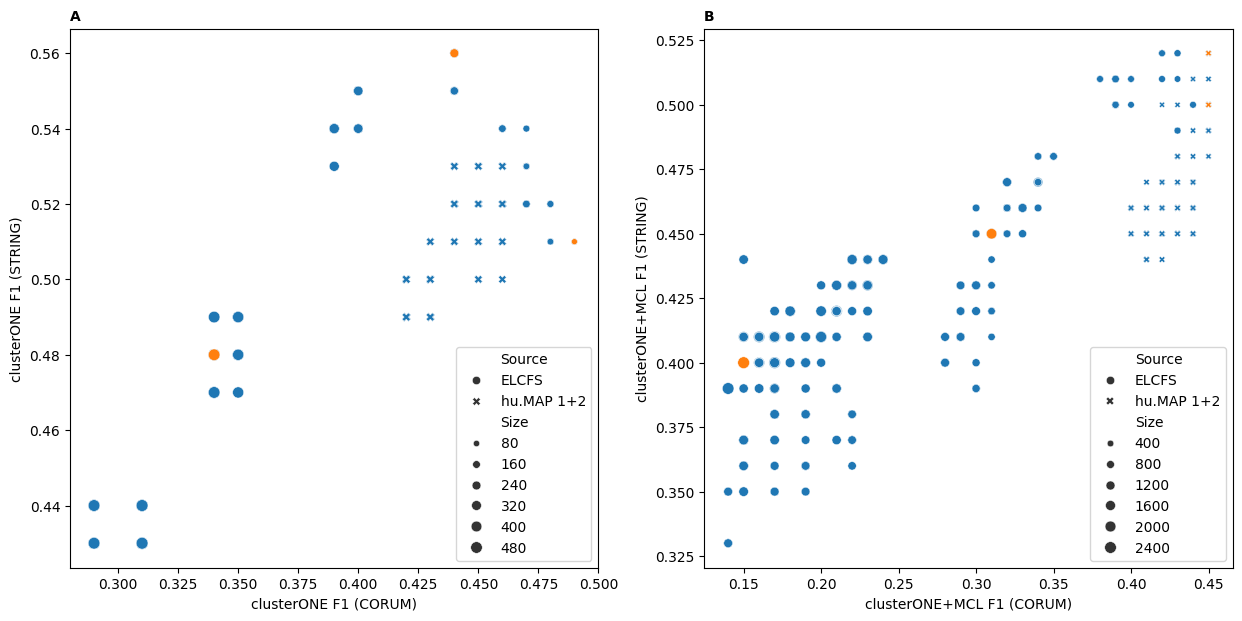

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(15, 7))

##
##A: ClusterONE Assembly
sns.scatterplot(
        clusterPredictions_analysesData_rshp1.sort_values(
            'optimal').rename(
                columns={'clusterONE predicted clusters': 'Size'}),
        x='clusterONE F1 (CORUM)', y='clusterONE F1 (STRING)',
        style='Source', size='Size', hue='optimal', ax=axs[0])

hand, labl = axs[0].get_legend_handles_labels()
handout, lablout = [], []
for h, l in zip(hand, labl):
  if l in ['True', 'False', 'optimal']:
    pass
  else:
    handout.append(h)
    lablout.append(l)
lablout = lablout[-3:] + lablout[:-3]
handout = handout[-3:] + handout[:-3]
axs[0].legend(handout, lablout, loc='lower right')
axs[0].set_title('A', loc='left', fontsize=10, fontweight='bold')

##
##B: ClusterONE+MCL Assembly
sns.scatterplot(
        clusterPredictions_analysesData_rshp2.sort_values(
            'optimal').rename(
            columns={'clusterONE+MCL predicted clusters': 'Size'}),
        x='clusterONE+MCL F1 (CORUM)',
        y='clusterONE+MCL F1 (STRING)',
        style='Source', size='Size', hue='optimal', ax=axs[1])

hand, labl = axs[1].get_legend_handles_labels()
handout, lablout = [], []
for h, l in zip(hand, labl):
  if l in ['True', 'False', 'optimal']:
    pass
  else:
    handout.append(h)
    lablout.append(l)
lablout = lablout[-3:] + lablout[:-3]
handout = handout[-3:] + handout[:-3]
axs[1].legend(handout, lablout, loc='lower right')
axs[1].set_title('B', loc='left', fontsize=10, fontweight='bold')

plt.savefig(graphicsDir + 'figure_4.svg')
plt.savefig(graphicsDir + 'figure_4.png', dpi=600)

###**High-confidence, cell-line specific complex predictions**

***for cell line-specific scoring of complexes***

1) Make scatterplot of complex scores for pairs of cell lines (3 panels)...✔️

2) Make table of common, pairwise, and unique complex predictions using .28 threshold using the min score

Data structure should contain all complexes, regardless of cell-line,
Each complex = row
Every column is the confidence/score for a particular cell-line (or nonspecific)
Get difference between confidence/score for each pair of cell-lines -- more columns (A-B, B-C, C-A)
Add col for max of those diffs and sort

> Similar data structure to [Table 4](https://). Will need to report F1-optimal threshold (used by cell-line)

>Count

Prior notes:
>First thing: getting high confidence, cell-line-specific complex predictions

>Second thing: identifying any supporting evidence

>Take nonspecific complex predictions and score each of them by the product of

> Pick the one best param combination from each of huMAP and ELCFS.


1.   Score each complex by the product of the cell-line-specific scores for their constituents AND by the average of the cell-line-specific scores for their
constituents

2.   Rank by the largest difference(s) (will give us the set of proteins that we need to purchase antibodies for)


*   Top 10 ranked by cell-line difference
*   top 10 ranked by product of cell-line difference and confidence
*   top 10 ranked by product of cell-line difference and size

**note, make sure it's at the bottom of the complexes eval helper notebook**

####**Table 4**

In [ ]:
def getMin(s):
  return elcfs.loc[elcfs.pairsFrozen.isin(s), 'probsPos_h322'].min()

def getMean(s):
  return elcfs.loc[elcfs.pairsFrozen.isin(s), 'probsPos_h322'].mean()

numWorkers = cpu_count() - 1
with Pool(numWorkers) as pool:
    clustersELCFS_topParams['min Score H322'] = \
          list(progressMonitor(
              pool.imap(getMin, clustersELCFS_topParams['ppis possible'].to_list()),
              total=len(clustersELCFS_topParams['ppis possible'].to_list())))

with Pool(numWorkers) as pool:
    clustersELCFS_topParams['mean Score H322'] = \
          list(progressMonitor(
              pool.imap(getMean, clustersELCFS_topParams['ppis possible'].to_list()),
              total=len(clustersELCFS_topParams['ppis possible'].to_list())))

In [ ]:
def getMin(s):
  return elcfs.loc[elcfs.pairsFrozen.isin(s), 'probsPos_mcf7'].min()

def getMean(s):
  return elcfs.loc[elcfs.pairsFrozen.isin(s), 'probsPos_mcf7'].mean()

numWorkers = cpu_count() - 1
with Pool(numWorkers) as pool:
    clustersELCFS_topParams['min Score MCF7'] = \
          list(progressMonitor(
              pool.imap(getMin, clustersELCFS_topParams['ppis possible'].to_list()),
              total=len(clustersELCFS_topParams['ppis possible'].to_list())))

with Pool(numWorkers) as pool:
    clustersELCFS_topParams['mean Score MCF7'] = \
          list(progressMonitor(
              pool.imap(getMean, clustersELCFS_topParams['ppis possible'].to_list()),
              total=len(clustersELCFS_topParams['ppis possible'].to_list())))

In [ ]:
def getMin(s):
  return elcfs.loc[elcfs.pairsFrozen.isin(s), 'probsPos_u251'].min()

def getMean(s):
  return elcfs.loc[elcfs.pairsFrozen.isin(s), 'probsPos_u251'].mean()

numWorkers = cpu_count() - 1
with Pool(numWorkers) as pool:
    clustersELCFS_topParams['min Score U251'] = \
          list(progressMonitor(
              pool.imap(getMin, clustersELCFS_topParams['ppis possible'].to_list()),
              total=len(clustersELCFS_topParams['ppis possible'].to_list())))

with Pool(numWorkers) as pool:
    clustersELCFS_topParams['mean Score U251'] = \
          list(progressMonitor(
              pool.imap(getMean, clustersELCFS_topParams['ppis possible'].to_list()),
              total=len(clustersELCFS_topParams['ppis possible'].to_list())))

100%|██████████| 3077/3077 [00:38<00:00, 80.05it/s]


In [ ]:
probDiff_cols = \
  ['H322 - MCF7 mean', 'H322 - U251 mean', 'MCF7 - U251 mean',
   'H322 - MCF7 min', 'H322 - U251 min', 'MCF7 - U251 min']

colsWanted = \
  ['cluster', 'UniProtKB Mapping', 'prots',
   'corumDiff', 'corumDiff_pred', 'corumDiff_ref',
   'stringDiff', 'stringDiff_pred', 'stringDiff_ref',
   'min Score', 'mean Score', 'maxScore_min', 'maxScore_mean',
   'min Score H322', 'min Score MCF7', 'min Score U251',
   'mean Score H322', 'mean Score MCF7', 'mean Score U251']

In [ ]:
for col in probDiff_cols:
  cellType1 = col.split(' ')[0]
  cellType2 = col.split(' ')[2]
  scoreType = col.split(' ')[-1] + ' Score'
  print(cellType1, cellType2, scoreType)

  clustersELCFS_topParams[col] = \
    abs(clustersELCFS_topParams[scoreType + ' ' + cellType1] - \
      clustersELCFS_topParams[scoreType + ' ' + cellType2])

maxScore_min = \
  clustersELCFS_topParams.loc[:,
      ['H322 - MCF7 min', 'H322 - U251 min', 'MCF7 - U251 min']].max(axis=1)
clustersELCFS_topParams['maxScore_min'] = maxScore_min

maxScore_mean = \
  clustersELCFS_topParams.loc[:,
      ['H322 - MCF7 mean', 'H322 - U251 mean', 'MCF7 - U251 mean']].max(axis=1)
clustersELCFS_topParams['maxScore_mean'] = maxScore_mean

H322 MCF7 mean Score
H322 U251 mean Score
MCF7 U251 mean Score
H322 MCF7 min Score
H322 U251 min Score
MCF7 U251 min Score


**Top cell line-specific minimum probability-difference complexes**

In [ ]:
clustersELCFS_topParams.loc[
    clustersELCFS_topParams.prots>2, colsWanted].sort_values(
        by=['maxScore_min'], ascending=False).iloc[:20]

,cluster,UniProtKB Mapping,prots,corumDiff,corumDiff_pred,corumDiff_ref,stringDiff,stringDiff_pred,stringDiff_ref,min Score,mean Score,maxScore_min,maxScore_mean,min Score H322,min Score MCF7,min Score U251,mean Score H322,mean Score MCF7,mean Score U251
493,"(27348, 6636, 3297)","O14657,P62306,Q00613",3,3,2,1,6,2,4,0.000937,0.453333,0.705654,0.128453,0.795654,0.090000,0.240000,0.890320,0.761867,0.782188
1080,"(5595, 2319, 1499)","(B4DGU4,P35222),(L7RXH5,P27361,Q9BWJ1),(J3QLD9...",3,3,2,1,6,2,4,0.002500,0.433192,0.700359,0.122408,0.790359,0.090000,0.240000,0.836769,0.714361,0.738719
1239,"(3710, 3673, 3643)","P06213,P17301,(A6H8K3,Q14573,Q59ES2)",3,3,2,1,6,2,4,0.000000,0.399303,0.542501,0.137628,0.595001,0.090000,0.052500,0.756271,0.646142,0.618644
390,"(387, 5906, 9804)","(A0A024R324,A0A7I2YQV1,B4DKN9,C9JRM1,C9JX21,P6...",3,3,2,1,6,2,4,0.000000,0.374887,0.527502,0.098898,0.000000,0.527502,0.200000,0.606336,0.705234,0.639440
236,"(6601, 91754, 6604)","(A0A090N8Z9,Q6STE5),(F8VXC8,Q8TAQ2),(A0A7I2V45...",3,4,2,2,8,2,6,0.002813,0.562877,0.516546,0.105606,0.756546,0.240000,0.755264,0.821907,0.716301,0.821907
2481,"(6874, 6605, 23339)","Q96JC1,O00268,Q969G3",3,3,2,1,6,2,4,0.000000,0.347982,0.499691,0.086954,0.589691,0.240000,0.090000,0.641556,0.566059,0.554602
2774,"(9443, 400569, 9442)","(O43513,Q6IAZ5),Q6P2C8,(I3L3E8,Q9P086)",3,5,2,3,4,1,3,0.362798,0.671567,0.452446,0.148295,0.662750,0.215340,0.210304,0.756747,0.608452,0.609591
1142,"(54623, 123169, 84126, 80349, 9646)","(H0YL19,Q9GZS3),Q8WVC0,Q8WXE1,Q6PD62,Q8N7H5",5,2,1,1,5,2,3,0.000000,0.467732,0.448124,0.093148,0.448124,0.000000,0.090000,0.747496,0.654347,0.658510
3002,"(56288, 51421, 23368)","Q96KQ4,Q9Y2J4,Q8TEW0",3,3,2,1,7,2,5,0.120000,0.386334,0.442513,0.038885,0.442513,0.240000,0.000000,0.500473,0.465535,0.461588
1300,"(1947, 79084, 3693)","P98172,(L7RT22,P18084),(A0A024R0H7,Q9BQA1)",3,3,2,1,6,2,4,0.000000,0.307200,0.429382,0.094662,0.000000,0.429382,0.052500,0.369803,0.464465,0.385553


**Bottom cell line-specific minimum probability-difference complexes**

In [ ]:
clustersELCFS_topParams.loc[
    clustersELCFS_topParams.prots>2, colsWanted].sort_values(
        by=['maxScore_min'], ascending=True).iloc[:20]

,cluster,UniProtKB Mapping,prots,corumDiff,corumDiff_pred,corumDiff_ref,stringDiff,stringDiff_pred,stringDiff_ref,min Score,mean Score,maxScore_min,maxScore_mean,min Score H322,min Score MCF7,min Score U251,mean Score H322,mean Score MCF7,mean Score U251
846,"(3678, 1656, 55802, 57504, 9146, 29978, 2889, ...","Q9NPI6,Q6P2E9,(A0A8V8TR54,B3KWV4,Q12873,Q2TAZ1...",15,14,14,0,17,13,4,0.000000,0.111756,0.0,0.005141,0.000000,0.000000,0.000000,0.183218,0.178077,0.182327
2476,"(2720, 10393, 84893, 7398, 5476)","(B3KV95,F6UZG9,Q2TAK1,Q8NFZ0),Q9UM13,(B7Z6Q5,P...",5,5,3,2,8,4,4,0.000000,0.276349,0.0,0.026792,0.000000,0.000000,0.000000,0.406871,0.412139,0.385346
2469,"(5721, 5711, 5709, 5685, 5691, 5684, 5702, 569...","(Q969U7,Q9P1R6),(P55036,Q5VWC4),(A0A140VK70,B7...",29,27,27,0,23,22,1,0.000000,0.486324,0.0,0.002979,0.000000,0.000000,0.000000,0.434270,0.437159,0.437249
2465,"(1615, 56655, 5427, 84164, 2783, 5189, 4221, 3...","(P62879,Q6FHM2),P51809,(A0A140VJJ8,B3KVK2,P628...",15,15,14,1,20,12,8,0.000000,0.083630,0.0,0.001687,0.000000,0.000000,0.000000,0.132764,0.132086,0.133773
2462,"(2720, 9610, 596, 4673, 10393, 11154, 83540, 5...","(A0A0S2Z4U0,Q13671),Q9UM13,(B7Z6Q5,P16278),(B7...",12,10,9,1,15,11,4,0.000000,0.098485,0.0,0.004241,0.000312,0.000312,0.000312,0.146961,0.149723,0.145483
2663,"(2064, 9459, 989, 7456, 114823, 64398, 22837, ...","Q5T2T1,(B7Z3C7,Q15052,Q8N4Q3),Q9Y2J4,(A0A140VJ...",12,12,11,1,15,11,4,0.000000,0.100774,0.0,0.014097,0.000000,0.000000,0.000000,0.153863,0.158794,0.144697
899,"(6418, 7158, 819, 3185, 7027)","P52597,Q12888,(A0A8J8YYJ1,Q01105,Q5VXV3),P4906...",5,5,4,1,8,4,4,0.000938,0.191843,0.0,0.005854,0.000938,0.000938,0.000938,0.363532,0.357679,0.358779
898,"(3678, 57504, 3996, 3190, 5082, 71)","Q13371,(B2R627,P08648),Q15334,P63261,(F6RRE2,Q...",6,6,5,1,9,5,4,0.000000,0.250731,0.0,0.028215,0.000000,0.000000,0.000000,0.436597,0.425521,0.408382
887,"(5331, 1938, 8717, 8915, 1207, 2237, 5537, 861...","P62306,(A0A024R861,O00743),(P39748,Q6FHX6),P13...",14,13,13,0,17,13,4,0.000000,0.121135,0.0,0.009953,0.000000,0.000000,0.000000,0.199498,0.194582,0.204534
886,"(9372, 79869, 9559, 5500, 5499, 5664, 23594, 5...","Q9Y5N6,P22612,(A0A140VJS9,P62136),(B4DLT1,O754...",9,9,8,1,12,8,4,0.000000,0.117122,0.0,0.004845,0.000000,0.000000,0.000000,0.181451,0.178153,0.182997


**Top cell line-specific mean probability-difference complexes**

In [ ]:
clustersELCFS_topParams.loc[
    clustersELCFS_topParams.prots>2, colsWanted].sort_values(
        by=['maxScore_mean'], ascending=False).iloc[:20]

,cluster,UniProtKB Mapping,prots,corumDiff,corumDiff_pred,corumDiff_ref,stringDiff,stringDiff_pred,stringDiff_ref,min Score,mean Score,maxScore_min,maxScore_mean,min Score H322,min Score MCF7,min Score U251,mean Score H322,mean Score MCF7,mean Score U251
35,"(9111, 1152, 7277)","Q13287,P68366,(P12277,V9HWH2)",3,3,2,1,7,2,5,0.000624,0.252290,0.000626,0.177733,0.008750,0.009062,0.009376,0.518989,0.341257,0.510958
1461,"(3297, 3678, 3996, 57504)","(F6RRE2,Q9BTC8),Q15334,(B2R627,P08648),Q00613",4,4,3,1,7,3,4,0.002395,0.341477,0.001250,0.152267,0.003124,0.002187,0.001875,0.699603,0.551318,0.547336
2774,"(9443, 400569, 9442)","(O43513,Q6IAZ5),Q6P2C8,(I3L3E8,Q9P086)",3,5,2,3,4,1,3,0.362798,0.671567,0.452446,0.148295,0.662750,0.215340,0.210304,0.756747,0.608452,0.609591
1237,"(79711, 11325, 4217)","(A0A8V8TMH5,Q99683),Q86XP3,(B3KT38,Q8TEX9)",3,4,2,2,8,2,6,0.001562,0.255672,0.000000,0.145447,0.002813,0.002813,0.002813,0.339909,0.485356,0.359984
935,"(282991, 6809, 6638, 10013, 2647, 4361)","(A0A087X1N6,F1T0F0,Q6QNY1),(P63162,X5DP00),(B4...",6,6,5,1,8,4,4,0.000000,0.352840,0.023750,0.140311,0.023750,0.000000,0.000000,0.636803,0.515889,0.496492
1911,"(701, 2189, 9918)","(B3KMS0,B3KY03,Q15021),O60566,(O15287,Q53XM5)",3,5,2,3,6,2,4,0.022812,0.310459,0.003126,0.137994,0.023437,0.020936,0.024063,0.326982,0.464976,0.438237
1239,"(3710, 3673, 3643)","P06213,P17301,(A6H8K3,Q14573,Q59ES2)",3,3,2,1,6,2,4,0.000000,0.399303,0.542501,0.137628,0.595001,0.090000,0.052500,0.756271,0.646142,0.618644
2272,"(3065, 1107, 25855)","(G5E9I4,Q9HCU9),(Q13547,Q6IT96),(A0A8V8TR54,B3...",3,3,2,1,6,2,4,0.071279,0.356327,0.013458,0.129560,0.212479,0.224380,0.225937,0.500910,0.372810,0.371350
493,"(27348, 6636, 3297)","O14657,P62306,Q00613",3,3,2,1,6,2,4,0.000937,0.453333,0.705654,0.128453,0.795654,0.090000,0.240000,0.890320,0.761867,0.782188
65,"(60, 4643, 71)","(P60709,Q1KLZ0),P63261,(Q12965,Q4KMR3)",3,2,1,1,4,1,3,0.291244,0.512361,0.036934,0.123863,0.449314,0.415554,0.452488,0.681550,0.557687,0.575418


**Bottom cell line-specific mean probability-difference complexes**

In [ ]:
clustersELCFS_topParams.loc[
    clustersELCFS_topParams.prots>2, colsWanted].sort_values(
        by=['maxScore_mean'], ascending=True).iloc[:20]

,cluster,UniProtKB Mapping,prots,corumDiff,corumDiff_pred,corumDiff_ref,stringDiff,stringDiff_pred,stringDiff_ref,min Score,mean Score,maxScore_min,maxScore_mean,min Score H322,min Score MCF7,min Score U251,mean Score H322,mean Score MCF7,mean Score U251
1725,"(4893, 9367, 55746, 2891, 2597)","P42262,(P01111,Q5U091),(P04406,V9HVZ4),Q8WUM0,...",5,5,4,1,8,4,4,0.000312,0.178697,0.000625,0.000033,0.001563,0.002188,0.001563,0.338125,0.338157,0.338154
1609,"(7517, 10973, 3313, 1147, 8473, 10920)","O15111,O15294,Q99627,(A0A384P5G6,P38646),(B4DR...",6,6,5,1,9,5,4,0.004375,0.169592,0.001563,0.000192,0.005001,0.004688,0.003438,0.315523,0.315715,0.315621
536,"(84126, 2547, 8727)","Q8WXE1,(B1AHC9,B4DE32,B4E356,P12956),(B3KMX6,Q...",3,3,2,1,6,2,4,0.004688,0.290535,0.000625,0.000208,0.016877,0.016878,0.016252,0.530206,0.530206,0.529998
209,"(29978, 351, 9146)","(A0A0S2Z4R4,O14964),Q9UHD9,(A0A0A0MRG2,A0A140V...",3,2,2,0,6,2,4,0.000000,0.372144,0.000000,0.000224,0.000000,0.000000,0.000000,0.664998,0.665120,0.664897
2965,"(5478, 595, 51253, 23164, 93973)","(Q9BZE1,S4R369),Q9H981,(P62937,V9HWF5),(Q6WCQ1...",5,5,4,1,9,4,5,0.000000,0.174650,0.000000,0.000231,0.000000,0.000000,0.000000,0.336938,0.337076,0.336845
452,"(7408, 5451, 10487)","(A0A024R0V4,P50552),(D3DPU2,Q01518),P14859",3,3,2,1,6,2,4,0.001876,0.292829,0.001250,0.000234,0.001563,0.002813,0.001563,0.537508,0.537742,0.537712
971,"(8881, 10092, 10097, 10094, 71)","P61160,O15145,O15511,P63261,(A0A3B3ISD2,B2RCW0...",5,6,2,4,7,3,4,0.000000,0.382168,0.000000,0.000282,0.000000,0.000000,0.000000,0.469726,0.469444,0.469688
2729,"(8725, 5440, 7813, 9775)","P53803,O94763,P38919,(O60447,Q59FE7)",4,6,3,3,8,3,5,0.001876,0.182175,0.000313,0.000344,0.007187,0.007500,0.007500,0.338343,0.337999,0.338171
2865,"(27348, 54921, 5983)","O14657,P40938,P0CG13",3,3,1,2,6,2,4,0.005311,0.320418,0.006561,0.000351,0.010626,0.010002,0.016563,0.446738,0.447069,0.447090
1536,"(9133, 84305, 6880, 2130, 1650, 7283)","Q01844,P23258,Q16594,P39656,O95067,Q9BRP8",6,6,5,1,9,5,4,0.000000,0.273938,0.000000,0.000362,0.000000,0.000000,0.000000,0.442835,0.442888,0.442526


####**Figure 6** (need a, b, c panel names)

Text(0.5, 1.0, 'MCF7 v U251')

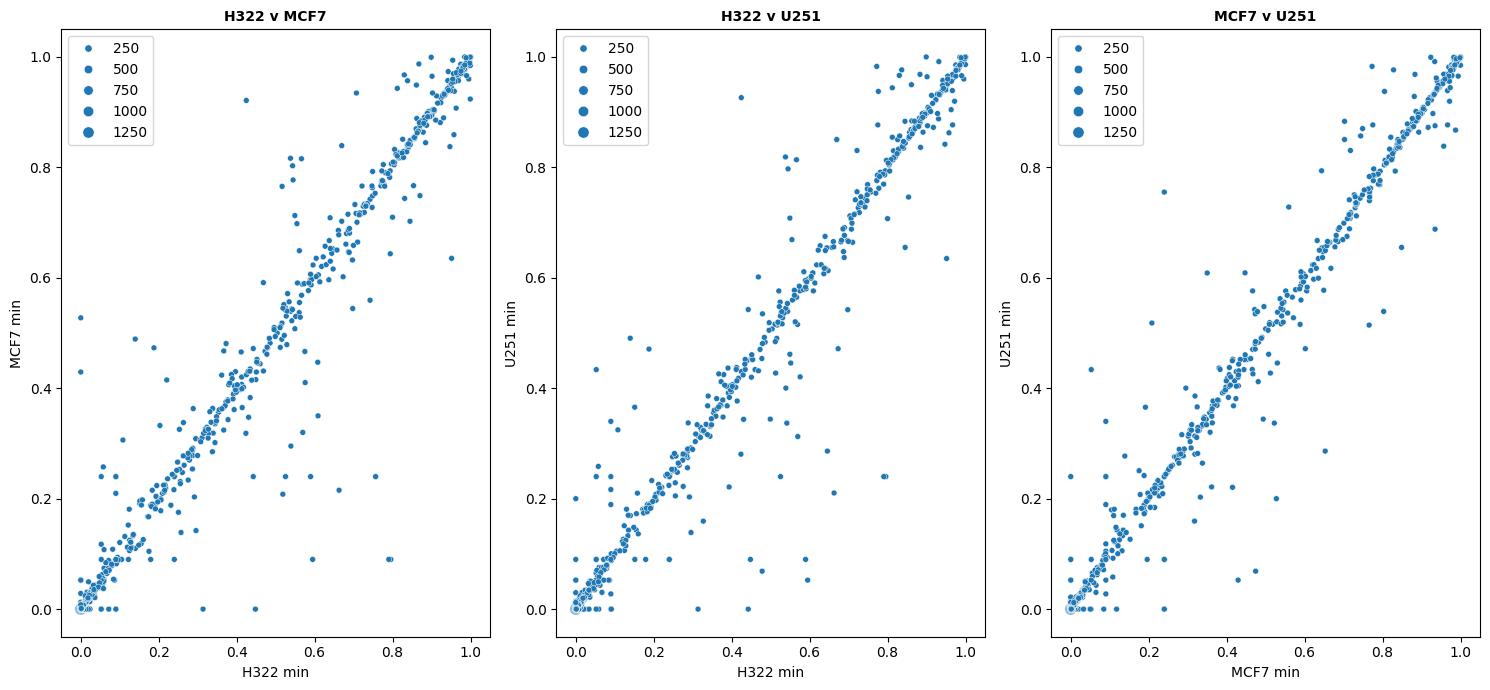

In [ ]:
# @title
f, axs = plt.subplots(1, 3, figsize=(15, 7), tight_layout=True)

sns.scatterplot(
        clustersELCFS_topParams.rename(
            columns={'min Score H322': 'H322 min',
                     'min Score MCF7': 'MCF7 min'}),
        x='H322 min', y='MCF7 min', size='prots', ax=axs[0])
axs[0].legend()
axs[0].set_title('H322 v MCF7', fontsize=10, fontweight='bold')

sns.scatterplot(
    clustersELCFS_topParams.rename(
        columns={'min Score H322': 'H322 min',
                 'min Score U251': 'U251 min'}),
    x='H322 min', y='U251 min', size='prots', ax=axs[1])
axs[1].legend()
axs[1].set_title('H322 v U251', fontsize=10, fontweight='bold')

sns.scatterplot(
    clustersELCFS_topParams.rename(
        columns={'min Score MCF7': 'MCF7 min',
                 'min Score U251': 'U251 min'}),
    x='MCF7 min', y='U251 min', size='prots', ax=axs[2])
axs[2].legend()
axs[2].set_title('MCF7 v U251', fontsize=10, fontweight='bold')

Text(0.5, 1.0, 'MCF7 v U251')

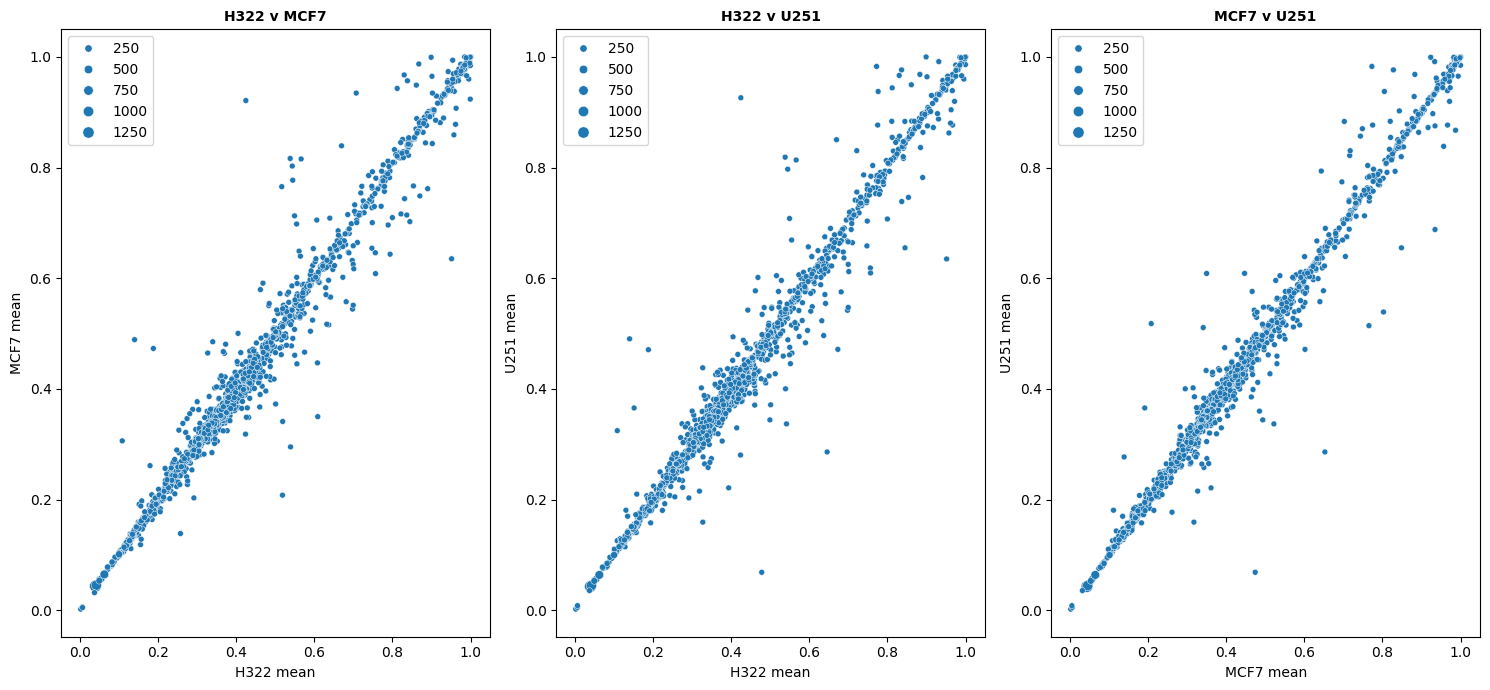

In [ ]:
f, axs = plt.subplots(1, 3, figsize=(15, 7), tight_layout=True)

sns.scatterplot(
        clustersELCFS_topParams.rename(
            columns={'mean Score H322': 'H322 mean',
                     'mean Score MCF7': 'MCF7 mean'}),
        x='H322 mean', y='MCF7 mean', size='prots', ax=axs[0])
axs[0].legend()
axs[0].set_title('H322 v MCF7', fontsize=10, fontweight='bold')

sns.scatterplot(
    clustersELCFS_topParams.rename(
        columns={'mean Score H322': 'H322 mean',
                 'mean Score U251': 'U251 mean'}),
    x='H322 mean', y='U251 mean', size='prots', ax=axs[1])
axs[1].legend()
axs[1].set_title('H322 v U251', fontsize=10, fontweight='bold')

sns.scatterplot(
    clustersELCFS_topParams.rename(
        columns={'mean Score MCF7': 'MCF7 mean',
                 'mean Score U251': 'U251 mean'}),
    x='MCF7 mean', y='U251 mean', size='prots', ax=axs[2])
axs[2].legend()
axs[2].set_title('MCF7 v U251', fontsize=10, fontweight='bold')

####**Table S2.  Summary of differences between cell-line-specific complex assembly predictions.**

> *Keep working on a better caption*

>> *Should be able to pull out high-confidence predictions*

In [ ]:
cplxPreds_cellLine_meanScore_diff = \
  pd.DataFrame({'cell line': sorted(list(cellLines))})
cplxPreds_cellLine_minScore_diff = \
  pd.DataFrame({'cell line': sorted(list(cellLines))})

In [ ]:
minScore_min = clustersELCFS_topParams['min Score'].min()
minScore_mean = clustersELCFS_topParams['min Score'].mean()
meanScore_min = clustersELCFS_topParams['min Score'].mean()
meanScore_mean = clustersELCFS_topParams['mean Score'].mean()

print('minScore mean: {0}'.format(minScore_mean))
print('meanScore mean: {0}'.format(meanScore_mean))
print('meanScore min: {0}'.format(meanScore_min))

minScore mean: 0.047225285945159325
meanScore mean: 0.29082747368706097
meanScore min: 0.047225285945159325


In [ ]:
minProts = 2

**total above t per cell line**

In [ ]:
#total clusters above threshold after rescoring with cell-line specific scores
clustsTotal_aboveThresh_mean = []
clustsTotal_aboveThresh_min = []
for line in sorted(list(cellLines)):
  print(line)

  clustsMean = \
    clustersELCFS_topParams.loc[
        (clustersELCFS_topParams.prots > minProts) &
         (clustersELCFS_topParams[
             'mean Score ' + line] >= meanScore_mean)].index.to_list()

  clustsMin = \
    clustersELCFS_topParams.loc[
        (clustersELCFS_topParams.prots > minProts) &
         (clustersELCFS_topParams[
             'min Score ' + line] >= meanScore_min)].index.to_list()

  clustsTotal_aboveThresh_mean.append(clustsMean)
  clustsTotal_aboveThresh_min.append(clustsMin)

  print('Total cell-line specific clusters above mean-min ' +
        'threshold: {0}'.format(len(clustsMean)))
  print('Total cell-line specific clusters above mean-min ' +
        'threshold: {0}\n'.format(len(clustsMin)))

cplxPreds_cellLine_meanScore_diff.insert(
    1, 'total clusters', [len(l) for l in clustsTotal_aboveThresh_mean])
cplxPreds_cellLine_minScore_diff.insert(
    1, 'total clusters', [len(l) for l in clustsTotal_aboveThresh_min])

H322
Total cell-line specific clusters above mean-min threshold: 934
Total cell-line specific clusters above mean-min threshold: 137

MCF7
Total cell-line specific clusters above mean-min threshold: 933
Total cell-line specific clusters above mean-min threshold: 133

U251
Total cell-line specific clusters above mean-min threshold: 923
Total cell-line specific clusters above mean-min threshold: 130



**common (above t for all cell lines)**

In [ ]:
#total clusters common above threshold after rescoring with cell-line specific scores
clustsCommon_aboveThresh_meanScore = \
  clustersELCFS_topParams.loc[(
      (clustersELCFS_topParams.prots > minProts) &
       ((clustersELCFS_topParams['mean Score H322'] >= meanScore_mean) &
        (clustersELCFS_topParams['mean Score MCF7'] >= meanScore_mean) &
         (clustersELCFS_topParams['mean Score U251'] >= meanScore_mean)))].index

clustsCommon_aboveThresh_minScore = \
  clustersELCFS_topParams.loc[(
      (clustersELCFS_topParams.prots > minProts) &
       ((clustersELCFS_topParams['min Score H322'] >= meanScore_min) &
        (clustersELCFS_topParams['min Score MCF7'] >= meanScore_min) &
         (clustersELCFS_topParams['min Score U251'] >= meanScore_min)))].index

cplxPreds_cellLine_meanScore_diff.insert(
    2, 'total common predictions', len(clustsCommon_aboveThresh_meanScore))
cplxPreds_cellLine_minScore_diff.insert(
    2, 'total common predictions', len(clustsCommon_aboveThresh_minScore))

print('Total cell-line specific clusters above mean-min ' +
      'threshold: {0}'.format(len(clustsCommon_aboveThresh_meanScore)))
print('Total cell-line specific clusters above mean-min ' +
      'threshold: {0}'.format(len(clustsCommon_aboveThresh_minScore)))

Total cell-line specific clusters above mean-min threshold: 911
Total cell-line specific clusters above mean-min threshold: 117


In [ ]:
#using the mean of complex constituent PPI estimates mean value
clustersELCFS_topParams.loc[
    clustsCommon_aboveThresh_meanScore, colsWanted].sort_values(
        by=['min Score'], ascending=False)

,cluster,UniProtKB Mapping,prots,corumDiff,corumDiff_pred,corumDiff_ref,stringDiff,stringDiff_pred,stringDiff_ref,min Score,mean Score,maxScore_min,maxScore_mean,min Score H322,min Score MCF7,min Score U251,mean Score H322,mean Score MCF7,mean Score U251
2951,"(51433, 29882, 64682)","(F5H0F9,Q9UJX4),Q9H1A4,Q9UJX6",3,5,0,5,3,0,3,0.890844,0.941776,0.001221,0.013855,0.890335,0.891556,0.890640,0.940740,0.954595,0.944585
870,"(23176, 4735, 55752)","(A6NFQ9,B7ZVZ1,Q92599),(A0A384N6H6,Q15019),(A0...",3,2,0,2,4,1,3,0.719068,0.840983,0.002808,0.000936,0.815979,0.817261,0.818787,0.849933,0.850259,0.850869
2196,"(1026, 1163, 81620)","P38936,Q9H211,(P61024,Q5T178)",3,3,2,1,6,2,4,0.685616,0.769002,0.182831,0.092738,0.742188,0.559357,0.728172,0.789057,0.696320,0.774193
1153,"(84246, 9412, 80306)","Q9H204,(A0A024RAW0,Q13503),Q9BTT4",3,6,1,5,7,2,5,0.562290,0.827006,0.000610,0.059049,0.804077,0.804688,0.804382,0.902201,0.843437,0.902486
81,"(8295, 6883, 117143)","Q96BN2,Q9Y4A5,Q16514",3,3,2,1,4,1,3,0.495961,0.683568,0.005310,0.047607,0.618103,0.620605,0.623413,0.739182,0.785751,0.786789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,"(3309, 331, 5501, 10226, 329)","(P11021,V9HWB4),(A0A140VJN8,O60664),Q13490,(B2...",5,5,4,1,8,4,4,0.000000,0.279819,0.014688,0.034167,0.014688,0.000000,0.009063,0.440809,0.414115,0.448282
993,"(5478, 595, 2483, 3778, 4000)","(A0A087WZL8,A0A1W2PP94,A0A1W2PPY5,A0A1W2PQK5,A...",5,5,4,1,9,4,5,0.000000,0.294667,0.000000,0.023910,0.000000,0.000000,0.000000,0.484422,0.471659,0.495569
987,"(5478, 121536, 595, 3778, 2146, 4000)","(A0A090N8E9,Q15910,S4S3R8),Q6ZN18,(A0A384MQX1,...",6,6,5,1,10,5,5,0.000000,0.217245,0.000000,0.015030,0.000000,0.000000,0.000000,0.345826,0.330796,0.340298
983,"(5033, 2923, 5034)","(P30101,V9HVY3),(A0A024R8S5,P07237),(P13674,Q5...",3,1,1,0,7,2,5,0.000000,0.574553,0.240000,0.041322,0.052500,0.240000,0.000000,0.719021,0.754188,0.712865


In [ ]:
#using the min of complex constituent PPI estimates mean value
clustersELCFS_topParams.loc[
    clustsCommon_aboveThresh_minScore, colsWanted].sort_values(
        by=['min Score'], ascending=False)

,cluster,UniProtKB Mapping,prots,corumDiff,corumDiff_pred,corumDiff_ref,stringDiff,stringDiff_pred,stringDiff_ref,min Score,mean Score,maxScore_min,maxScore_mean,min Score H322,min Score MCF7,min Score U251,mean Score H322,mean Score MCF7,mean Score U251
2951,"(51433, 29882, 64682)","(F5H0F9,Q9UJX4),Q9H1A4,Q9UJX6",3,5,0,5,3,0,3,0.890844,0.941776,0.001221,0.013855,0.890335,0.891556,0.890640,0.940740,0.954595,0.944585
870,"(23176, 4735, 55752)","(A6NFQ9,B7ZVZ1,Q92599),(A0A384N6H6,Q15019),(A0...",3,2,0,2,4,1,3,0.719068,0.840983,0.002808,0.000936,0.815979,0.817261,0.818787,0.849933,0.850259,0.850869
2196,"(1026, 1163, 81620)","P38936,Q9H211,(P61024,Q5T178)",3,3,2,1,6,2,4,0.685616,0.769002,0.182831,0.092738,0.742188,0.559357,0.728172,0.789057,0.696320,0.774193
1153,"(84246, 9412, 80306)","Q9H204,(A0A024RAW0,Q13503),Q9BTT4",3,6,1,5,7,2,5,0.562290,0.827006,0.000610,0.059049,0.804077,0.804688,0.804382,0.902201,0.843437,0.902486
81,"(8295, 6883, 117143)","Q96BN2,Q9Y4A5,Q16514",3,3,2,1,4,1,3,0.495961,0.683568,0.005310,0.047607,0.618103,0.620605,0.623413,0.739182,0.785751,0.786789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484,"(51107, 84447, 7402)","Q86TM6,(B4DUG7,Q96BI3),(P46939,Q6LBS5)",3,4,2,2,6,2,4,0.000000,0.337741,0.126568,0.031642,0.090000,0.209663,0.216568,0.573357,0.552716,0.541715
2481,"(6874, 6605, 23339)","Q96JC1,O00268,Q969G3",3,3,2,1,6,2,4,0.000000,0.347982,0.499691,0.086954,0.589691,0.240000,0.090000,0.641556,0.566059,0.554602
3042,"(5595, 1495, 2319, 1499, 55327)","(B4DGU4,P35222),(A0A384MDY0,B4DKT9,B4DU00,G3XA...",5,3,3,0,6,3,3,0.000000,0.449281,0.000000,0.003448,0.090000,0.090000,0.090000,0.588408,0.586600,0.584960
329,"(2319, 55327, 1499, 1495)","(B4DGU4,P35222),Q9NUP9,(J3QLD9,Q14254,Q6FG43,Q...",4,2,2,0,5,2,3,0.000000,0.486889,0.000000,0.008299,0.090000,0.090000,0.090000,0.605975,0.604150,0.612449


**pairwise (above t for all cell lines)**

In [ ]:
#total cell-line specific, pairwise exclusive clusters above threshold after rescoring with cell-line specific scores
clustsExcl_pairwise_meanScore = dict()
clustsExcl_pairwise_minScore = dict()
for line in sorted(list(cellLines)):
  print(line)
  xLine1 = cellLines_remain[line][0]
  xLine2 = cellLines_remain[line][1]

  clustsMean_a = \
    clustersELCFS_topParams.loc[(
        (clustersELCFS_topParams.prots > minProts) &
         ((clustersELCFS_topParams[
             'mean Score ' + line] >= meanScore_mean) &
              (clustersELCFS_topParams[
                  'mean Score ' + xLine1] >= meanScore_mean) &
                   (clustersELCFS_topParams[
                       'mean Score ' + xLine2] < meanScore_mean)))].index.to_list()

  clustsMean_b = \
    clustersELCFS_topParams.loc[(
        (clustersELCFS_topParams.prots > minProts) &
         ((clustersELCFS_topParams[
             'mean Score ' + line] >= meanScore_mean) &
              (clustersELCFS_topParams[
                  'mean Score ' + xLine2] >= meanScore_mean) &
                   (clustersELCFS_topParams[
                       'mean Score ' + xLine1] < meanScore_mean)))].index.to_list()
  clustsMean = clustsMean_a + clustsMean_b

  clustsMin_a = \
    clustersELCFS_topParams.loc[(
        (clustersELCFS_topParams.prots > minProts) &
         ((clustersELCFS_topParams[
             'min Score ' + line] >= meanScore_min) &
              (clustersELCFS_topParams[
                  'min Score ' + xLine1] >= meanScore_min) &
                   (clustersELCFS_topParams[
                       'min Score ' + xLine2] < meanScore_min)))].index.to_list()

  clustsMin_b = \
    clustersELCFS_topParams.loc[(
        (clustersELCFS_topParams.prots > minProts) &
         ((clustersELCFS_topParams[
             'min Score ' + line] >= meanScore_min) &
              (clustersELCFS_topParams[
                  'min Score ' + xLine2] >= meanScore_min) &
                   (clustersELCFS_topParams[
                       'min Score ' + xLine1] < meanScore_min)))].index.to_list()
  clustsMin = clustsMin_a + clustsMin_b

  clustsExcl_pairwise_meanScore[line] = clustsMean
  clustsExcl_pairwise_minScore[line] = clustsMin

  print('Total cell-line specific, pairwise exclusive clusters ' +
        'above mean-mean threshold: {0}'.format(len(clustsMean)))
  print('Total cell-line specific, pairwise exclusive clusters ' +
        'above mean-min threshold: {0}\n'.format(len(clustsMin)))

cplxPreds_cellLine_meanScore_diff.insert(
    3, 'total clusters pairwise exclusive',
     [len(l) for l in clustsExcl_pairwise_meanScore.values()])
cplxPreds_cellLine_minScore_diff.insert(
    3, 'total clusters pairwise exclusive',
     [len(l) for l in clustsExcl_pairwise_minScore.values()])

H322
Total cell-line specific, pairwise exclusive clusters above mean-mean threshold: 17
Total cell-line specific, pairwise exclusive clusters above mean-min threshold: 14

MCF7
Total cell-line specific, pairwise exclusive clusters above mean-mean threshold: 15
Total cell-line specific, pairwise exclusive clusters above mean-min threshold: 14

U251
Total cell-line specific, pairwise exclusive clusters above mean-mean threshold: 10
Total cell-line specific, pairwise exclusive clusters above mean-min threshold: 10



In [ ]:
clustersELCFS_topParams.loc[
    list(it.chain(*clustsExcl_pairwise_meanScore.values())),
    colsWanted].sort_values(by=['min Score'], ascending=False)

,cluster,UniProtKB Mapping,prots,corumDiff,corumDiff_pred,corumDiff_ref,stringDiff,stringDiff_pred,stringDiff_ref,min Score,mean Score,maxScore_min,maxScore_mean,min Score H322,min Score MCF7,min Score U251,mean Score H322,mean Score MCF7,mean Score U251
1585,"(5361, 351, 3909)","Q9UIW2,(A0A0A0MSA0,A0A0A0MTS5,A0A0A6YYF2,Q1678...",3,2,2,0,6,2,4,0.052189,0.194847,0.074986,0.027279,0.175018,0.104698,0.179684,0.308029,0.281573,0.308852
1585,"(5361, 351, 3909)","Q9UIW2,(A0A0A0MSA0,A0A0A0MTS5,A0A0A6YYF2,Q1678...",3,2,2,0,6,2,4,0.052189,0.194847,0.074986,0.027279,0.175018,0.104698,0.179684,0.308029,0.281573,0.308852
197,"(2058, 999, 55054)","(A0A0U2ZQU7,B3GN61,P12830,Q9UII7),(Q17RG0,Q53S...",3,3,2,1,6,2,4,0.019692,0.217706,0.000625,0.067279,0.036245,0.036245,0.036870,0.331860,0.308212,0.264582
197,"(2058, 999, 55054)","(A0A0U2ZQU7,B3GN61,P12830,Q9UII7),(Q17RG0,Q53S...",3,3,2,1,6,2,4,0.019692,0.217706,0.000625,0.067279,0.036245,0.036245,0.036870,0.331860,0.308212,0.264582
2800,"(3913, 4035, 3958)","(Q07954,Q59FG2),(A0A024R693,P17931),P55268",3,3,2,1,6,2,4,0.019062,0.223498,0.006874,0.020624,0.095927,0.089054,0.093417,0.292588,0.279475,0.300099
2800,"(3913, 4035, 3958)","(Q07954,Q59FG2),(A0A024R693,P17931),P55268",3,3,2,1,6,2,4,0.019062,0.223498,0.006874,0.020624,0.095927,0.089054,0.093417,0.292588,0.279475,0.300099
2883,"(143098, 56288, 51421)","Q9Y2J4,Q5T2T1,Q8TEW0",3,4,2,2,6,2,4,0.018754,0.278322,0.000304,0.111661,0.035314,0.035009,0.035009,0.318662,0.327080,0.215419
2883,"(143098, 56288, 51421)","Q9Y2J4,Q5T2T1,Q8TEW0",3,4,2,2,6,2,4,0.018754,0.278322,0.000304,0.111661,0.035314,0.035009,0.035009,0.318662,0.327080,0.215419
2973,"(3676, 3910, 3679, 3958)","(Q13683,Q4LE35),P13612,(A0A0A0MQS9,A0A0A0MTC7,...",4,4,3,1,7,3,4,0.018751,0.207016,0.004689,0.021296,0.016563,0.018437,0.021252,0.301545,0.291865,0.280248
2973,"(3676, 3910, 3679, 3958)","(Q13683,Q4LE35),P13612,(A0A0A0MQS9,A0A0A0MTC7,...",4,4,3,1,7,3,4,0.018751,0.207016,0.004689,0.021296,0.016563,0.018437,0.021252,0.301545,0.291865,0.280248


In [ ]:
clustersELCFS_topParams.loc[
    list(it.chain(*clustsExcl_pairwise_minScore.values())),
    colsWanted].sort_values(by=['min Score'], ascending=False)

,cluster,UniProtKB Mapping,prots,corumDiff,corumDiff_pred,corumDiff_ref,stringDiff,stringDiff_pred,stringDiff_ref,min Score,mean Score,maxScore_min,maxScore_mean,min Score H322,min Score MCF7,min Score U251,mean Score H322,mean Score MCF7,mean Score U251
3002,"(56288, 51421, 23368)","Q96KQ4,Q9Y2J4,Q8TEW0",3,3,2,1,7,2,5,0.120000,0.386334,0.442513,0.038885,0.442513,0.240000,0.000000,0.500473,0.465535,0.461588
3002,"(56288, 51421, 23368)","Q96KQ4,Q9Y2J4,Q8TEW0",3,3,2,1,7,2,5,0.120000,0.386334,0.442513,0.038885,0.442513,0.240000,0.000000,0.500473,0.465535,0.461588
3013,"(28957, 65003, 51263)","Q8TCC3,Q9Y3B7,(A0A0S2Z563,Q9Y2Q9)",3,47,1,46,34,1,33,0.051355,0.524605,0.011871,0.014084,0.047190,0.059061,0.047815,0.397080,0.410866,0.396783
3013,"(28957, 65003, 51263)","Q8TCC3,Q9Y3B7,(A0A0S2Z563,Q9Y2Q9)",3,47,1,46,34,1,33,0.051355,0.524605,0.011871,0.014084,0.047190,0.059061,0.047815,0.397080,0.410866,0.396783
2519,"(10096, 10092, 2908, 10097)","(E5KQF5,E5KQF6,F1D8N4,P04150),(B4DXW1,P61158),...",4,4,3,1,9,1,8,0.022186,0.508705,0.013124,0.003269,0.048126,0.047501,0.035002,0.587418,0.586117,0.589386
2519,"(10096, 10092, 2908, 10097)","(E5KQF5,E5KQF6,F1D8N4,P04150),(B4DXW1,P61158),...",4,4,3,1,9,1,8,0.022186,0.508705,0.013124,0.003269,0.048126,0.047501,0.035002,0.587418,0.586117,0.589386
3085,"(4170, 4712, 10632)","(A0A087WT64,C8YZ26,Q07820),O75964,(A0A087WZX2,...",3,3,2,1,7,2,5,0.015938,0.243877,0.020946,0.007600,0.058140,0.037194,0.049375,0.344480,0.336880,0.344251
3085,"(4170, 4712, 10632)","(A0A087WT64,C8YZ26,Q07820),O75964,(A0A087WZX2,...",3,3,2,1,7,2,5,0.015938,0.243877,0.020946,0.007600,0.058140,0.037194,0.049375,0.344480,0.336880,0.344251
240,"(143098, 8573, 64398)","Q5T2T1,(Q658X5,Q8N3R9),(A0A7I2RJN6,O14936)",3,3,2,1,6,2,4,0.006563,0.301701,0.021883,0.030620,0.062195,0.065010,0.043127,0.447723,0.450544,0.419924
240,"(143098, 8573, 64398)","Q5T2T1,(Q658X5,Q8N3R9),(A0A7I2RJN6,O14936)",3,3,2,1,6,2,4,0.006563,0.301701,0.021883,0.030620,0.062195,0.065010,0.043127,0.447723,0.450544,0.419924


**exclusive (above t for one cell line)**

In [ ]:
#total cell-line specific and exclusive clusters above threshold after rescoring with cell-line specific scores
clustsExcl_cellLine_meanScore = dict()
clustsExcl_cellLine_minScore = dict()
for line in sorted(list(cellLines)):
  print(line)
  xLine1 = cellLines_remain[line][0]
  xLine2 = cellLines_remain[line][1]

  clustsMean = \
    set(clustersELCFS_topParams.loc[(
        (clustersELCFS_topParams.prots > minProts) &
         ((clustersELCFS_topParams[
             'mean Score ' + line] >= meanScore_mean) &
              (clustersELCFS_topParams[
                  'mean Score ' + xLine1] < meanScore_mean) &
                   (clustersELCFS_topParams[
                       'mean Score ' + xLine2] < meanScore_mean))
         )].index.to_list())

  clustsMin = \
    set(clustersELCFS_topParams.loc[(
        (clustersELCFS_topParams.prots > minProts) &
         ((clustersELCFS_topParams['min Score ' + line] >= meanScore_min) &
          (clustersELCFS_topParams['min Score ' + xLine1] < meanScore_min) &
           (clustersELCFS_topParams['min Score ' + xLine2] < meanScore_min))
         )].index.to_list())

  clustsExcl_cellLine_meanScore[line] = clustsMean
  clustsExcl_cellLine_minScore[line] = clustsMin

  print('Total cell-line specific and exclusive clusters ' +
        'above mean-mean threshold: {0}'.format(len(clustsMean)))
  print('Total cell-line specific and exclusive clusters ' +
        'above mean-min threshold: {0}\n'.format(len(clustsMin)))

cplxPreds_cellLine_meanScore_diff.insert(
    4, 'total clusters exclusive',
     [len(l) for l in clustsExcl_cellLine_meanScore.values()])
cplxPreds_cellLine_minScore_diff.insert(
    4, 'total clusters exclusive',
     [len(l) for l in clustsExcl_cellLine_minScore.values()])

H322
Total cell-line specific and exclusive clusters above mean-mean threshold: 6
Total cell-line specific and exclusive clusters above mean-min threshold: 6

MCF7
Total cell-line specific and exclusive clusters above mean-mean threshold: 7
Total cell-line specific and exclusive clusters above mean-min threshold: 2

U251
Total cell-line specific and exclusive clusters above mean-mean threshold: 2
Total cell-line specific and exclusive clusters above mean-min threshold: 3



In [ ]:
clustersELCFS_topParams.loc[
    list(it.chain(*clustsExcl_cellLine_meanScore.values())),
    colsWanted].sort_values(by=['min Score'], ascending=False)

,cluster,UniProtKB Mapping,prots,corumDiff,corumDiff_pred,corumDiff_ref,stringDiff,stringDiff_pred,stringDiff_ref,min Score,mean Score,maxScore_min,maxScore_mean,min Score H322,min Score MCF7,min Score U251,mean Score H322,mean Score MCF7,mean Score U251
492,"(10445, 93973, 79913, 57634)","Q9H9F9,Q96L91,Q96EZ8,Q9H981",4,4,3,1,10,2,8,0.038453,0.217441,1.312995e-02,0.022337,0.052193,0.055617,0.065323,0.301563,0.279225,0.282739
2249,"(282991, 26258, 2647)","(A0A087X1N6,F1T0F0,Q6QNY1),(B3KY40,H3BST1,Q9UL...",3,2,1,1,5,1,4,0.029272,0.352437,1.031017e-02,0.090097,0.024064,0.029377,0.034374,0.281043,0.355314,0.265217
115,"(7813, 57132, 51510)","Q7LBR1,Q9NZZ3,(O60447,Q59FE7)",3,5,2,3,6,2,4,0.011668,0.218775,1.875804e-03,0.003985,0.012814,0.011251,0.010939,0.287603,0.291588,0.288563
1999,"(2067, 7507, 2072)","(A0A1W1GSK9,A0A804HKF9,B4DXD8,Q92889),P23025,P...",3,0,0,0,2,0,2,0.004374,0.165693,3.687096e-02,0.049379,0.067184,0.064682,0.030313,0.282506,0.282079,0.331458
2086,"(10440, 92609, 10452, 1861, 8910)","O96008,Q3ZCQ8,(B3KPA1,O14656),(A0A0S2Z4P5,A0A2...",5,4,4,0,8,3,5,0.000938,0.175667,7.152557e-07,0.010120,0.004375,0.004376,0.004375,0.286132,0.295698,0.285578
2586,"(3680, 1793, 6175, 27348, 2247)","P05388,(A0A2X0U2H5,B2RUU3,Q14185),P09038,(Q137...",5,5,4,1,8,4,4,0.000834,0.150019,3.125668e-04,0.003803,0.000938,0.000625,0.000938,0.289179,0.290919,0.287116
1108,"(1176, 55054, 58505, 1981)","(B2RU06,B2RU10,B4DSI9,O95065,Q04637,Q96I65),(Q...",4,6,3,3,7,3,4,0.000625,0.183219,2.811909e-03,0.008431,0.002500,0.002813,0.005312,0.293806,0.290251,0.285375
1359,"(10940, 7414, 54913, 128869, 7052)","(B3KXA2,P18206,V9HWK2),(B4DIT7,B4DTN7,P21980,V...",5,5,4,1,8,4,4,0.000312,0.152794,4.373789e-03,0.014655,0.003438,0.003126,0.007499,0.296130,0.281476,0.282340
309,"(55845, 868, 10163, 7189, 10006)","(B6VEX3,B6VEX4,B6VEX5,Q8IZP0),Q8WUW1,Q9Y4K3,Q9...",5,4,4,0,10,2,8,0.000104,0.208284,3.125668e-04,0.023919,0.000000,0.000313,0.000000,0.284319,0.288499,0.308238
3016,"(3364, 10109, 128866, 81027, 8881, 10092, 71, ...","(A4D275,O15143),(M0R1T5,O43633),Q9H4B7,P61160,...",13,6,6,0,9,8,1,0.000000,0.261301,0.000000e+00,0.001917,0.000000,0.000000,0.000000,0.291586,0.289669,0.289834


In [ ]:
clustersELCFS_topParams.loc[
    list(it.chain(*clustsExcl_cellLine_minScore.values())),
    colsWanted].sort_values(by=['min Score'], ascending=False)

,cluster,UniProtKB Mapping,prots,corumDiff,corumDiff_pred,corumDiff_ref,stringDiff,stringDiff_pred,stringDiff_ref,min Score,mean Score,maxScore_min,maxScore_mean,min Score H322,min Score MCF7,min Score U251,mean Score H322,mean Score MCF7,mean Score U251
2835,"(84342, 83548, 388552, 91949)","Q6QNY0,(A0A0S2Z652,P83436),Q96MW5,Q96JB2",4,4,3,1,6,1,5,0.012818,0.401830,0.013750,0.028265,0.039061,0.036566,0.050316,0.582486,0.554221,0.555796
1501,"(10075, 1020, 1021)","Q00534,Q7Z6Z7,(A0A090N7W4,A0A0S2Z355,Q00535)",3,3,2,1,7,2,5,0.004688,0.290406,0.014378,0.014352,0.036566,0.042813,0.050943,0.494001,0.507824,0.508354
1638,"(5265, 7531, 865)","(P62258,V9HW98),(E9KL23,P01009),Q13951",3,3,2,1,6,2,4,0.002501,0.181605,0.313713,0.078143,0.313713,0.000000,0.000000,0.345455,0.309871,0.267312
1912,"(91750, 2958, 55957)","(B3KN83,Q52LA3),(B2R506,P52657),Q96GY3",3,3,2,1,4,1,3,0.001250,0.231276,0.008747,0.022255,0.047810,0.039062,0.041246,0.460514,0.438259,0.438567
706,"(5265, 10492, 10452)","(E9KL23,P01009),(A0A7I2YQN2,B7Z645,O60506,Q59G...",3,3,2,1,6,2,4,0.000626,0.453772,0.052500,0.041010,0.052500,0.000000,0.000000,0.771105,0.730095,0.763652
366,"(25978, 57132, 30011, 128866, 27243, 51510)","(M0R1T5,O43633),(A0A8V8TQF6,B7Z6E8,Q5JPT6,Q96B...",6,5,5,0,9,3,6,0.000000,0.300908,0.010631,0.047745,0.055626,0.045308,0.044995,0.435619,0.465475,0.483364
625,"(10507, 59, 6207, 84311)","P62277,Q92854,(A0A087WU62,A0A087X2D5,B4DEF8),(...",4,8,3,5,7,3,4,0.000000,0.290419,0.090000,0.021413,0.090000,0.000000,0.000000,0.350857,0.329443,0.336590
909,"(6883, 5810, 143187, 5883)","Q99638,O60671,(A0A994J5N6,Q96AJ9),Q16514",4,3,2,1,6,2,4,0.000000,0.334807,0.052500,0.030869,0.000000,0.052500,0.000000,0.532026,0.535697,0.504828
501,"(56288, 8673, 51421)","Q9Y2J4,(B8ZZT4,Q9BV40),Q8TEW0",3,4,2,2,7,2,5,0.000000,0.386578,0.090000,0.027285,0.090000,0.000000,0.000000,0.578714,0.572856,0.600141
1319,"(2767, 65125, 4802, 4800, 4801)","P29992,P23511,(F8VSL3,P25208),Q13952,(A5D8Z4,F...",5,2,2,0,10,2,8,0.000000,0.272579,0.049383,0.012104,0.020000,0.049383,0.000000,0.417233,0.427050,0.414946


**cell-line specific complexes with CORUM support**

In [ ]:
#total clusters above threshold and in CORUM after rescoring with cell-type-specific estimates
clustsCORUM_aboveThresh_mean = dict()
clustsCORUM_aboveThresh_min = dict()
for line in cellLines:
  print(line)

  clustsMean = \
    clustersELCFS_topParams.loc[(
        (clustersELCFS_topParams.prots > minProts) &
        ((clustersELCFS_topParams['mean Score ' + line] >= meanScore_mean) &
         (clustersELCFS_topParams['CORUM'])))].index.to_list()

  clustsMin = \
    clustersELCFS_topParams.loc[(
        (clustersELCFS_topParams.prots > minProts) &
         ((clustersELCFS_topParams['min Score ' + line] >= meanScore_min) &
          (clustersELCFS_topParams['CORUM'])))].index.to_list()

  clustsCORUM_aboveThresh_mean[line] = clustsMean
  clustsCORUM_aboveThresh_min[line] = clustsMin

  print('Total cell-line specific clusters ' +
        'above mean-mean threshold and present in CORUM: {0}'.format(
            len(clustsMean)))
  print('Total cell-line specific and exclusive clusters ' +
        'above mean-min threshold: {0}\n'.format(
            len(clustsMin)))

cplxPreds_cellLine_meanScore_diff.insert(
    5, 'in CORUM', [len(l) for l in clustsCORUM_aboveThresh_mean.values()])
cplxPreds_cellLine_minScore_diff.insert(
    5, 'in CORUM', [len(l) for l in clustsCORUM_aboveThresh_min.values()])

H322
Total cell-line specific clusters above mean-mean threshold and present in CORUM: 3
Total cell-line specific and exclusive clusters above mean-min threshold: 3

MCF7
Total cell-line specific clusters above mean-mean threshold and present in CORUM: 3
Total cell-line specific and exclusive clusters above mean-min threshold: 3

U251
Total cell-line specific clusters above mean-mean threshold and present in CORUM: 4
Total cell-line specific and exclusive clusters above mean-min threshold: 2



In [ ]:
cplxPreds_cellLine_meanScore_diff.style.hide()

cell line,total clusters,total common predictions,total clusters pairwise exclusive,total clusters exclusive,in CORUM
H322,934,911,17,6,3
MCF7,933,911,15,7,3
U251,923,911,10,2,4


In [ ]:
cplxPreds_cellLine_meanScore_diff.iloc[:, 2:5].sum(axis=1, numeric_only=True)

0    934
1    933
2    923
dtype: int64

In [ ]:
cplxPreds_cellLine_meanScore_diff.iloc[:, 3:5].sum(numeric_only=True)

total clusters pairwise exclusive    42
total clusters exclusive             15
dtype: int64

In [ ]:
cplxPreds_cellLine_minScore_diff.style.hide()

cell line,total clusters,total common predictions,total clusters pairwise exclusive,total clusters exclusive,in CORUM
H322,137,117,14,6,3
MCF7,133,117,14,2,3
U251,130,117,10,3,2


In [ ]:
cplxPreds_cellLine_minScore_diff.iloc[:, 2:5].sum(axis=1, numeric_only=True)

0    137
1    133
2    130
dtype: int64

In [ ]:
cplxPreds_cellLine_minScore_diff.iloc[:, 3:5].sum(numeric_only=True)

total clusters pairwise exclusive    38
total clusters exclusive             11
dtype: int64

###**Figure XX.  Cumulative probability-difference distribution for CORUM-supported clusters across cell-line-specific predictions. The figure shows that the smaller the difference in probability among scored pairwise interactions, shared by at least two cell-line-specific predictors, the more likely those interactions are present in CORUM.**

> **Keep working on a better caption**

>> **Should be able to pull out high-confidence predictions**

In [ ]:
colsWanted_cplxSpec_probDiff_mean = \
  ['cluster', 'UniProtKB Mapping', 'CORUM', 'STRING',
   'min Score', 'mean Score', 'maxScore_min', 'maxScore_mean',
   'min Score H322', 'mean Score H322', 'min Score MCF7',
   'mean Score MCF7', 'min Score U251', 'mean Score U251',
   'corumDiff', 'corumDiff_pred', 'corumDiff_ref',
   'stringDiff', 'stringDiff_pred', 'stringDiff_ref']

colsWanted_cplxSpec_probDiff_min = \
  ['cluster', 'UniProtKB Mapping', 'CORUM', 'STRING',
   'min Score', 'mean Score', 'maxScore_min', 'maxScore_mean',
   'min Score H322', 'mean Score H322', 'min Score MCF7',
   'mean Score MCF7', 'min Score U251', 'mean Score U251',
   'corumDiff', 'corumDiff_pred', 'corumDiff_ref',
   'stringDiff', 'stringDiff_pred', 'stringDiff_ref']

In [ ]:
probDiff_cellSpec_cplxMean = \
  pd.concat([
      clustersELCFS_topParams[
          colsWanted_cplxSpec_probDiff_mean + ['H322 - MCF7 mean']
          ].rename(columns={'H322 - MCF7 mean': 'diff'}).dropna().reset_index(drop=True),
      clustersELCFS_topParams[
          colsWanted_cplxSpec_probDiff_mean + ['H322 - U251 mean']
          ].rename(columns={'H322 - U251 mean': 'diff'}).dropna().reset_index(drop=True),
      clustersELCFS_topParams[
          colsWanted_cplxSpec_probDiff_mean + ['MCF7 - U251 mean']
          ].rename(columns={'MCF7 - U251 mean': 'diff'}).dropna().reset_index(drop=True)], axis=0)
probDiff_cellSpec_cplxMean.shape

(5280, 21)

In [ ]:
probDiff_cellSpec_cplxMin = \
  pd.concat([
      clustersELCFS_topParams[
          colsWanted_cplxSpec_probDiff_min + ['H322 - MCF7 min']
          ].rename(columns={'H322 - MCF7 min': 'diff'}).dropna().reset_index(drop=True),
      clustersELCFS_topParams[
          colsWanted_cplxSpec_probDiff_min + ['H322 - U251 min']
          ].rename(columns={'H322 - U251 min': 'diff'}).dropna().reset_index(drop=True),
      clustersELCFS_topParams[
          colsWanted_cplxSpec_probDiff_min + ['MCF7 - U251 min']
          ].rename(columns={'MCF7 - U251 min': 'diff'}).dropna().reset_index(drop=True)], axis=0)
probDiff_cellSpec_cplxMin.shape

(5280, 21)

**Fig S3**

"\nplt.title('Common interactions', fontsize=10, fontweight='bold')\nplt.xlabel('Probability difference', fontsize=10, fontweight='bold')\nplt.ylabel('Proportion', fontsize=10, fontweight='bold')\n"

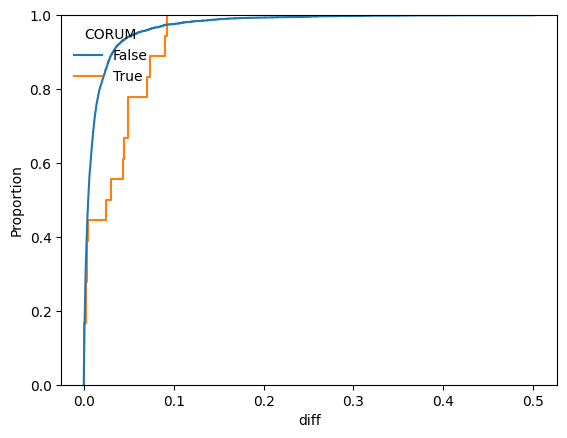

In [ ]:
f = sns.ecdfplot(
    data=probDiff_cellSpec_cplxMean,
    x='diff', hue='CORUM', stat='proportion')
sns.move_legend(f, 'upper left', frameon=False)
'''
plt.title('Common interactions', fontsize=10, fontweight='bold')
plt.xlabel('Probability difference', fontsize=10, fontweight='bold')
plt.ylabel('Proportion', fontsize=10, fontweight='bold')
'''

"\nplt.title('Common interactions', fontsize=10, fontweight='bold')\nplt.xlabel('Probability difference', fontsize=10, fontweight='bold')\nplt.ylabel('Proportion', fontsize=10, fontweight='bold')\n"

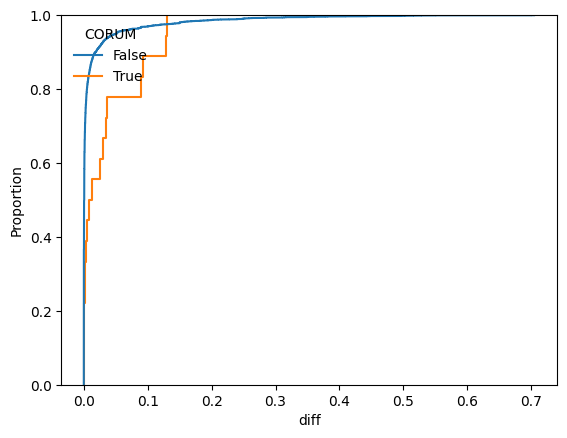

In [ ]:
f = sns.ecdfplot(data=probDiff_cellSpec_cplxMin,
                 x='diff', hue='CORUM', stat='proportion')
sns.move_legend(f, 'upper left', frameon=False)
'''
plt.title('Common interactions', fontsize=10, fontweight='bold')
plt.xlabel('Probability difference', fontsize=10, fontweight='bold')
plt.ylabel('Proportion', fontsize=10, fontweight='bold')
'''

In [ ]:
#To-Do
#generate scatterplots for complexes scores for pairs of cell lines

In [ ]:
cplxPreds_cellType_cplxStats_cols = \
  ['cplx', 'clusterONE', 'clusterONE+MCL',
   'CORUM', 'H322', 'MCF7', 'U251']

cplxPreds_cellType_cplxStats = \
  pd.DataFrame(columns=cplxPreds_cellType_cplxStats_cols)

allCplxs_cellType_bothMethods = \
  list(allClusters_cl1.union(allClusters_cl1MCL))

cplxPreds_cellType_cplxStats['cplx'] = allCplxs_cellType_bothMethods

In [ ]:
cplxPreds_cellType_cplxStats['clusterONE'] = \
  [cplx in allClusters_cl1 for cplx in allCplxs_cellType_bothMethods]

cplxPreds_cellType_cplxStats['clusterONE+MCL'] = \
  [cplx in allClusters_cl1MCL for cplx in allCplxs_cellType_bothMethods]

cplxPreds_cellType_cplxStats['CORUM'] = \
  [cplx in set(accessCORUM.humanCplx_frozen) for cplx in allCplxs_cellType_bothMethods]

In [ ]:
cplxPreds_cellType_cplxStats['STRINGv12 80% overlap'] = \
  [any([len(cplx.intersection(ref))/len(cplx.union(ref)) > 0.8
        for ref in list(cmpStudies.stringCplxs)])
    for cplx in allCplxs_cellType_bothMethods]
len(cplxPreds_cellType_cplxStats.loc[cplxPreds_cellType_cplxStats['STRINGv12 80% overlap']])

In [ ]:
cplxPreds_cellType_cplxStats['STRINGv12 75% overlap'] = \
  [any([len(cplx.intersection(ref))/len(cplx.union(ref)) > 0.75
        for ref in list(cmpStudies.stringCplxs)])
    for cplx in allCplxs_cellType_bothMethods]
len(cplxPreds_cellType_cplxStats.loc[cplxPreds_cellType_cplxStats['STRINGv12 75% overlap']])

In [ ]:
cplxPreds_cellType_cplxStats['STRINGv12 70% overlap'] = \
  [any([len(cplx.intersection(ref))/len(cplx.union(ref)) > 0.70
        for ref in list(cmpStudies.stringCplxs)])
    for cplx in allCplxs_cellType_bothMethods]
len(cplxPreds_cellType_cplxStats.loc[cplxPreds_cellType_cplxStats['STRINGv12 70% overlap']])

10

In [ ]:
cplxPreds_cellType_cplxStats['STRINGv12 65% overlap'] = \
  [any([len(cplx.intersection(ref))/len(cplx.union(ref)) > 0.65
        for ref in list(cmpStudies.stringCplxs)])
    for cplx in allCplxs_cellType_bothMethods]
len(cplxPreds_cellType_cplxStats.loc[cplxPreds_cellType_cplxStats['STRINGv12 65% overlap']]    )

25

In [ ]:
for cellType in cellTypes:
  cplxPreds_cellType_cplxStats[cellType] = \
    [cplx in set().union(*[
        cplxPreds_cellType.loc[cellType, 'clusterONE clusters'].union(
            cplxPreds_cellType.loc[cellType, 'clusterONE+MCL clusters'])])
    for cplx in allCplxs_cellType_bothMethods]

In [ ]:
cplxPreds_cellType_cplxStats.insert(
    1, 'ppis possible',
     [set([frozenset(pair)
     for pair in list(it.combinations(cplx, 2))]) if len(cplx) > 1 else np.nan
      for cplx in cplxPreds_cellType_cplxStats.cplx])

In [ ]:
for cellType in cellTypes:
  cplxPreds_cellType_cplxStats[cellType + ' mean score'] = ''
  cplxPreds_cellType_cplxStats[cellType + ' min score'] = ''

In [ ]:
for cellType in cellTypes:
  cellSpecific_ppis[cellType] = cellSpecific_ppis[cellType].astype(float)

In [ ]:
cplxPreds_cellType_cplxStats = \
  cplxPreds_cellType_cplxStats[['cplx', 'ppis possible', 'ppis',
                                'clusterONE', 'clusterONE+MCL',
                                'CORUM', 'STRINGv12',
                                'H322', 'H322 mean score', 'H322 min score',
                                'MCF7', 'MCF7 mean score', 'MCF7 min score',
                                'U251', 'U251 mean score', 'U251 min score',
                                'STRINGv12 80% overlap', 'STRINGv12 75% overlap',
                                'STRINGv12 70% overlap', 'STRINGv12 65% overlap']]

In [ ]:
cplxPreds_cellType_cplxStats.loc[
    cplxPreds_cellType_cplxStats['ppis possible'].isna(), 'ppis'] = np.nan

In [ ]:
for cellType in cellTypes:
  cplxPreds_cellType_cplxStats.loc[~cplxPreds_cellType_cplxStats[cellType],
   [cellType + ' mean score', cellType + ' min score']] = np.nan
cplxPreds_cellType_cplxStats

,cplx,ppis possible,ppis,clusterONE,clusterONE+MCL,CORUM,STRINGv12,H322,H322 mean score,H322 min score,MCF7,MCF7 mean score,MCF7 min score,U251,U251 mean score,U251 min score,STRINGv12 80% overlap,STRINGv12 75% overlap,STRINGv12 70% overlap,STRINGv12 65% overlap
0,"(55929, 8089, 10933, 10902)","{(8089, 10933), (10933, 10902), (8089, 10902),...","{(8089, 10933), (10933, 10902), (8089, 10902),...",False,True,False,False,False,NaN,NaN,True,,,False,NaN,NaN,False,False,False,False
1,"(51021, 5520, 7014, 10589)","{(51021, 10589), (51021, 5520), (5520, 7014), ...","{(51021, 10589), (51021, 5520), (5520, 7014), ...",False,True,False,False,False,NaN,NaN,True,,,False,NaN,NaN,False,False,False,False
2,"(8317, 60561, 116461)","{(60561, 116461), (8317, 116461), (8317, 60561)}","{(60561, 116461), (8317, 116461), (8317, 60561)}",False,True,False,False,False,NaN,NaN,True,,,True,,,False,False,False,False
3,"(51082, 3728, 64425, 2521, 8607, 51138, 10849,...","{(51082, 57128), (8766, 89941), (10849, 8607),...","{(51082, 57128), (8766, 89941), (10849, 8607),...",True,False,False,False,False,NaN,NaN,True,,,False,NaN,NaN,False,False,False,False
4,"(23405, 23450, 6118, 3696)","{(23450, 3696), (23450, 6118), (23405, 6118), ...","{(23450, 3696), (23450, 6118), (23405, 6118), ...",False,True,False,False,False,NaN,NaN,False,NaN,NaN,True,,,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14634,"(30836, 967)","{(30836, 967)}","{(30836, 967)}",False,True,False,False,True,,,True,,,True,,,False,False,False,False
14635,"(5052, 51230, 6879, 4323, 7416, 6667, 8662, 51...","{(8662, 4976), (546, 9652), (8662, 996), (5190...","{(8662, 4976), (546, 9652), (8662, 996), (5190...",True,False,False,False,True,,,False,NaN,NaN,False,NaN,NaN,False,False,False,False
14636,(6837),NaN,,False,True,False,False,True,,,True,,,True,,,False,False,False,False
14637,"(51604, 10026, 23049, 94005, 6400)","{(51604, 23049), (94005, 51604), (10026, 6400)...","{(51604, 23049), (94005, 51604), (10026, 6400)...",False,True,False,False,True,,,False,NaN,NaN,False,NaN,NaN,False,False,False,False


Following pooled functions are calculating the complex scores from the PPI scores that could have played a role in constituting the complex.

In [ ]:
with Pool(numWorkers) as pool:
    cplxPreds_cellType_cplxStats.loc[
        (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
         cplxPreds_cellType_cplxStats['H322']), 'H322 mean score'] = \
          list(progressMonitor(pool.imap(
              calcMean_h322,
              cplxPreds_cellType_cplxStats.loc[
                  (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
                   cplxPreds_cellType_cplxStats['H322']), 'ppis']),
                               total=len(cplxPreds_cellType_cplxStats.loc[
                                   (cplxPreds_cellType_cplxStats['ppis'].notnull()
                                   & cplxPreds_cellType_cplxStats['H322']), 'ppis'])))

100%|██████████| 6543/6543 [00:22<00:00, 292.03it/s]


In [ ]:
with Pool(numWorkers) as pool:
    cplxPreds_cellType_cplxStats.loc[
        (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
         cplxPreds_cellType_cplxStats['H322']), 'H322 min score'] = \
          list(progressMonitor(pool.imap(
              calcMin_h322,
              cplxPreds_cellType_cplxStats.loc[
                  (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
                   cplxPreds_cellType_cplxStats['H322']), 'ppis']),
                               total=len(cplxPreds_cellType_cplxStats.loc[
                                   (cplxPreds_cellType_cplxStats['ppis'].notnull()
                                   & cplxPreds_cellType_cplxStats['H322']), 'ppis'])))

100%|██████████| 6543/6543 [00:20<00:00, 312.55it/s]


In [ ]:
with Pool(numWorkers) as pool:
    cplxPreds_cellType_cplxStats.loc[
        (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
         cplxPreds_cellType_cplxStats['MCF7']), 'MCF7 mean score'] = \
          list(progressMonitor(pool.imap(
              calcMean_mcf7,
              cplxPreds_cellType_cplxStats.loc[
                  (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
                   cplxPreds_cellType_cplxStats['MCF7']), 'ppis']),
                               total=len(cplxPreds_cellType_cplxStats.loc[
                                   (cplxPreds_cellType_cplxStats['ppis'].notnull()
                                   & cplxPreds_cellType_cplxStats['MCF7']), 'ppis'])))

100%|██████████| 6593/6593 [00:21<00:00, 306.82it/s]


In [ ]:
with Pool(numWorkers) as pool:
    cplxPreds_cellType_cplxStats.loc[
        (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
         cplxPreds_cellType_cplxStats['MCF7']), 'MCF7 min score'] = \
          list(progressMonitor(pool.imap(
              calcMin_mcf7,
              cplxPreds_cellType_cplxStats.loc[
                  (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
                   cplxPreds_cellType_cplxStats['MCF7']), 'ppis']),
                               total=len(cplxPreds_cellType_cplxStats.loc[
                                   (cplxPreds_cellType_cplxStats['ppis'].notnull()
                                   & cplxPreds_cellType_cplxStats['MCF7']), 'ppis'])))

100%|██████████| 6593/6593 [00:21<00:00, 309.92it/s]


In [ ]:
with Pool(numWorkers) as pool:
    cplxPreds_cellType_cplxStats.loc[
        (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
         cplxPreds_cellType_cplxStats['U251']), 'U251 mean score'] = \
          list(progressMonitor(pool.imap(
              calcMean_u251,
              cplxPreds_cellType_cplxStats.loc[
                  (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
                   cplxPreds_cellType_cplxStats['U251']), 'ppis']),
                               total=len(cplxPreds_cellType_cplxStats.loc[
                                   (cplxPreds_cellType_cplxStats['ppis'].notnull()
                                   & cplxPreds_cellType_cplxStats['U251']), 'ppis'])))

100%|██████████| 6772/6772 [00:22<00:00, 304.34it/s]


In [ ]:
with Pool(numWorkers) as pool:
    cplxPreds_cellType_cplxStats.loc[
        (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
         cplxPreds_cellType_cplxStats['U251']), 'U251 min score'] = \
          list(progressMonitor(pool.imap(
              calcMin_u251,
              cplxPreds_cellType_cplxStats.loc[
                  (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
                   cplxPreds_cellType_cplxStats['U251']), 'ppis']),
                               total=len(cplxPreds_cellType_cplxStats.loc[
                                   (cplxPreds_cellType_cplxStats['ppis'].notnull()
                                   & cplxPreds_cellType_cplxStats['U251']), 'ppis'])))

100%|██████████| 6772/6772 [00:21<00:00, 315.28it/s]


In [ ]:
cplxPreds_cellType_cplxStats['H322 - MCF7 mean'] = np.nan
cplxPreds_cellType_cplxStats['H322 - MCF7 min'] = np.nan

cplxPreds_cellType_cplxStats['H322 - U251 mean'] = np.nan
cplxPreds_cellType_cplxStats['H322 - U251 min'] = np.nan

cplxPreds_cellType_cplxStats['MCF7 - U251 mean'] = np.nan
cplxPreds_cellType_cplxStats['MCF7 - U251 min'] = np.nan

cellType_pairs = list(it.combinations(cellTypes, 2))
cellType_pairs

[('H322', 'MCF7'), ('H322', 'U251'), ('MCF7', 'U251')]

In [ ]:
for pair in cellType_pairs:
  typeA, typeB = pair
  meanCol = typeA + ' - ' + typeB + ' mean'
  minCol = typeA + ' - ' + typeB + ' min'
  print(meanCol)
  print(minCol)

  cplxPreds_cellType_cplxStats.loc[
      (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
       cplxPreds_cellType_cplxStats[typeA] &
       cplxPreds_cellType_cplxStats[typeB]), meanCol] = \
          cplxPreds_cellType_cplxStats.loc[
              (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
               cplxPreds_cellType_cplxStats[typeA] &
               cplxPreds_cellType_cplxStats[typeB]), typeA + ' mean score'] - \
                        cplxPreds_cellType_cplxStats.loc[
                            (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
                             cplxPreds_cellType_cplxStats[typeA] &
                             cplxPreds_cellType_cplxStats[typeB]),
                            typeB + ' mean score']

  cplxPreds_cellType_cplxStats.loc[
      (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
       cplxPreds_cellType_cplxStats[typeA] &
       cplxPreds_cellType_cplxStats[typeB]), minCol] = \
          cplxPreds_cellType_cplxStats.loc[
              (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
               cplxPreds_cellType_cplxStats[typeA] &
               cplxPreds_cellType_cplxStats[typeB]), typeA + ' min score'] - \
                        cplxPreds_cellType_cplxStats.loc[
                            (cplxPreds_cellType_cplxStats['ppis possible'].notnull() &
                             cplxPreds_cellType_cplxStats[typeA] &
                             cplxPreds_cellType_cplxStats[typeB]),
                            typeB + ' min score']

H322 - MCF7 mean
H322 - MCF7 min
H322 - U251 mean
H322 - U251 min
MCF7 - U251 mean
MCF7 - U251 min


In [ ]:
colsReordered = \
  ['cplx', 'ppis', 'ppis possible',
   'clusterONE', 'clusterONE+MCL',
   'H322', 'H322 mean score', 'H322 min score',
   'MCF7', 'MCF7 mean score', 'MCF7 min score',
   'U251', 'U251 mean score', 'U251 min score',
   'H322 - MCF7 mean', 'H322 - MCF7 min',
   'H322 - U251 mean', 'H322 - U251 min',
   'MCF7 - U251 mean', 'MCF7 - U251 min',
   'CORUM', 'STRINGv12',
   'STRINGv12 80% overlap', 'STRINGv12 75% overlap',
   'STRINGv12 70% overlap', 'STRINGv12 65% overlap']
cplxPreds_cellType_cplxStats = \
  cplxPreds_cellType_cplxStats[colsReordered]

In [ ]:
cplxPreds_cellType_cplxStats['cplx length'] = \
  cplxPreds_cellType_cplxStats['cplx'].apply(lambda x: len(x))

In [ ]:
tbl4Present_cols = \
  ['cplx',
   'clusterONE', 'clusterONE+MCL',
   'H322 mean score', 'H322 min score',
   'MCF7 mean score', 'MCF7 min score',
   'U251 mean score', 'U251 min score',
   'CORUM', 'STRINGv12 80% overlap', 'STRINGv12 65% overlap']

In [ ]:
idCols = \
  ['cplx',
   'clusterONE', 'clusterONE+MCL',
   'CORUM',
   'STRINGv12 80% overlap', 'STRINGv12 75% overlap',
   'STRINGv12 70% overlap', 'STRINGv12 65% overlap']

pairDiff_cols = \
  ['cplx',
   'clusterONE', 'clusterONE+MCL',
   'H322 - MCF7 mean', 'H322 - MCF7 min',
   'H322 - U251 mean', 'H322 - U251 min',
   'MCF7 - U251 mean', 'MCF7 - U251 min',
   'CORUM',
   'STRINGv12 80% overlap', 'STRINGv12 75% overlap',
   'STRINGv12 70% overlap', 'STRINGv12 65% overlap']

meanDiff_cols = ['H322 - MCF7 mean', 'H322 - U251 mean', 'MCF7 - U251 mean']
minDiff_cols = ['H322 - U251 min', 'MCF7 - U251 min', 'H322 - MCF7 min']

In [ ]:
pairDiff = cplxPreds_cellType_cplxStats.loc[:, pairDiff_cols].copy()
pairDiff_simple = \
  pd.melt(pairDiff, id_vars=idCols,
          var_name='pair', value_name='score difference')
pairDiff_simple.dropna(subset=['score difference'], inplace=True)
pairDiff_simple['score difference'] = pairDiff_simple['score difference'].abs()

In [ ]:
print(len(pairDiff_simple))
print(len(pairDiff_simple.loc[pairDiff_simple.CORUM]))

print(len(pairDiff_simple.loc[pairDiff_simple.clusterONE]))
print(len(pairDiff_simple.loc[
    (pairDiff_simple.clusterONE) & (pairDiff_simple.CORUM)]))

print(len(pairDiff_simple.loc[pairDiff_simple['clusterONE+MCL']]))
print(len(pairDiff_simple.loc[
    (pairDiff_simple['clusterONE+MCL']) & (pairDiff_simple.CORUM)]))
pairDiff_simple.head()

11804
20
5956
6
9086
20


,cplx,clusterONE,clusterONE+MCL,CORUM,STRINGv12 80% overlap,STRINGv12 75% overlap,STRINGv12 70% overlap,STRINGv12 65% overlap,pair,score difference
11,"(4323, 9372, 9739)",False,True,False,False,False,False,False,H322 - MCF7 mean,0.006226
14,"(9318, 8454, 1459, 64708)",False,True,False,False,False,False,False,H322 - MCF7 mean,0.000418
19,"(2960, 8487, 6938, 6929, 9658)",False,True,False,False,False,False,False,H322 - MCF7 mean,0.016422
21,"(522, 9043, 10256, 9612)",True,True,False,False,False,False,False,H322 - MCF7 mean,0.004629
22,"(8828, 9232, 126626)",False,True,False,False,False,False,False,H322 - MCF7 mean,0.007779


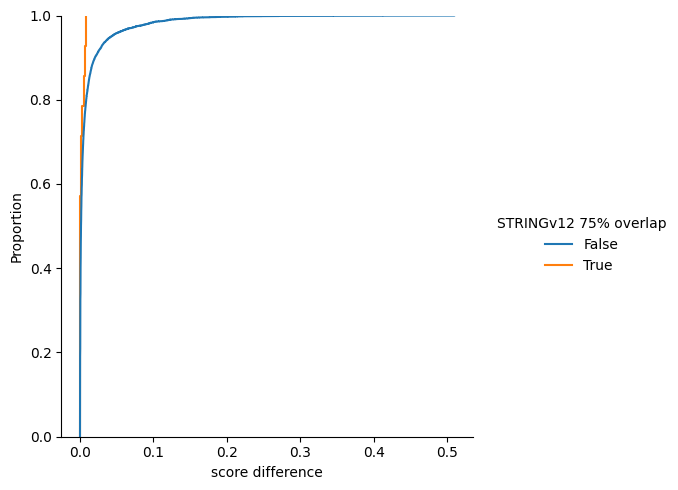

In [ ]:
f = sns.displot(data=pairDiff_simple,
                x='score difference', hue='CORUM', kind='ecdf', stat='proportion')

Text(0, 0.5, 'Proportion')

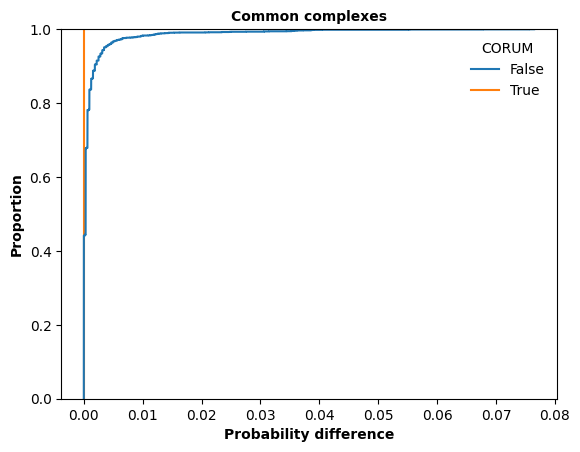

In [ ]:
f = \
  sns.ecdfplot(
      data=pairDiff_simple.loc[
          (pairDiff_simple.clusterONE) & (pairDiff_simple.pair.isin(minDiff_cols))],
      x='score difference', hue='CORUM', stat='proportion')
sns.move_legend(f, 'upper right', frameon=False)
plt.title('Common complexes', fontsize=10, fontweight='bold')
plt.xlabel('Probability difference', fontsize=10, fontweight='bold')
plt.ylabel('Proportion', fontsize=10, fontweight='bold')

Text(0, 0.5, 'Proportion')

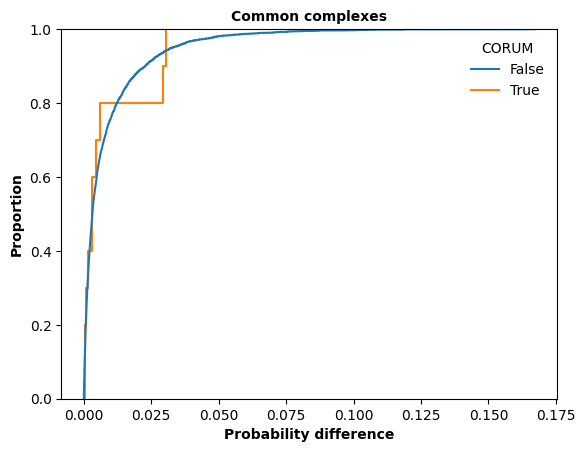

In [ ]:
f = \
  sns.ecdfplot(
      data=pairDiff_simple.loc[
          (pairDiff_simple['clusterONE+MCL']) & (pairDiff_simple.pair.isin(meanDiff_cols))],
      x='score difference', hue='CORUM', stat='proportion')
sns.move_legend(f, 'upper right', frameon=False)
plt.title('Common complexes', fontsize=10, fontweight='bold')
plt.xlabel('Probability difference', fontsize=10, fontweight='bold')
plt.ylabel('Proportion', fontsize=10, fontweight='bold')

Text(0, 0.5, 'Proportion')

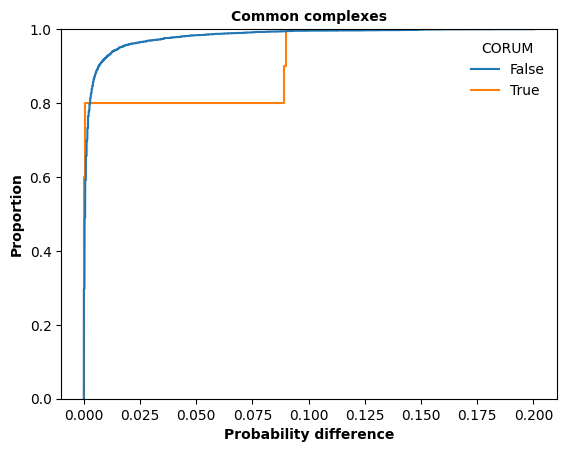

In [ ]:
f = \
  sns.ecdfplot(
      data=pairDiff_simple.loc[
          (pairDiff_simple['clusterONE+MCL']) & (pairDiff_simple.pair.isin(minDiff_cols))],
      x='score difference', hue='CORUM', stat='proportion')
sns.move_legend(f, 'upper right', frameon=False)
plt.title('Common complexes', fontsize=10, fontweight='bold')
plt.xlabel('Probability difference', fontsize=10, fontweight='bold')
plt.ylabel('Proportion', fontsize=10, fontweight='bold')